In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from datetime import datetime
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import KFold
from tensorflow.keras import layers, initializers
from tqdm.notebook import tqdm


print(f'GPUs Available: {len(tf.config.list_physical_devices("GPU"))}')
print(f'Device name: {tf.test.gpu_device_name()}')

GPUs Available: 1
Device name: /device:GPU:0


In [2]:
# Normalised input features
INPUT_SIGNAL_TYPES = [
    "XMV(1)", "XMV(2)", "XMV(3)", "XMV(4)", "XMV(5)", "XMV(6)", "XMV(7)", "XMV(8)", "XMV(9)", "XMV(10)", "XMV(11)"
]

# Output classes
LABELS = ["NORMAL ", "FAULT 1", "FAULT 2", "FAULT 3", "FAULT 4", "FAULT 5", "FAULT 7"]

# Input folders paths
DATASET_PATH = "tep/input/tep_dataset/"

TRAIN = "train/"
TEST = "test/"

X_train_signals_paths = [DATASET_PATH + TRAIN + signal + ".txt" for signal in INPUT_SIGNAL_TYPES]
X_test_signals_paths = [DATASET_PATH + TEST + signal + ".txt" for signal in INPUT_SIGNAL_TYPES]

y_train_path = DATASET_PATH + TRAIN + "idv.txt"
y_test_path = DATASET_PATH + TEST + "idv.txt"


# Helper functions
def load_X(X_signals_paths):
    # Function returns the input features tensor.
    X_signals = []
    for signal_type_path in X_signals_paths:
        with open(signal_type_path, 'r') as file:
            # Read dataset from disk, dealing with text files' syntax
            X_signals.append([np.array(serie, dtype=np.float32) for serie in [row.split(' ') for row in file]])    
    return np.transpose(np.array(X_signals), (1, 2, 0))


def load_y(y_path):
    # Function returns the fault labels vector.
    with open(y_path, 'r') as file:
        # Read dataset from disk, dealing with text file's syntax
        y_ = np.array([elem for elem in [row.split(' ') for row in file]], dtype=np.int32)
    return y_


def model_size(model):
    return np.sum([np.prod(np.array(var.numpy().shape)) for var in model.trainable_variables])


class StackedLSTM(tf.keras.Model):
    
    def __init__(self):
        super(StackedLSTM, self).__init__()
        self.dense1 = layers.Dense(32, 
                                   activation='relu', 
                                   kernel_initializer=initializers.RandomNormal(stddev=1.), 
                                   bias_initializer=initializers.RandomNormal(stddev=1.))
        self.dense2 = layers.Dense(8,
                                   kernel_initializer=initializers.RandomNormal(mean=1., stddev=1.), 
                                   bias_initializer=initializers.RandomNormal(stddev=1.))
        self.lstm1 = layers.LSTM(32, return_sequences=True)
        self.lstm2 = layers.LSTM(32)
        
    def call(self, x):
        x = self.dense1(x)
        x = self.lstm1(x)
        x = self.lstm2(x)
        x = self.dense2(x)
        return x

In [3]:
# Input features tensors
X_train = load_X(X_train_signals_paths)
X_test = load_X(X_test_signals_paths)

# Fault labels
y_train = load_y(y_train_path)
y_test = load_y(y_test_path)

print("Some useful info to get an insight on dataset's shape and normalisation:")
print("(X shape, y shape, every X's mean, every X's standard deviation)")
print(X_test.shape, y_test.shape, np.mean(X_test), np.std(X_test))
print("The dataset is therefore properly normalised, as expected, but not yet one-hot encoded.")
print("")
unique_elements, counts_elements = np.unique(y_train, return_counts=True)
print('Faults distribution in the training set:')
print(np.asarray((unique_elements, counts_elements)))
unique_elements, counts_elements = np.unique(y_test, return_counts=True)
print('\nFaults distribution in the test set:')
print(np.asarray((unique_elements, counts_elements)))

# Input tensor data 
training_data_count = len(X_train)  # 5733 training sequences (with 50% overlap between each sequence)
test_data_count = len(X_test)       # 2458 testing sequences
n_steps = len(X_train[0])           # 128 timesteps per sequence
n_input = len(X_train[0][0])        # 11 input features per timestep

Some useful info to get an insight on dataset's shape and normalisation:
(X shape, y shape, every X's mean, every X's standard deviation)
(2458, 128, 11) (2458, 1) -0.0012041103 0.99738777
The dataset is therefore properly normalised, as expected, but not yet one-hot encoded.

Faults distribution in the training set:
[[   0    1    2    3    4    5    7]
 [4709  172  168  162  117  184  221]]

Faults distribution in the test set:
[[   0    1    2    3    4    5    7]
 [2030   65   63   75   54   68  103]]


In [4]:
# Parameters
epochs = 300
batch_size = 1500
learning_rate = 0.0025
reg_lambda = 0.0015

model = StackedLSTM()
model.build(input_shape=(None, 128, 11))
model.save_weights('.\\models\\initial_weights.h5')

regularizer = tf.keras.regularizers.L2(l2=reg_lambda)
loss_func = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

In [5]:
X = np.vstack((X_train, X_test))
y = np.vstack((y_train, y_test))

print(f'Train data:\t{X_train.shape}, {y_train.shape}')
print(f'Test data:\t{X_test.shape}, {y_test.shape}')
print(f'Data:\t\t{X.shape}, {y.shape}')

Train data:	(5733, 128, 11), (5733, 1)
Test data:	(2458, 128, 11), (2458, 1)
Data:		(8191, 128, 11), (8191, 1)


In [6]:
@tf.function
def train_step(x_batch, y_batch, model):
    with tf.GradientTape() as tape:
        y_batch_pred = model(x_batch)
        loss = loss_func(y_batch, y_batch_pred)
        loss += tf.math.reduce_sum([regularizer(var) for var in model.trainable_variables])
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    train_loss(loss)
    train_accuracy(y_batch, y_batch_pred)

    
@tf.function
def test_step(x_batch, y_batch, model):
    y_batch_pred = model(x_batch)
    loss = loss_func(y_batch, y_batch_pred)
    loss += tf.math.reduce_sum([regularizer(var) for var in model.trainable_variables])
    
    test_loss(loss)
    test_accuracy(y_batch, y_batch_pred)
    

def model_training(train_ds, test_ds):
    train_losses, test_losses = [], []
    train_accuracies, test_accuracies = [], []
    start = datetime.now()
    
    for epoch in range(epochs):
        train_loss.reset_states()
        train_accuracy.reset_states()
        test_loss.reset_states()
        test_accuracy.reset_states()

        for x_batch, y_batch in tqdm(train_ds, desc=f'Epoch {epoch + 1} [Train]'):
            train_step(x_batch, y_batch, model)

        for x_batch, y_batch in tqdm(test_ds, desc=f'Epoch {epoch + 1} [Test]'):
            test_step(x_batch, y_batch, model)

        train_losses.append(train_loss.result().numpy())
        test_losses.append(test_loss.result().numpy())
        train_accuracies.append(train_accuracy.result().numpy())
        test_accuracies.append(test_accuracy.result().numpy())

        print(f'Epoch {epoch + 1}, ', end='')
        print(f'Loss: {train_loss.result().numpy():.4f}, ', end='')
        print(f'Accuracy: {(train_accuracy.result().numpy() * 100):.4f} %, ', end='')
        print(f'Test Loss: {test_loss.result().numpy():.4f}, ', end='')
        print(f'Test Accuracy: {(test_accuracy.result().numpy() * 100):.4f} %')

    print(f'\nExec Time: {datetime.now() - start}')
    return train_accuracies, test_accuracies, train_losses, test_losses

In [7]:
kf = KFold(n_splits=5)

folds_res = []
for index, (train_index, test_index) in enumerate(kf.split(X)):
    fold = index + 1
    model.load_weights('.\\models\\initial_weights.h5')
    
    train_ds = tf.data.Dataset.from_tensor_slices((X[train_index], y[train_index])).batch(batch_size)
    test_ds = tf.data.Dataset.from_tensor_slices((X[test_index], y[test_index])).batch(batch_size)
    
    print(f'>> Fold {fold} training >>>>')
    train_accuracies, test_accuracies, train_losses, test_losses = model_training(train_ds, test_ds)
    print(f'[fold {fold}] Accuracy: {test_accuracies[-1] * 100:.4f} %\n')
    
    model.save_weights(f'.\\models\\{fold}-fold-model.h5')
    folds_res.append({
        'fold': fold,
        'train_acc': train_accuracies,
        'test_acc': test_accuracies,
        'train_losses': train_losses,
        'test_losses': test_losses
    })
    
accuracies = np.array([res['test_acc'][-1] for res in folds_res])
print(f'Accuracy: {accuracies.mean():.4f} +/- {accuracies.std():.4f}')

>> Fold 1 training >>>>


Epoch 1 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1, Loss: 3.5201, Accuracy: 41.1325 %, Test Loss: 2.5736, Test Accuracy: 82.5503 %


Epoch 2 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 2 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 2, Loss: 2.3680, Accuracy: 85.4853 %, Test Loss: 2.3944, Test Accuracy: 88.1025 %


Epoch 3 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 3 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 3, Loss: 2.1972, Accuracy: 89.3010 %, Test Loss: 2.1316, Test Accuracy: 91.4582 %


Epoch 4 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 4 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 4, Loss: 2.0762, Accuracy: 93.4066 %, Test Loss: 2.0162, Test Accuracy: 95.5461 %


Epoch 5 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 5 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 5, Loss: 2.0136, Accuracy: 95.3755 %, Test Loss: 1.9289, Test Accuracy: 95.7291 %


Epoch 6 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 6 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 6, Loss: 1.9621, Accuracy: 95.5433 %, Test Loss: 1.8870, Test Accuracy: 95.9732 %


Epoch 7 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 7 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 7, Loss: 1.9273, Accuracy: 95.6807 %, Test Loss: 1.8581, Test Accuracy: 96.2782 %


Epoch 8 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 8 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 8, Loss: 1.8947, Accuracy: 95.8639 %, Test Loss: 1.8189, Test Accuracy: 96.4002 %


Epoch 9 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 9 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 9, Loss: 1.8633, Accuracy: 96.0165 %, Test Loss: 1.7764, Test Accuracy: 96.5833 %


Epoch 10 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 10 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 10, Loss: 1.8325, Accuracy: 96.3370 %, Test Loss: 1.7518, Test Accuracy: 96.7053 %


Epoch 11 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 11 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 11, Loss: 1.8042, Accuracy: 96.4438 %, Test Loss: 1.7259, Test Accuracy: 96.8273 %


Epoch 12 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 12 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 12, Loss: 1.7765, Accuracy: 96.5354 %, Test Loss: 1.6987, Test Accuracy: 96.8883 %


Epoch 13 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 13 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 13, Loss: 1.7479, Accuracy: 96.6728 %, Test Loss: 1.6738, Test Accuracy: 96.8883 %


Epoch 14 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 14 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 14, Loss: 1.7212, Accuracy: 96.7338 %, Test Loss: 1.6492, Test Accuracy: 97.0714 %


Epoch 15 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 15 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 15, Loss: 1.6961, Accuracy: 96.8712 %, Test Loss: 1.6269, Test Accuracy: 97.1934 %


Epoch 16 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 16 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 16, Loss: 1.6724, Accuracy: 96.8864 %, Test Loss: 1.6027, Test Accuracy: 97.1934 %


Epoch 17 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 17 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 17, Loss: 1.6491, Accuracy: 96.9475 %, Test Loss: 1.5824, Test Accuracy: 97.1324 %


Epoch 18 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 18 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 18, Loss: 1.6269, Accuracy: 96.9170 %, Test Loss: 1.5584, Test Accuracy: 97.0714 %


Epoch 19 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 19 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 19, Loss: 1.6048, Accuracy: 96.9017 %, Test Loss: 1.5372, Test Accuracy: 97.2544 %


Epoch 20 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 20 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 20, Loss: 1.5832, Accuracy: 96.9322 %, Test Loss: 1.5163, Test Accuracy: 97.3154 %


Epoch 21 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 21 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 21, Loss: 1.5622, Accuracy: 96.9475 %, Test Loss: 1.4941, Test Accuracy: 97.2544 %


Epoch 22 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 22 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 22, Loss: 1.5418, Accuracy: 96.9170 %, Test Loss: 1.4753, Test Accuracy: 97.3154 %


Epoch 23 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 23 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 23, Loss: 1.5213, Accuracy: 96.9170 %, Test Loss: 1.4572, Test Accuracy: 97.1934 %


Epoch 24 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 24 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 24, Loss: 1.5022, Accuracy: 96.9017 %, Test Loss: 1.4407, Test Accuracy: 97.2544 %


Epoch 25 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 25 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 25, Loss: 1.4835, Accuracy: 96.9170 %, Test Loss: 1.4205, Test Accuracy: 97.2544 %


Epoch 26 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 26 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 26, Loss: 1.4643, Accuracy: 96.9628 %, Test Loss: 1.3974, Test Accuracy: 97.3154 %


Epoch 27 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 27 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 27, Loss: 1.4452, Accuracy: 96.9780 %, Test Loss: 1.3774, Test Accuracy: 97.2544 %


Epoch 28 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 28 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 28, Loss: 1.4248, Accuracy: 96.9475 %, Test Loss: 1.3608, Test Accuracy: 97.2544 %


Epoch 29 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 29 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 29, Loss: 1.4037, Accuracy: 96.9933 %, Test Loss: 1.3498, Test Accuracy: 97.2544 %


Epoch 30 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 30 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 30, Loss: 1.3876, Accuracy: 96.9628 %, Test Loss: 1.3212, Test Accuracy: 97.2544 %


Epoch 31 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 31 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 31, Loss: 1.3678, Accuracy: 96.9933 %, Test Loss: 1.3396, Test Accuracy: 97.2544 %


Epoch 32 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 32 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 32, Loss: 1.3704, Accuracy: 96.9628 %, Test Loss: 1.2932, Test Accuracy: 97.1934 %


Epoch 33 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 33 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 33, Loss: 1.3474, Accuracy: 96.9322 %, Test Loss: 1.2970, Test Accuracy: 97.1934 %


Epoch 34 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 34 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 34, Loss: 1.3336, Accuracy: 96.9628 %, Test Loss: 1.2625, Test Accuracy: 97.2544 %


Epoch 35 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 35 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 35, Loss: 1.3138, Accuracy: 96.9780 %, Test Loss: 1.2470, Test Accuracy: 97.1934 %


Epoch 36 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 36 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 36, Loss: 1.2951, Accuracy: 96.9322 %, Test Loss: 1.2419, Test Accuracy: 97.1324 %


Epoch 37 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 37 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 37, Loss: 1.2782, Accuracy: 96.8864 %, Test Loss: 1.2205, Test Accuracy: 97.1934 %


Epoch 38 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 38 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 38, Loss: 1.2562, Accuracy: 96.9780 %, Test Loss: 1.2002, Test Accuracy: 97.1934 %


Epoch 39 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 39 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 39, Loss: 1.2368, Accuracy: 96.9475 %, Test Loss: 1.1826, Test Accuracy: 97.1324 %


Epoch 40 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 40 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 40, Loss: 1.2221, Accuracy: 96.9780 %, Test Loss: 1.1683, Test Accuracy: 97.1934 %


Epoch 41 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 41 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 41, Loss: 1.2155, Accuracy: 96.9780 %, Test Loss: 1.1551, Test Accuracy: 97.1934 %


Epoch 42 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 42 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 42, Loss: 1.2007, Accuracy: 96.9475 %, Test Loss: 1.1545, Test Accuracy: 97.2544 %


Epoch 43 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 43 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 43, Loss: 1.1776, Accuracy: 96.9933 %, Test Loss: 1.1306, Test Accuracy: 97.1934 %


Epoch 44 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 44 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 44, Loss: 1.1575, Accuracy: 96.9628 %, Test Loss: 1.1124, Test Accuracy: 97.1324 %


Epoch 45 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 45 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 45, Loss: 1.1458, Accuracy: 96.9780 %, Test Loss: 1.0901, Test Accuracy: 97.2544 %


Epoch 46 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 46 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 46, Loss: 1.1234, Accuracy: 97.0085 %, Test Loss: 1.0800, Test Accuracy: 97.2544 %


Epoch 47 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 47 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 47, Loss: 1.1169, Accuracy: 97.0085 %, Test Loss: 1.0638, Test Accuracy: 97.3154 %


Epoch 48 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 48 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 48, Loss: 1.1089, Accuracy: 97.0238 %, Test Loss: 1.1276, Test Accuracy: 97.1324 %


Epoch 49 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 49 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 49, Loss: 1.1058, Accuracy: 96.9933 %, Test Loss: 1.0486, Test Accuracy: 97.1324 %


Epoch 50 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 50 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 50, Loss: 1.0865, Accuracy: 96.9933 %, Test Loss: 1.0289, Test Accuracy: 97.2544 %


Epoch 51 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 51 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 51, Loss: 1.0669, Accuracy: 97.0085 %, Test Loss: 1.0176, Test Accuracy: 97.2544 %


Epoch 52 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 52 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 52, Loss: 1.0463, Accuracy: 97.0391 %, Test Loss: 1.0276, Test Accuracy: 97.1934 %


Epoch 53 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 53 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 53, Loss: 1.0382, Accuracy: 97.0543 %, Test Loss: 1.0259, Test Accuracy: 97.1324 %


Epoch 54 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 54 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 54, Loss: 1.0257, Accuracy: 97.0238 %, Test Loss: 1.0302, Test Accuracy: 97.1934 %


Epoch 55 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 55 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 55, Loss: 1.0267, Accuracy: 97.0085 %, Test Loss: 0.9723, Test Accuracy: 97.1934 %


Epoch 56 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 56 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 56, Loss: 1.0159, Accuracy: 96.9780 %, Test Loss: 0.9611, Test Accuracy: 97.0714 %


Epoch 57 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 57 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 57, Loss: 1.0008, Accuracy: 96.8101 %, Test Loss: 0.9532, Test Accuracy: 96.8883 %


Epoch 58 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 58 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 58, Loss: 0.9838, Accuracy: 96.7796 %, Test Loss: 0.9459, Test Accuracy: 97.0714 %


Epoch 59 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 59 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 59, Loss: 0.9652, Accuracy: 96.8712 %, Test Loss: 0.9603, Test Accuracy: 96.7663 %


Epoch 60 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 60 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 60, Loss: 0.9603, Accuracy: 96.9628 %, Test Loss: 0.9608, Test Accuracy: 96.2172 %


Epoch 61 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 61 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 61, Loss: 0.9562, Accuracy: 96.9170 %, Test Loss: 0.9326, Test Accuracy: 97.1934 %


Epoch 62 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 62 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 62, Loss: 0.9488, Accuracy: 96.9475 %, Test Loss: 0.8943, Test Accuracy: 97.1324 %


Epoch 63 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 63 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 63, Loss: 0.9333, Accuracy: 97.0391 %, Test Loss: 0.8873, Test Accuracy: 97.1934 %


Epoch 64 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 64 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 64, Loss: 0.9159, Accuracy: 97.0238 %, Test Loss: 0.8748, Test Accuracy: 97.1934 %


Epoch 65 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 65 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 65, Loss: 0.8990, Accuracy: 97.0849 %, Test Loss: 0.8701, Test Accuracy: 97.2544 %


Epoch 66 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 66 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 66, Loss: 0.8872, Accuracy: 97.2070 %, Test Loss: 0.8653, Test Accuracy: 97.0714 %


Epoch 67 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 67 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 67, Loss: 0.8793, Accuracy: 97.1459 %, Test Loss: 0.8561, Test Accuracy: 97.0104 %


Epoch 68 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 68 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 68, Loss: 0.8708, Accuracy: 97.2527 %, Test Loss: 0.8568, Test Accuracy: 96.4002 %


Epoch 69 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 69 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 69, Loss: 0.8637, Accuracy: 97.0849 %, Test Loss: 0.8588, Test Accuracy: 96.2172 %


Epoch 70 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 70 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 70, Loss: 0.8554, Accuracy: 97.0696 %, Test Loss: 0.8368, Test Accuracy: 96.9494 %


Epoch 71 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 71 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 71, Loss: 0.8494, Accuracy: 97.1306 %, Test Loss: 0.8194, Test Accuracy: 97.2544 %


Epoch 72 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 72 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 72, Loss: 0.8486, Accuracy: 97.1306 %, Test Loss: 0.8003, Test Accuracy: 97.3154 %


Epoch 73 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 73 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 73, Loss: 0.8386, Accuracy: 97.0085 %, Test Loss: 0.7986, Test Accuracy: 97.2544 %


Epoch 74 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 74 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 74, Loss: 0.8268, Accuracy: 97.0543 %, Test Loss: 0.7852, Test Accuracy: 97.2544 %


Epoch 75 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 75 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 75, Loss: 0.8075, Accuracy: 97.1612 %, Test Loss: 0.7852, Test Accuracy: 97.2544 %


Epoch 76 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 76 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 76, Loss: 0.7937, Accuracy: 97.4359 %, Test Loss: 0.7780, Test Accuracy: 96.9494 %


Epoch 77 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 77 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 77, Loss: 0.7851, Accuracy: 97.5122 %, Test Loss: 0.7685, Test Accuracy: 97.0104 %


Epoch 78 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 78 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 78, Loss: 0.7779, Accuracy: 97.2985 %, Test Loss: 0.7595, Test Accuracy: 97.1934 %


Epoch 79 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 79 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 79, Loss: 0.7705, Accuracy: 97.2985 %, Test Loss: 0.7536, Test Accuracy: 97.1934 %


Epoch 80 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 80 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 80, Loss: 0.7632, Accuracy: 97.2527 %, Test Loss: 0.7551, Test Accuracy: 96.9494 %


Epoch 81 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 81 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 81, Loss: 0.7566, Accuracy: 97.2222 %, Test Loss: 0.7458, Test Accuracy: 97.1324 %


Epoch 82 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 82 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 82, Loss: 0.7498, Accuracy: 97.2680 %, Test Loss: 0.7333, Test Accuracy: 97.1324 %


Epoch 83 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 83 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 83, Loss: 0.7444, Accuracy: 97.2833 %, Test Loss: 0.7247, Test Accuracy: 97.2544 %


Epoch 84 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 84 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 84, Loss: 0.7408, Accuracy: 97.2375 %, Test Loss: 0.7109, Test Accuracy: 97.3764 %


Epoch 85 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 85 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 85, Loss: 0.7331, Accuracy: 97.2527 %, Test Loss: 0.7009, Test Accuracy: 97.3764 %


Epoch 86 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 86 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 86, Loss: 0.7295, Accuracy: 97.1612 %, Test Loss: 0.6981, Test Accuracy: 97.3154 %


Epoch 87 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 87 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 87, Loss: 0.7226, Accuracy: 97.1001 %, Test Loss: 0.6929, Test Accuracy: 97.2544 %


Epoch 88 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 88 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 88, Loss: 0.7151, Accuracy: 97.2527 %, Test Loss: 0.6864, Test Accuracy: 97.3154 %


Epoch 89 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 89 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 89, Loss: 0.7121, Accuracy: 97.3138 %, Test Loss: 0.6783, Test Accuracy: 97.2544 %


Epoch 90 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 90 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 90, Loss: 0.6928, Accuracy: 97.1612 %, Test Loss: 0.6734, Test Accuracy: 97.0104 %


Epoch 91 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 91 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 91, Loss: 0.6800, Accuracy: 97.8022 %, Test Loss: 0.6615, Test Accuracy: 97.4985 %


Epoch 92 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 92 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 92, Loss: 0.6714, Accuracy: 97.8022 %, Test Loss: 0.6556, Test Accuracy: 97.4375 %


Epoch 93 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 93 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 93, Loss: 0.6666, Accuracy: 97.6038 %, Test Loss: 0.6470, Test Accuracy: 97.5595 %


Epoch 94 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 94 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 94, Loss: 0.6587, Accuracy: 97.6038 %, Test Loss: 0.6429, Test Accuracy: 97.6205 %


Epoch 95 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 95 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 95, Loss: 0.6510, Accuracy: 97.6038 %, Test Loss: 0.6393, Test Accuracy: 97.3154 %


Epoch 96 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 96 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 96, Loss: 0.6430, Accuracy: 97.7869 %, Test Loss: 0.6308, Test Accuracy: 97.4985 %


Epoch 97 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 97 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 97, Loss: 0.6365, Accuracy: 97.8327 %, Test Loss: 0.6266, Test Accuracy: 97.3764 %


Epoch 98 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 98 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 98, Loss: 0.6292, Accuracy: 97.8785 %, Test Loss: 0.6216, Test Accuracy: 97.2544 %


Epoch 99 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 99 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 99, Loss: 0.6225, Accuracy: 97.8175 %, Test Loss: 0.6169, Test Accuracy: 97.3764 %


Epoch 100 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 100 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 100, Loss: 0.6153, Accuracy: 97.9548 %, Test Loss: 0.6107, Test Accuracy: 97.4375 %


Epoch 101 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 101 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 101, Loss: 0.6093, Accuracy: 97.8785 %, Test Loss: 0.6083, Test Accuracy: 97.2544 %


Epoch 102 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 102 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 102, Loss: 0.6029, Accuracy: 98.0006 %, Test Loss: 0.6039, Test Accuracy: 97.4375 %


Epoch 103 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 103 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 103, Loss: 0.5980, Accuracy: 97.9701 %, Test Loss: 0.5976, Test Accuracy: 97.1934 %


Epoch 104 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 104 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 104, Loss: 0.5973, Accuracy: 97.9090 %, Test Loss: 0.6264, Test Accuracy: 95.6681 %


Epoch 105 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 105 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 105, Loss: 0.6012, Accuracy: 97.3138 %, Test Loss: 0.5845, Test Accuracy: 97.5595 %


Epoch 106 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 106 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 106, Loss: 0.5922, Accuracy: 97.6648 %, Test Loss: 0.5777, Test Accuracy: 97.2544 %


Epoch 107 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 107 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 107, Loss: 0.5816, Accuracy: 97.9701 %, Test Loss: 0.5753, Test Accuracy: 97.3764 %


Epoch 108 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 108 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 108, Loss: 0.5749, Accuracy: 97.8938 %, Test Loss: 0.5698, Test Accuracy: 97.3764 %


Epoch 109 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 109 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 109, Loss: 0.5684, Accuracy: 97.9853 %, Test Loss: 0.5650, Test Accuracy: 97.5595 %


Epoch 110 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 110 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 110, Loss: 0.5626, Accuracy: 97.9853 %, Test Loss: 0.5733, Test Accuracy: 96.8883 %


Epoch 111 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 111 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 111, Loss: 0.5577, Accuracy: 98.1380 %, Test Loss: 0.5577, Test Accuracy: 97.4375 %


Epoch 112 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 112 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 112, Loss: 0.5566, Accuracy: 97.8632 %, Test Loss: 0.5520, Test Accuracy: 97.3764 %


Epoch 113 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 113 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 113, Loss: 0.5457, Accuracy: 98.2295 %, Test Loss: 0.5478, Test Accuracy: 97.4985 %


Epoch 114 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 114 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 114, Loss: 0.5446, Accuracy: 97.8175 %, Test Loss: 0.5463, Test Accuracy: 97.3154 %


Epoch 115 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 115 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 115, Loss: 0.5337, Accuracy: 98.2448 %, Test Loss: 0.5400, Test Accuracy: 97.4375 %


Epoch 116 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 116 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 116, Loss: 0.5338, Accuracy: 98.0311 %, Test Loss: 0.5343, Test Accuracy: 97.3154 %


Epoch 117 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 117 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 117, Loss: 0.5295, Accuracy: 98.1685 %, Test Loss: 0.5288, Test Accuracy: 97.4375 %


Epoch 118 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 118 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 118, Loss: 0.5231, Accuracy: 98.0159 %, Test Loss: 0.5287, Test Accuracy: 97.3154 %


Epoch 119 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 119 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 119, Loss: 0.5163, Accuracy: 98.2143 %, Test Loss: 0.5229, Test Accuracy: 97.4375 %


Epoch 120 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 120 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 120, Loss: 0.5197, Accuracy: 97.8480 %, Test Loss: 0.5195, Test Accuracy: 97.3764 %


Epoch 121 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 121 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 121, Loss: 0.5074, Accuracy: 98.3669 %, Test Loss: 0.5149, Test Accuracy: 97.3154 %


Epoch 122 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 122 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 122, Loss: 0.5075, Accuracy: 98.0006 %, Test Loss: 0.5142, Test Accuracy: 97.3154 %


Epoch 123 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 123 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 123, Loss: 0.4982, Accuracy: 98.2601 %, Test Loss: 0.5112, Test Accuracy: 97.6205 %


Epoch 124 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 124 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 124, Loss: 0.5158, Accuracy: 97.4664 %, Test Loss: 0.5019, Test Accuracy: 97.3154 %


Epoch 125 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 125 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 125, Loss: 0.5069, Accuracy: 97.6648 %, Test Loss: 0.4953, Test Accuracy: 97.4985 %


Epoch 126 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 126 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 126, Loss: 0.5005, Accuracy: 97.7564 %, Test Loss: 0.5011, Test Accuracy: 97.0104 %


Epoch 127 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 127 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 127, Loss: 0.4918, Accuracy: 98.0922 %, Test Loss: 0.4975, Test Accuracy: 97.2544 %


Epoch 128 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 128 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 128, Loss: 0.5014, Accuracy: 97.6343 %, Test Loss: 0.5070, Test Accuracy: 96.5833 %


Epoch 129 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 129 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 129, Loss: 0.5122, Accuracy: 96.8101 %, Test Loss: 0.4830, Test Accuracy: 97.4375 %


Epoch 130 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 130 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 130, Loss: 0.4922, Accuracy: 97.6190 %, Test Loss: 0.4842, Test Accuracy: 97.3154 %


Epoch 131 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 131 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 131, Loss: 0.4957, Accuracy: 97.0543 %, Test Loss: 0.4811, Test Accuracy: 97.4985 %


Epoch 132 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 132 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 132, Loss: 0.4996, Accuracy: 97.5427 %, Test Loss: 0.4727, Test Accuracy: 97.3154 %


Epoch 133 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 133 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 133, Loss: 0.4820, Accuracy: 97.2985 %, Test Loss: 0.4770, Test Accuracy: 97.1324 %


Epoch 134 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 134 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 134, Loss: 0.4682, Accuracy: 97.7869 %, Test Loss: 0.4639, Test Accuracy: 97.3154 %


Epoch 135 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 135 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 135, Loss: 0.4620, Accuracy: 97.7259 %, Test Loss: 0.4677, Test Accuracy: 97.3154 %


Epoch 136 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 136 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 136, Loss: 0.4709, Accuracy: 97.3596 %, Test Loss: 0.4643, Test Accuracy: 97.4985 %


Epoch 137 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 137 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 137, Loss: 0.4782, Accuracy: 97.6496 %, Test Loss: 0.4552, Test Accuracy: 97.3154 %


Epoch 138 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 138 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 138, Loss: 0.4603, Accuracy: 97.6343 %, Test Loss: 0.4580, Test Accuracy: 97.0714 %


Epoch 139 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 139 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 139, Loss: 0.4521, Accuracy: 97.7717 %, Test Loss: 0.4452, Test Accuracy: 97.5595 %


Epoch 140 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 140 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 140, Loss: 0.4440, Accuracy: 98.0311 %, Test Loss: 0.4463, Test Accuracy: 97.3764 %


Epoch 141 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 141 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 141, Loss: 0.4385, Accuracy: 98.1990 %, Test Loss: 0.4453, Test Accuracy: 97.4375 %


Epoch 142 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 142 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 142, Loss: 0.4361, Accuracy: 98.1074 %, Test Loss: 0.4415, Test Accuracy: 97.2544 %


Epoch 143 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 143 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 143, Loss: 0.4314, Accuracy: 98.0006 %, Test Loss: 0.4382, Test Accuracy: 97.3154 %


Epoch 144 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 144 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 144, Loss: 0.4264, Accuracy: 98.1838 %, Test Loss: 0.4320, Test Accuracy: 97.4375 %


Epoch 145 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 145 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 145, Loss: 0.4237, Accuracy: 98.0922 %, Test Loss: 0.4304, Test Accuracy: 97.3764 %


Epoch 146 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 146 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 146, Loss: 0.4210, Accuracy: 98.1227 %, Test Loss: 0.4295, Test Accuracy: 97.4985 %


Epoch 147 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 147 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 147, Loss: 0.4208, Accuracy: 97.9701 %, Test Loss: 0.4288, Test Accuracy: 97.2544 %


Epoch 148 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 148 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 148, Loss: 0.4191, Accuracy: 97.9243 %, Test Loss: 0.4275, Test Accuracy: 97.1934 %


Epoch 149 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 149 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 149, Loss: 0.4213, Accuracy: 97.6801 %, Test Loss: 0.4219, Test Accuracy: 97.4375 %


Epoch 150 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 150 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 150, Loss: 0.4235, Accuracy: 97.8022 %, Test Loss: 0.4161, Test Accuracy: 97.2544 %


Epoch 151 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 151 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 151, Loss: 0.4189, Accuracy: 97.7869 %, Test Loss: 0.4400, Test Accuracy: 96.0342 %


Epoch 152 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 152 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 152, Loss: 0.4211, Accuracy: 97.4512 %, Test Loss: 0.4180, Test Accuracy: 97.1934 %


Epoch 153 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 153 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 153, Loss: 0.4044, Accuracy: 98.0311 %, Test Loss: 0.4122, Test Accuracy: 97.1934 %


Epoch 154 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 154 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 154, Loss: 0.3948, Accuracy: 98.4127 %, Test Loss: 0.4149, Test Accuracy: 97.0714 %


Epoch 155 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 155 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 155, Loss: 0.3937, Accuracy: 98.3974 %, Test Loss: 0.4034, Test Accuracy: 97.4985 %


Epoch 156 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 156 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 156, Loss: 0.3895, Accuracy: 98.3822 %, Test Loss: 0.4030, Test Accuracy: 97.2544 %


Epoch 157 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 157 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 157, Loss: 0.3899, Accuracy: 98.0769 %, Test Loss: 0.4006, Test Accuracy: 97.1934 %


Epoch 158 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 158 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 158, Loss: 0.3898, Accuracy: 98.0769 %, Test Loss: 0.3994, Test Accuracy: 97.3154 %


Epoch 159 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 159 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 159, Loss: 0.3881, Accuracy: 98.1074 %, Test Loss: 0.3951, Test Accuracy: 97.2544 %


Epoch 160 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 160 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 160, Loss: 0.3860, Accuracy: 97.9090 %, Test Loss: 0.4386, Test Accuracy: 95.3020 %


Epoch 161 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 161 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 161, Loss: 0.4005, Accuracy: 97.3596 %, Test Loss: 0.4136, Test Accuracy: 96.7663 %


Epoch 162 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 162 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 162, Loss: 0.3905, Accuracy: 97.8022 %, Test Loss: 0.3866, Test Accuracy: 97.2544 %


Epoch 163 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 163 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 163, Loss: 0.3765, Accuracy: 98.1380 %, Test Loss: 0.3936, Test Accuracy: 97.1934 %


Epoch 164 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 164 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 164, Loss: 0.3704, Accuracy: 98.1990 %, Test Loss: 0.3827, Test Accuracy: 97.3764 %


Epoch 165 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 165 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 165, Loss: 0.3661, Accuracy: 98.3822 %, Test Loss: 0.3808, Test Accuracy: 97.4985 %


Epoch 166 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 166 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 166, Loss: 0.3626, Accuracy: 98.4432 %, Test Loss: 0.3857, Test Accuracy: 97.1324 %


Epoch 167 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 167 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 167, Loss: 0.3591, Accuracy: 98.4890 %, Test Loss: 0.3804, Test Accuracy: 97.2544 %


Epoch 168 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 168 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 168, Loss: 0.3561, Accuracy: 98.4890 %, Test Loss: 0.3798, Test Accuracy: 97.2544 %


Epoch 169 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 169 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 169, Loss: 0.3537, Accuracy: 98.4280 %, Test Loss: 0.3754, Test Accuracy: 97.3764 %


Epoch 170 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 170 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 170, Loss: 0.3523, Accuracy: 98.4585 %, Test Loss: 0.3753, Test Accuracy: 97.3154 %


Epoch 171 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 171 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 171, Loss: 0.3524, Accuracy: 98.4585 %, Test Loss: 0.3787, Test Accuracy: 96.9494 %


Epoch 172 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 172 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 172, Loss: 0.3566, Accuracy: 98.2143 %, Test Loss: 0.3735, Test Accuracy: 97.0104 %


Epoch 173 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 173 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 173, Loss: 0.3580, Accuracy: 97.7869 %, Test Loss: 0.4343, Test Accuracy: 93.6547 %


Epoch 174 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 174 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 174, Loss: 0.4054, Accuracy: 96.5965 %, Test Loss: 0.3817, Test Accuracy: 97.1934 %


Epoch 175 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 175 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 175, Loss: 0.3872, Accuracy: 97.0849 %, Test Loss: 0.3547, Test Accuracy: 97.1934 %


Epoch 176 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 176 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 176, Loss: 0.3663, Accuracy: 97.3443 %, Test Loss: 0.3824, Test Accuracy: 95.1190 %


Epoch 177 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 177 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 177, Loss: 0.3632, Accuracy: 97.4206 %, Test Loss: 0.3521, Test Accuracy: 97.2544 %


Epoch 178 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 178 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 178, Loss: 0.3515, Accuracy: 98.0159 %, Test Loss: 0.3499, Test Accuracy: 97.4985 %


Epoch 179 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 179 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 179, Loss: 0.3445, Accuracy: 98.1990 %, Test Loss: 0.3515, Test Accuracy: 97.4985 %


Epoch 180 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 180 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 180, Loss: 0.3398, Accuracy: 98.1532 %, Test Loss: 0.3493, Test Accuracy: 97.6205 %


Epoch 181 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 181 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 181, Loss: 0.3379, Accuracy: 98.3059 %, Test Loss: 0.3501, Test Accuracy: 97.4375 %


Epoch 182 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 182 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 182, Loss: 0.3306, Accuracy: 98.3364 %, Test Loss: 0.3471, Test Accuracy: 97.3764 %


Epoch 183 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 183 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 183, Loss: 0.3263, Accuracy: 98.4890 %, Test Loss: 0.3452, Test Accuracy: 97.3764 %


Epoch 184 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 184 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 184, Loss: 0.3250, Accuracy: 98.4737 %, Test Loss: 0.3461, Test Accuracy: 97.3764 %


Epoch 185 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 185 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 185, Loss: 0.3246, Accuracy: 98.3669 %, Test Loss: 0.3424, Test Accuracy: 97.2544 %


Epoch 186 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 186 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 186, Loss: 0.3208, Accuracy: 98.4432 %, Test Loss: 0.3447, Test Accuracy: 97.3764 %


Epoch 187 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 187 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 187, Loss: 0.3177, Accuracy: 98.5043 %, Test Loss: 0.3410, Test Accuracy: 97.1324 %


Epoch 188 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 188 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 188, Loss: 0.3157, Accuracy: 98.4890 %, Test Loss: 0.3414, Test Accuracy: 97.4375 %


Epoch 189 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 189 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 189, Loss: 0.3155, Accuracy: 98.4585 %, Test Loss: 0.3390, Test Accuracy: 97.4375 %


Epoch 190 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 190 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 190, Loss: 0.3135, Accuracy: 98.4432 %, Test Loss: 0.3377, Test Accuracy: 97.3154 %


Epoch 191 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 191 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 191, Loss: 0.3089, Accuracy: 98.5348 %, Test Loss: 0.3349, Test Accuracy: 97.3154 %


Epoch 192 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 192 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 192, Loss: 0.3106, Accuracy: 98.3669 %, Test Loss: 0.3393, Test Accuracy: 97.1324 %


Epoch 193 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 193 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 193, Loss: 0.3097, Accuracy: 98.3669 %, Test Loss: 0.3308, Test Accuracy: 97.1934 %


Epoch 194 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 194 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 194, Loss: 0.3026, Accuracy: 98.5958 %, Test Loss: 0.3358, Test Accuracy: 97.3154 %


Epoch 195 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 195 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 195, Loss: 0.3067, Accuracy: 98.3669 %, Test Loss: 0.3325, Test Accuracy: 97.3764 %


Epoch 196 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 196 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 196, Loss: 0.3043, Accuracy: 98.3516 %, Test Loss: 0.3346, Test Accuracy: 97.1934 %


Epoch 197 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 197 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 197, Loss: 0.3040, Accuracy: 98.2448 %, Test Loss: 0.3300, Test Accuracy: 97.3154 %


Epoch 198 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 198 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 198, Loss: 0.3034, Accuracy: 98.5043 %, Test Loss: 0.3387, Test Accuracy: 97.0714 %


Epoch 199 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 199 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 199, Loss: 0.3019, Accuracy: 98.3974 %, Test Loss: 0.3258, Test Accuracy: 97.3764 %


Epoch 200 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 200 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 200, Loss: 0.3127, Accuracy: 97.8785 %, Test Loss: 0.3241, Test Accuracy: 97.1324 %


Epoch 201 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 201 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 201, Loss: 0.3136, Accuracy: 97.9243 %, Test Loss: 0.3217, Test Accuracy: 97.3764 %


Epoch 202 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 202 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 202, Loss: 0.3157, Accuracy: 97.9243 %, Test Loss: 0.3141, Test Accuracy: 97.4375 %


Epoch 203 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 203 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 203, Loss: 0.3164, Accuracy: 97.5733 %, Test Loss: 0.3478, Test Accuracy: 95.7901 %


Epoch 204 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 204 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 204, Loss: 0.3083, Accuracy: 97.6496 %, Test Loss: 0.3461, Test Accuracy: 97.1324 %


Epoch 205 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 205 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 205, Loss: 0.2988, Accuracy: 98.0769 %, Test Loss: 0.3267, Test Accuracy: 97.0714 %


Epoch 206 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 206 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 206, Loss: 0.2934, Accuracy: 98.3822 %, Test Loss: 0.3176, Test Accuracy: 97.0104 %


Epoch 207 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 207 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 207, Loss: 0.2889, Accuracy: 98.4890 %, Test Loss: 0.3176, Test Accuracy: 97.0714 %


Epoch 208 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 208 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 208, Loss: 0.2877, Accuracy: 98.4737 %, Test Loss: 0.3208, Test Accuracy: 96.4002 %


Epoch 209 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 209 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 209, Loss: 0.2909, Accuracy: 98.2143 %, Test Loss: 0.3364, Test Accuracy: 95.6681 %


Epoch 210 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 210 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 210, Loss: 0.2991, Accuracy: 97.7564 %, Test Loss: 0.3358, Test Accuracy: 95.6681 %


Epoch 211 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 211 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 211, Loss: 0.2964, Accuracy: 97.8327 %, Test Loss: 0.3089, Test Accuracy: 97.0714 %


Epoch 212 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 212 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 212, Loss: 0.2888, Accuracy: 98.0311 %, Test Loss: 0.2977, Test Accuracy: 97.4375 %


Epoch 213 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 213 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 213, Loss: 0.2808, Accuracy: 98.3974 %, Test Loss: 0.3018, Test Accuracy: 97.1934 %


Epoch 214 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 214 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 214, Loss: 0.2791, Accuracy: 98.4737 %, Test Loss: 0.3043, Test Accuracy: 97.2544 %


Epoch 215 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 215 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 215, Loss: 0.2783, Accuracy: 98.2448 %, Test Loss: 0.3031, Test Accuracy: 97.1934 %


Epoch 216 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 216 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 216, Loss: 0.2789, Accuracy: 98.2448 %, Test Loss: 0.3008, Test Accuracy: 97.2544 %


Epoch 217 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 217 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 217, Loss: 0.2806, Accuracy: 98.3822 %, Test Loss: 0.2966, Test Accuracy: 97.2544 %


Epoch 218 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 218 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 218, Loss: 0.2803, Accuracy: 98.2753 %, Test Loss: 0.3309, Test Accuracy: 95.3630 %


Epoch 219 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 219 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 219, Loss: 0.3114, Accuracy: 97.3291 %, Test Loss: 0.2951, Test Accuracy: 96.8273 %


Epoch 220 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 220 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 220, Loss: 0.3040, Accuracy: 97.4664 %, Test Loss: 0.2864, Test Accuracy: 97.3154 %


Epoch 221 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 221 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 221, Loss: 0.2815, Accuracy: 98.1074 %, Test Loss: 0.2970, Test Accuracy: 97.3154 %


Epoch 222 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 222 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 222, Loss: 0.2751, Accuracy: 98.2906 %, Test Loss: 0.2867, Test Accuracy: 97.3764 %


Epoch 223 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 223 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 223, Loss: 0.2699, Accuracy: 98.3669 %, Test Loss: 0.2948, Test Accuracy: 96.7663 %


Epoch 224 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 224 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 224, Loss: 0.2710, Accuracy: 98.1990 %, Test Loss: 0.3140, Test Accuracy: 95.6071 %


Epoch 225 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 225 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 225, Loss: 0.2765, Accuracy: 97.9548 %, Test Loss: 0.2989, Test Accuracy: 96.9494 %


Epoch 226 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 226 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 226, Loss: 0.2697, Accuracy: 98.2295 %, Test Loss: 0.2865, Test Accuracy: 97.3154 %


Epoch 227 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 227 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 227, Loss: 0.2618, Accuracy: 98.5806 %, Test Loss: 0.2819, Test Accuracy: 97.4985 %


Epoch 228 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 228 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 228, Loss: 0.2576, Accuracy: 98.7027 %, Test Loss: 0.2854, Test Accuracy: 97.2544 %


Epoch 229 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 229 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 229, Loss: 0.2553, Accuracy: 98.7332 %, Test Loss: 0.2878, Test Accuracy: 97.3154 %


Epoch 230 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 230 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 230, Loss: 0.2570, Accuracy: 98.7485 %, Test Loss: 0.2854, Test Accuracy: 96.9494 %


Epoch 231 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 231, Loss: 0.2554, Accuracy: 98.6874 %, Test Loss: 0.2873, Test Accuracy: 96.8883 %


Epoch 232 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 232 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 232, Loss: 0.2544, Accuracy: 98.7027 %, Test Loss: 0.2825, Test Accuracy: 97.1324 %


Epoch 233 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 233 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 233, Loss: 0.2539, Accuracy: 98.6264 %, Test Loss: 0.3015, Test Accuracy: 96.0342 %


Epoch 234 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 234 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 234, Loss: 0.2660, Accuracy: 97.9243 %, Test Loss: 0.3147, Test Accuracy: 95.0580 %


Epoch 235 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 235 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 235, Loss: 0.2683, Accuracy: 97.8785 %, Test Loss: 0.2841, Test Accuracy: 96.9494 %


Epoch 236 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 236 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 236, Loss: 0.2593, Accuracy: 98.1227 %, Test Loss: 0.2726, Test Accuracy: 97.3154 %


Epoch 237 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 237 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 237, Loss: 0.2556, Accuracy: 98.5348 %, Test Loss: 0.2727, Test Accuracy: 97.4985 %


Epoch 238 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 238 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 238, Loss: 0.2552, Accuracy: 98.1532 %, Test Loss: 0.2750, Test Accuracy: 97.1324 %


Epoch 239 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 239 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 239, Loss: 0.2579, Accuracy: 97.9548 %, Test Loss: 0.2748, Test Accuracy: 97.3764 %


Epoch 240 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 240 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 240, Loss: 0.2549, Accuracy: 98.2753 %, Test Loss: 0.2779, Test Accuracy: 97.3764 %


Epoch 241 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 241 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 241, Loss: 0.2521, Accuracy: 98.3669 %, Test Loss: 0.2720, Test Accuracy: 97.2544 %


Epoch 242 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 242 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 242, Loss: 0.2510, Accuracy: 98.4737 %, Test Loss: 0.2772, Test Accuracy: 96.7053 %


Epoch 243 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 243 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 243, Loss: 0.2501, Accuracy: 98.3364 %, Test Loss: 0.2949, Test Accuracy: 95.9121 %


Epoch 244 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 244 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 244, Loss: 0.2570, Accuracy: 97.8175 %, Test Loss: 0.2879, Test Accuracy: 96.0952 %


Epoch 245 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 245 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 245, Loss: 0.2515, Accuracy: 98.3059 %, Test Loss: 0.2704, Test Accuracy: 97.2544 %


Epoch 246 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 246 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 246, Loss: 0.2452, Accuracy: 98.3822 %, Test Loss: 0.2672, Test Accuracy: 97.3154 %


Epoch 247 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 247 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 247, Loss: 0.2426, Accuracy: 98.5195 %, Test Loss: 0.2665, Test Accuracy: 97.5595 %


Epoch 248 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 248 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 248, Loss: 0.2443, Accuracy: 98.4737 %, Test Loss: 0.2700, Test Accuracy: 97.3154 %


Epoch 249 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 249 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 249, Loss: 0.2421, Accuracy: 98.5348 %, Test Loss: 0.2631, Test Accuracy: 97.3764 %


Epoch 250 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 250 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 250, Loss: 0.2410, Accuracy: 98.3822 %, Test Loss: 0.2774, Test Accuracy: 96.5833 %


Epoch 251 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 251 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 251, Loss: 0.2419, Accuracy: 98.6416 %, Test Loss: 0.2766, Test Accuracy: 96.5833 %


Epoch 252 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 252 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 252, Loss: 0.2429, Accuracy: 98.3516 %, Test Loss: 0.2887, Test Accuracy: 95.7901 %


Epoch 253 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 253 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 253, Loss: 0.2397, Accuracy: 98.3669 %, Test Loss: 0.2657, Test Accuracy: 97.1324 %


Epoch 254 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 254 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 254, Loss: 0.2358, Accuracy: 98.6264 %, Test Loss: 0.2618, Test Accuracy: 97.1324 %


Epoch 255 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 255 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 255, Loss: 0.2327, Accuracy: 98.5806 %, Test Loss: 0.2610, Test Accuracy: 97.3154 %


Epoch 256 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 256 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 256, Loss: 0.2352, Accuracy: 98.7027 %, Test Loss: 0.2631, Test Accuracy: 97.2544 %


Epoch 257 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 257 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 257, Loss: 0.3361, Accuracy: 94.6581 %, Test Loss: 0.8335, Test Accuracy: 86.8212 %


Epoch 258 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 258 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 258, Loss: 0.5921, Accuracy: 89.4383 %, Test Loss: 0.3852, Test Accuracy: 95.0580 %


Epoch 259 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 259 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 259, Loss: 0.3920, Accuracy: 95.5128 %, Test Loss: 0.3655, Test Accuracy: 95.9732 %


Epoch 260 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 260 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 260, Loss: 0.3580, Accuracy: 96.2912 %, Test Loss: 0.4831, Test Accuracy: 87.4924 %


Epoch 261 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 261 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 261, Loss: 0.4051, Accuracy: 94.3987 %, Test Loss: 0.3299, Test Accuracy: 95.9732 %


Epoch 262 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 262 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 262, Loss: 0.3701, Accuracy: 95.5739 %, Test Loss: 0.3315, Test Accuracy: 96.4002 %


Epoch 263 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 263 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 263, Loss: 0.3484, Accuracy: 96.3675 %, Test Loss: 0.3003, Test Accuracy: 96.7663 %


Epoch 264 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 264 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 264, Loss: 0.3246, Accuracy: 96.5354 %, Test Loss: 0.2997, Test Accuracy: 97.0104 %


Epoch 265 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 265 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 265, Loss: 0.3093, Accuracy: 96.9017 %, Test Loss: 0.2955, Test Accuracy: 96.6443 %


Epoch 266 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 266 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 266, Loss: 0.2990, Accuracy: 97.3748 %, Test Loss: 0.2916, Test Accuracy: 96.9494 %


Epoch 267 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 267 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 267, Loss: 0.2927, Accuracy: 97.4817 %, Test Loss: 0.2813, Test Accuracy: 97.1324 %


Epoch 268 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 268 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 268, Loss: 0.2854, Accuracy: 97.6496 %, Test Loss: 0.2812, Test Accuracy: 97.0714 %


Epoch 269 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 269 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 269, Loss: 0.2796, Accuracy: 97.8175 %, Test Loss: 0.2751, Test Accuracy: 97.1934 %


Epoch 270 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 270 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 270, Loss: 0.2765, Accuracy: 97.8022 %, Test Loss: 0.2723, Test Accuracy: 97.1934 %


Epoch 271 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 271 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 271, Loss: 0.2730, Accuracy: 97.7564 %, Test Loss: 0.2675, Test Accuracy: 97.2544 %


Epoch 272 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 272 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 272, Loss: 0.2683, Accuracy: 97.8938 %, Test Loss: 0.2659, Test Accuracy: 97.4985 %


Epoch 273 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 273 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 273, Loss: 0.2643, Accuracy: 98.0159 %, Test Loss: 0.2662, Test Accuracy: 97.3764 %


Epoch 274 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 274 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 274, Loss: 0.2597, Accuracy: 98.0159 %, Test Loss: 0.2669, Test Accuracy: 97.4985 %


Epoch 275 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 275 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 275, Loss: 0.2609, Accuracy: 97.9243 %, Test Loss: 0.2590, Test Accuracy: 97.4985 %


Epoch 276 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 276 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 276, Loss: 0.2595, Accuracy: 97.8785 %, Test Loss: 0.2595, Test Accuracy: 97.4375 %


Epoch 277 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 277 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 277, Loss: 0.2574, Accuracy: 97.9396 %, Test Loss: 0.2629, Test Accuracy: 97.2544 %


Epoch 278 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 278 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 278, Loss: 0.2553, Accuracy: 98.0464 %, Test Loss: 0.2807, Test Accuracy: 96.3392 %


Epoch 279 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 279 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 279, Loss: 0.2660, Accuracy: 97.4512 %, Test Loss: 0.2813, Test Accuracy: 96.6443 %


Epoch 280 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 280 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 280, Loss: 0.2737, Accuracy: 97.4512 %, Test Loss: 0.2512, Test Accuracy: 97.4375 %


Epoch 281 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 281 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 281, Loss: 0.2679, Accuracy: 97.2985 %, Test Loss: 0.2549, Test Accuracy: 97.4375 %


Epoch 282 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 282 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 282, Loss: 0.2515, Accuracy: 97.8480 %, Test Loss: 0.2542, Test Accuracy: 97.2544 %


Epoch 283 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 283 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 283, Loss: 0.2476, Accuracy: 98.1227 %, Test Loss: 0.2498, Test Accuracy: 97.4375 %


Epoch 284 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 284 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 284, Loss: 0.2424, Accuracy: 98.2143 %, Test Loss: 0.2510, Test Accuracy: 97.3764 %


Epoch 285 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 285 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 285, Loss: 0.2377, Accuracy: 98.3822 %, Test Loss: 0.2519, Test Accuracy: 97.1324 %


Epoch 286 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 286 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 286, Loss: 0.2367, Accuracy: 98.3364 %, Test Loss: 0.2544, Test Accuracy: 97.4375 %


Epoch 287 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 287 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 287, Loss: 0.2355, Accuracy: 98.3516 %, Test Loss: 0.2546, Test Accuracy: 97.1324 %


Epoch 288 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 288 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 288, Loss: 0.2371, Accuracy: 98.4432 %, Test Loss: 0.2627, Test Accuracy: 96.6443 %


Epoch 289 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 289 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 289, Loss: 0.2383, Accuracy: 98.1990 %, Test Loss: 0.2647, Test Accuracy: 96.4613 %


Epoch 290 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 290 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 290, Loss: 0.2382, Accuracy: 98.2753 %, Test Loss: 0.2679, Test Accuracy: 96.5833 %


Epoch 291 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 291 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 291, Loss: 0.2391, Accuracy: 98.1227 %, Test Loss: 0.2592, Test Accuracy: 96.7053 %


Epoch 292 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 292 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 292, Loss: 0.2454, Accuracy: 97.8632 %, Test Loss: 0.2446, Test Accuracy: 97.2544 %


Epoch 293 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 293 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 293, Loss: 0.2536, Accuracy: 97.4054 %, Test Loss: 0.2388, Test Accuracy: 97.5595 %


Epoch 294 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 294 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 294, Loss: 0.2434, Accuracy: 98.0159 %, Test Loss: 0.2391, Test Accuracy: 97.4985 %


Epoch 295 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 295 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 295, Loss: 0.2418, Accuracy: 97.9090 %, Test Loss: 0.2440, Test Accuracy: 97.5595 %


Epoch 296 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 296 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 296, Loss: 0.2385, Accuracy: 98.0464 %, Test Loss: 0.2409, Test Accuracy: 97.4375 %


Epoch 297 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 297 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 297, Loss: 0.2320, Accuracy: 98.2143 %, Test Loss: 0.2431, Test Accuracy: 97.2544 %


Epoch 298 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 298 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 298, Loss: 0.2245, Accuracy: 98.5043 %, Test Loss: 0.2437, Test Accuracy: 97.3154 %


Epoch 299 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 299 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 299, Loss: 0.2219, Accuracy: 98.5043 %, Test Loss: 0.2408, Test Accuracy: 97.1934 %


Epoch 300 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 300 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 300, Loss: 0.2198, Accuracy: 98.5653 %, Test Loss: 0.2406, Test Accuracy: 97.1934 %

Exec Time: 0:01:48.252461
[fold 1] Accuracy: 97.1934 %

>> Fold 2 training >>>>


Epoch 1 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1, Loss: 3.2961, Accuracy: 47.2608 %, Test Loss: 2.2955, Test Accuracy: 84.8596 %


Epoch 2 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 2 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 2, Loss: 2.3494, Accuracy: 86.4642 %, Test Loss: 2.0881, Test Accuracy: 90.2930 %


Epoch 3 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 3 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 3, Loss: 2.1433, Accuracy: 92.3852 %, Test Loss: 2.0364, Test Accuracy: 95.6044 %


Epoch 4 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 4 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 4, Loss: 2.0257, Accuracy: 95.3456 %, Test Loss: 1.9439, Test Accuracy: 95.9096 %


Epoch 5 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 5 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 5, Loss: 1.9668, Accuracy: 95.7424 %, Test Loss: 1.9028, Test Accuracy: 96.0317 %


Epoch 6 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 6 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 6, Loss: 1.9219, Accuracy: 95.8950 %, Test Loss: 1.8833, Test Accuracy: 96.0317 %


Epoch 7 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 7 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 7, Loss: 1.8847, Accuracy: 96.1239 %, Test Loss: 1.8288, Test Accuracy: 96.3370 %


Epoch 8 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 8 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 8, Loss: 1.8438, Accuracy: 96.2307 %, Test Loss: 1.7806, Test Accuracy: 96.4591 %


Epoch 9 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 9 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 9, Loss: 1.8059, Accuracy: 96.3528 %, Test Loss: 1.7420, Test Accuracy: 96.5812 %


Epoch 10 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 10 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 10, Loss: 1.7693, Accuracy: 96.4291 %, Test Loss: 1.7080, Test Accuracy: 96.5812 %


Epoch 11 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 11 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 11, Loss: 1.7343, Accuracy: 96.5359 %, Test Loss: 1.6704, Test Accuracy: 96.5812 %


Epoch 12 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 12 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 12, Loss: 1.7032, Accuracy: 96.5512 %, Test Loss: 1.6366, Test Accuracy: 96.7033 %


Epoch 13 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 13 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 13, Loss: 1.6737, Accuracy: 96.6580 %, Test Loss: 1.6083, Test Accuracy: 96.7643 %


Epoch 14 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 14 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 14, Loss: 1.6449, Accuracy: 96.7191 %, Test Loss: 1.5782, Test Accuracy: 96.8254 %


Epoch 15 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 15 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 15, Loss: 1.6178, Accuracy: 96.7496 %, Test Loss: 1.5518, Test Accuracy: 96.9475 %


Epoch 16 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 16 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 16, Loss: 1.5919, Accuracy: 96.8411 %, Test Loss: 1.5275, Test Accuracy: 97.1306 %


Epoch 17 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 17 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 17, Loss: 1.5666, Accuracy: 96.9327 %, Test Loss: 1.5020, Test Accuracy: 97.2527 %


Epoch 18 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 18 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 18, Loss: 1.5432, Accuracy: 96.9937 %, Test Loss: 1.4788, Test Accuracy: 97.3138 %


Epoch 19 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 19 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 19, Loss: 1.5201, Accuracy: 97.0090 %, Test Loss: 1.4568, Test Accuracy: 97.3138 %


Epoch 20 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 20 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 20, Loss: 1.4991, Accuracy: 96.9327 %, Test Loss: 1.4360, Test Accuracy: 97.2527 %


Epoch 21 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 21 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 21, Loss: 1.4781, Accuracy: 96.9174 %, Test Loss: 1.4146, Test Accuracy: 97.2527 %


Epoch 22 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 22 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 22, Loss: 1.4576, Accuracy: 96.9480 %, Test Loss: 1.3955, Test Accuracy: 97.2527 %


Epoch 23 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 23 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 23, Loss: 1.4373, Accuracy: 96.9480 %, Test Loss: 1.3772, Test Accuracy: 97.2527 %


Epoch 24 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 24 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 24, Loss: 1.4178, Accuracy: 96.9785 %, Test Loss: 1.3568, Test Accuracy: 97.2527 %


Epoch 25 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 25 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 25, Loss: 1.3989, Accuracy: 96.9937 %, Test Loss: 1.3380, Test Accuracy: 97.3138 %


Epoch 26 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 26 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 26, Loss: 1.3806, Accuracy: 96.9937 %, Test Loss: 1.3218, Test Accuracy: 97.2527 %


Epoch 27 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 27 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 27, Loss: 1.3628, Accuracy: 96.9937 %, Test Loss: 1.3029, Test Accuracy: 97.3138 %


Epoch 28 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 28 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 28, Loss: 1.3451, Accuracy: 97.0090 %, Test Loss: 1.2887, Test Accuracy: 97.3138 %


Epoch 29 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 29 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 29, Loss: 1.3293, Accuracy: 96.9937 %, Test Loss: 1.2737, Test Accuracy: 97.2527 %


Epoch 30 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 30 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 30, Loss: 1.3142, Accuracy: 96.9785 %, Test Loss: 1.2525, Test Accuracy: 97.3138 %


Epoch 31 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 31 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 31, Loss: 1.2965, Accuracy: 96.9937 %, Test Loss: 1.2414, Test Accuracy: 97.3138 %


Epoch 32 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 32 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 32, Loss: 1.2803, Accuracy: 96.9937 %, Test Loss: 1.2355, Test Accuracy: 97.3138 %


Epoch 33 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 33 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 33, Loss: 1.2691, Accuracy: 97.0243 %, Test Loss: 1.2049, Test Accuracy: 97.3138 %


Epoch 34 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 34 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 34, Loss: 1.2507, Accuracy: 96.9632 %, Test Loss: 1.1948, Test Accuracy: 97.1917 %


Epoch 35 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 35 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 35, Loss: 1.2352, Accuracy: 96.9327 %, Test Loss: 1.1874, Test Accuracy: 97.2527 %


Epoch 36 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 36 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 36, Loss: 1.2223, Accuracy: 96.9632 %, Test Loss: 1.1729, Test Accuracy: 97.2527 %


Epoch 37 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 37 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 37, Loss: 1.2107, Accuracy: 96.9632 %, Test Loss: 1.1487, Test Accuracy: 97.3138 %


Epoch 38 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 38 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 38, Loss: 1.1930, Accuracy: 97.0243 %, Test Loss: 1.1464, Test Accuracy: 97.3138 %


Epoch 39 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 39 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 39, Loss: 1.1801, Accuracy: 97.0243 %, Test Loss: 1.1301, Test Accuracy: 97.2527 %


Epoch 40 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 40 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 40, Loss: 1.1690, Accuracy: 96.9632 %, Test Loss: 1.1109, Test Accuracy: 97.2527 %


Epoch 41 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 41 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 41, Loss: 1.1532, Accuracy: 96.9785 %, Test Loss: 1.1064, Test Accuracy: 97.2527 %


Epoch 42 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 42 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 42, Loss: 1.1381, Accuracy: 96.9632 %, Test Loss: 1.0977, Test Accuracy: 97.3138 %


Epoch 43 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 43 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 43, Loss: 1.1236, Accuracy: 97.0243 %, Test Loss: 1.0826, Test Accuracy: 97.3138 %


Epoch 44 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 44 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 44, Loss: 1.1199, Accuracy: 97.0395 %, Test Loss: 1.0615, Test Accuracy: 97.3138 %


Epoch 45 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 45 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 45, Loss: 1.1079, Accuracy: 97.0395 %, Test Loss: 1.0621, Test Accuracy: 97.2527 %


Epoch 46 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 46 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 46, Loss: 1.0927, Accuracy: 97.0395 %, Test Loss: 1.0488, Test Accuracy: 97.3138 %


Epoch 47 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 47 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 47, Loss: 1.0826, Accuracy: 97.0090 %, Test Loss: 1.0252, Test Accuracy: 97.3138 %


Epoch 48 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 48 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 48, Loss: 1.0641, Accuracy: 97.0243 %, Test Loss: 1.0191, Test Accuracy: 97.2527 %


Epoch 49 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 49 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 49, Loss: 1.0510, Accuracy: 97.0243 %, Test Loss: 1.0111, Test Accuracy: 97.3138 %


Epoch 50 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 50 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 50, Loss: 1.0422, Accuracy: 97.0395 %, Test Loss: 0.9951, Test Accuracy: 97.3138 %


Epoch 51 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 51 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 51, Loss: 1.0309, Accuracy: 97.0090 %, Test Loss: 0.9885, Test Accuracy: 97.1917 %


Epoch 52 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 52 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 52, Loss: 1.0256, Accuracy: 97.0395 %, Test Loss: 0.9719, Test Accuracy: 97.1917 %


Epoch 53 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 53 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 53, Loss: 1.0106, Accuracy: 97.0090 %, Test Loss: 0.9821, Test Accuracy: 97.1917 %


Epoch 54 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 54 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 54, Loss: 0.9988, Accuracy: 97.0090 %, Test Loss: 0.9883, Test Accuracy: 97.1917 %


Epoch 55 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 55 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 55, Loss: 0.9961, Accuracy: 96.9937 %, Test Loss: 0.9716, Test Accuracy: 97.1917 %


Epoch 56 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 56 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 56, Loss: 0.9938, Accuracy: 96.9937 %, Test Loss: 0.9320, Test Accuracy: 97.2527 %


Epoch 57 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 57 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 57, Loss: 0.9725, Accuracy: 97.0395 %, Test Loss: 0.9237, Test Accuracy: 97.2527 %


Epoch 58 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 58 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 58, Loss: 0.9567, Accuracy: 97.0395 %, Test Loss: 0.9384, Test Accuracy: 97.1917 %


Epoch 59 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 59 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 59, Loss: 0.9459, Accuracy: 97.0243 %, Test Loss: 0.9411, Test Accuracy: 97.1917 %


Epoch 60 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 60 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 60, Loss: 0.9396, Accuracy: 97.0243 %, Test Loss: 0.9103, Test Accuracy: 97.3138 %


Epoch 61 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 61 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 61, Loss: 0.9271, Accuracy: 96.9937 %, Test Loss: 0.9171, Test Accuracy: 97.1917 %


Epoch 62 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 62 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 62, Loss: 0.9176, Accuracy: 96.9937 %, Test Loss: 0.9010, Test Accuracy: 97.1917 %


Epoch 63 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 63 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 63, Loss: 0.9072, Accuracy: 97.0395 %, Test Loss: 0.8783, Test Accuracy: 97.1917 %


Epoch 64 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 64 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 64, Loss: 0.8931, Accuracy: 97.0243 %, Test Loss: 0.8771, Test Accuracy: 97.1917 %


Epoch 65 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 65 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 65, Loss: 0.8824, Accuracy: 97.0395 %, Test Loss: 0.8817, Test Accuracy: 97.1917 %


Epoch 66 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 66 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 66, Loss: 0.8772, Accuracy: 97.0548 %, Test Loss: 0.8500, Test Accuracy: 97.2527 %


Epoch 67 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 67 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 67, Loss: 0.8630, Accuracy: 97.0395 %, Test Loss: 0.8999, Test Accuracy: 97.2527 %


Epoch 68 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 68 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 68, Loss: 0.8796, Accuracy: 97.0700 %, Test Loss: 0.8467, Test Accuracy: 97.2527 %


Epoch 69 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 69 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 69, Loss: 0.8595, Accuracy: 97.0090 %, Test Loss: 0.8817, Test Accuracy: 97.1917 %


Epoch 70 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 70 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 70, Loss: 0.8618, Accuracy: 96.9937 %, Test Loss: 0.8856, Test Accuracy: 97.1306 %


Epoch 71 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 71 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 71, Loss: 0.8716, Accuracy: 97.0090 %, Test Loss: 0.8110, Test Accuracy: 97.1917 %


Epoch 72 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 72 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 72, Loss: 0.8509, Accuracy: 97.0243 %, Test Loss: 0.8147, Test Accuracy: 97.1917 %


Epoch 73 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 73 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 73, Loss: 0.8407, Accuracy: 97.0243 %, Test Loss: 0.7956, Test Accuracy: 97.2527 %


Epoch 74 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 74 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 74, Loss: 0.8232, Accuracy: 97.0090 %, Test Loss: 0.7876, Test Accuracy: 97.3138 %


Epoch 75 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 75 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 75, Loss: 0.8076, Accuracy: 97.0395 %, Test Loss: 0.8090, Test Accuracy: 97.1917 %


Epoch 76 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 76 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 76, Loss: 0.8024, Accuracy: 97.0090 %, Test Loss: 0.8102, Test Accuracy: 97.1306 %


Epoch 77 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 77 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 77, Loss: 0.7986, Accuracy: 97.0243 %, Test Loss: 0.7978, Test Accuracy: 97.1306 %


Epoch 78 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 78 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 78, Loss: 0.7958, Accuracy: 97.0548 %, Test Loss: 0.7827, Test Accuracy: 97.0696 %


Epoch 79 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 79 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 79, Loss: 0.7932, Accuracy: 97.1006 %, Test Loss: 0.7666, Test Accuracy: 97.1306 %


Epoch 80 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 80 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 80, Loss: 0.7898, Accuracy: 97.0548 %, Test Loss: 0.7470, Test Accuracy: 97.1917 %


Epoch 81 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 81 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 81, Loss: 0.7759, Accuracy: 97.0395 %, Test Loss: 0.7428, Test Accuracy: 97.3138 %


Epoch 82 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 82 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 82, Loss: 0.7642, Accuracy: 97.0090 %, Test Loss: 0.7355, Test Accuracy: 97.2527 %


Epoch 83 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 83 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 83, Loss: 0.7518, Accuracy: 97.1006 %, Test Loss: 0.7331, Test Accuracy: 97.1917 %


Epoch 84 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 84 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 84, Loss: 0.7426, Accuracy: 97.1616 %, Test Loss: 0.7273, Test Accuracy: 97.1917 %


Epoch 85 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 85 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 85, Loss: 0.7335, Accuracy: 97.2074 %, Test Loss: 0.7230, Test Accuracy: 97.2527 %


Epoch 86 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 86 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 86, Loss: 0.7262, Accuracy: 97.3142 %, Test Loss: 0.7242, Test Accuracy: 97.1917 %


Epoch 87 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 87 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 87, Loss: 0.7198, Accuracy: 97.4515 %, Test Loss: 0.7203, Test Accuracy: 96.6422 %


Epoch 88 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 88 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 88, Loss: 0.7129, Accuracy: 97.4058 %, Test Loss: 0.7094, Test Accuracy: 96.9475 %


Epoch 89 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 89 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 89, Loss: 0.7051, Accuracy: 97.4210 %, Test Loss: 0.7149, Test Accuracy: 95.9707 %


Epoch 90 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 90 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 90, Loss: 0.7018, Accuracy: 97.2837 %, Test Loss: 0.7038, Test Accuracy: 96.2149 %


Epoch 91 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 91 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 91, Loss: 0.6924, Accuracy: 97.4515 %, Test Loss: 0.7002, Test Accuracy: 95.8486 %


Epoch 92 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 92 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 92, Loss: 0.6898, Accuracy: 97.4668 %, Test Loss: 0.7170, Test Accuracy: 95.1160 %


Epoch 93 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 93 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 93, Loss: 0.6948, Accuracy: 97.1006 %, Test Loss: 0.6734, Test Accuracy: 97.1917 %


Epoch 94 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 94 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 94, Loss: 0.6766, Accuracy: 97.5431 %, Test Loss: 0.7046, Test Accuracy: 95.0549 %


Epoch 95 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 95 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 95, Loss: 0.6814, Accuracy: 97.2989 %, Test Loss: 0.6650, Test Accuracy: 97.2527 %


Epoch 96 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 96 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 96, Loss: 0.6668, Accuracy: 97.5736 %, Test Loss: 0.6896, Test Accuracy: 95.6044 %


Epoch 97 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 97 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 97, Loss: 0.6642, Accuracy: 97.6499 %, Test Loss: 0.6577, Test Accuracy: 97.1306 %


Epoch 98 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 98 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 98, Loss: 0.6538, Accuracy: 97.6804 %, Test Loss: 0.6764, Test Accuracy: 95.5433 %


Epoch 99 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 99 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 99, Loss: 0.6541, Accuracy: 97.5736 %, Test Loss: 0.6523, Test Accuracy: 96.8254 %


Epoch 100 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 100 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 100, Loss: 0.6500, Accuracy: 97.5584 %, Test Loss: 0.6458, Test Accuracy: 96.8864 %


Epoch 101 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 101 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 101, Loss: 0.6369, Accuracy: 97.8331 %, Test Loss: 0.6699, Test Accuracy: 94.8107 %


Epoch 102 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 102 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 102, Loss: 0.6571, Accuracy: 97.2379 %, Test Loss: 0.6321, Test Accuracy: 97.1917 %


Epoch 103 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 103 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 103, Loss: 0.6364, Accuracy: 97.5126 %, Test Loss: 0.6470, Test Accuracy: 95.9707 %


Epoch 104 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 104 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 104, Loss: 0.6276, Accuracy: 97.7110 %, Test Loss: 0.6337, Test Accuracy: 96.6422 %


Epoch 105 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 105 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 105, Loss: 0.6229, Accuracy: 97.6957 %, Test Loss: 0.6276, Test Accuracy: 96.5812 %


Epoch 106 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 106 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 106, Loss: 0.6168, Accuracy: 97.6957 %, Test Loss: 0.6212, Test Accuracy: 96.6422 %


Epoch 107 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 107 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 107, Loss: 0.6080, Accuracy: 97.9246 %, Test Loss: 0.6527, Test Accuracy: 94.3223 %


Epoch 108 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 108 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 108, Loss: 0.6531, Accuracy: 96.9480 %, Test Loss: 0.7419, Test Accuracy: 94.3223 %


Epoch 109 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 109 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 109, Loss: 0.6781, Accuracy: 96.5207 %, Test Loss: 0.6112, Test Accuracy: 97.1917 %


Epoch 110 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 110 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 110, Loss: 0.6576, Accuracy: 96.9632 %, Test Loss: 0.6373, Test Accuracy: 97.2527 %


Epoch 111 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 111 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 111, Loss: 0.6537, Accuracy: 96.9632 %, Test Loss: 0.5985, Test Accuracy: 97.2527 %


Epoch 112 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 112 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 112, Loss: 0.6347, Accuracy: 96.9480 %, Test Loss: 0.5961, Test Accuracy: 97.1917 %


Epoch 113 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 113 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 113, Loss: 0.6155, Accuracy: 96.9785 %, Test Loss: 0.5834, Test Accuracy: 97.2527 %


Epoch 114 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 114 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 114, Loss: 0.6039, Accuracy: 96.9632 %, Test Loss: 0.5945, Test Accuracy: 97.3138 %


Epoch 115 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 115 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 115, Loss: 0.6023, Accuracy: 97.0243 %, Test Loss: 0.6342, Test Accuracy: 97.1306 %


Epoch 116 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 116 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 116, Loss: 0.6175, Accuracy: 97.0243 %, Test Loss: 0.5822, Test Accuracy: 97.3138 %


Epoch 117 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 117 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 117, Loss: 0.6114, Accuracy: 97.0090 %, Test Loss: 0.5748, Test Accuracy: 97.2527 %


Epoch 118 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 118 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 118, Loss: 0.6031, Accuracy: 97.0243 %, Test Loss: 0.5830, Test Accuracy: 97.1306 %


Epoch 119 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 119 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 119, Loss: 0.5870, Accuracy: 96.9937 %, Test Loss: 0.5616, Test Accuracy: 97.2527 %


Epoch 120 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 120 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 120, Loss: 0.5791, Accuracy: 97.0243 %, Test Loss: 0.5591, Test Accuracy: 97.2527 %


Epoch 121 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 121 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 121, Loss: 0.5727, Accuracy: 97.2074 %, Test Loss: 0.5580, Test Accuracy: 97.1306 %


Epoch 122 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 122 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 122, Loss: 0.5692, Accuracy: 97.2226 %, Test Loss: 0.5571, Test Accuracy: 97.1306 %


Epoch 123 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 123 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 123, Loss: 0.5675, Accuracy: 97.1158 %, Test Loss: 0.5518, Test Accuracy: 97.1306 %


Epoch 124 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 124 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 124, Loss: 0.5632, Accuracy: 97.1463 %, Test Loss: 0.5473, Test Accuracy: 97.2527 %


Epoch 125 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 125 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 125, Loss: 0.5587, Accuracy: 97.2074 %, Test Loss: 0.5403, Test Accuracy: 97.2527 %


Epoch 126 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 126 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 126, Loss: 0.5482, Accuracy: 97.2989 %, Test Loss: 0.5387, Test Accuracy: 97.1917 %


Epoch 127 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 127 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 127, Loss: 0.5398, Accuracy: 97.5889 %, Test Loss: 0.5385, Test Accuracy: 96.8864 %


Epoch 128 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 128 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 128, Loss: 0.5350, Accuracy: 97.5889 %, Test Loss: 0.5349, Test Accuracy: 97.0085 %


Epoch 129 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 129 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 129, Loss: 0.5312, Accuracy: 97.5431 %, Test Loss: 0.5355, Test Accuracy: 96.7033 %


Epoch 130 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 130 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 130, Loss: 0.5262, Accuracy: 97.6499 %, Test Loss: 0.5319, Test Accuracy: 96.6422 %


Epoch 131 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 131 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 131, Loss: 0.5213, Accuracy: 97.7262 %, Test Loss: 0.5278, Test Accuracy: 96.7643 %


Epoch 132 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 132 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 132, Loss: 0.5170, Accuracy: 97.6347 %, Test Loss: 0.5281, Test Accuracy: 96.6422 %


Epoch 133 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 133 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 133, Loss: 0.5126, Accuracy: 97.6957 %, Test Loss: 0.5238, Test Accuracy: 96.5812 %


Epoch 134 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 134 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 134, Loss: 0.5085, Accuracy: 97.7415 %, Test Loss: 0.5223, Test Accuracy: 96.5201 %


Epoch 135 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 135 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 135, Loss: 0.5055, Accuracy: 97.7873 %, Test Loss: 0.5399, Test Accuracy: 95.6044 %


Epoch 136 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 136 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 136, Loss: 0.5078, Accuracy: 97.5889 %, Test Loss: 0.5069, Test Accuracy: 97.1917 %


Epoch 137 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 137 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 137, Loss: 0.5035, Accuracy: 97.6804 %, Test Loss: 0.5266, Test Accuracy: 95.9096 %


Epoch 138 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 138 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 138, Loss: 0.4999, Accuracy: 97.7568 %, Test Loss: 0.4994, Test Accuracy: 97.1306 %


Epoch 139 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 139 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 139, Loss: 0.4947, Accuracy: 97.7873 %, Test Loss: 0.5376, Test Accuracy: 95.0549 %


Epoch 140 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 140 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 140, Loss: 0.4996, Accuracy: 97.7110 %, Test Loss: 0.4936, Test Accuracy: 97.1917 %


Epoch 141 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 141 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 141, Loss: 0.4924, Accuracy: 97.7873 %, Test Loss: 0.5072, Test Accuracy: 96.2759 %


Epoch 142 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 142 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 142, Loss: 0.4863, Accuracy: 97.8636 %, Test Loss: 0.5067, Test Accuracy: 96.1538 %


Epoch 143 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 143 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 143, Loss: 0.4802, Accuracy: 97.8788 %, Test Loss: 0.4919, Test Accuracy: 96.4591 %


Epoch 144 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 144 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 144, Loss: 0.4790, Accuracy: 97.8636 %, Test Loss: 0.5066, Test Accuracy: 96.5812 %


Epoch 145 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 145 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 145, Loss: 0.4740, Accuracy: 97.8483 %, Test Loss: 0.5159, Test Accuracy: 94.9939 %


Epoch 146 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 146 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 146, Loss: 0.4849, Accuracy: 97.4210 %, Test Loss: 0.4782, Test Accuracy: 96.8254 %


Epoch 147 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 147 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 147, Loss: 0.4753, Accuracy: 97.5889 %, Test Loss: 0.4980, Test Accuracy: 95.9096 %


Epoch 148 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 148 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 148, Loss: 0.4729, Accuracy: 97.8331 %, Test Loss: 0.4707, Test Accuracy: 97.0085 %


Epoch 149 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 149 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 149, Loss: 0.4640, Accuracy: 98.0620 %, Test Loss: 0.4912, Test Accuracy: 95.9707 %


Epoch 150 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 150 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 150, Loss: 0.4601, Accuracy: 98.0162 %, Test Loss: 0.4697, Test Accuracy: 96.8254 %


Epoch 151 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 151 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 151, Loss: 0.4562, Accuracy: 98.0772 %, Test Loss: 0.4784, Test Accuracy: 96.2149 %


Epoch 152 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 152 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 152, Loss: 0.4533, Accuracy: 98.0620 %, Test Loss: 0.4826, Test Accuracy: 95.7265 %


Epoch 153 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 153 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 153, Loss: 0.4507, Accuracy: 98.1535 %, Test Loss: 0.4823, Test Accuracy: 95.9096 %


Epoch 154 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 154 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 154, Loss: 0.4455, Accuracy: 98.2451 %, Test Loss: 0.4672, Test Accuracy: 96.2759 %


Epoch 155 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 155 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 155, Loss: 0.4445, Accuracy: 98.0314 %, Test Loss: 0.4571, Test Accuracy: 97.1917 %


Epoch 156 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 156 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 156, Loss: 0.4539, Accuracy: 97.7873 %, Test Loss: 0.4543, Test Accuracy: 96.9475 %


Epoch 157 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 157 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 157, Loss: 0.4422, Accuracy: 98.1535 %, Test Loss: 0.4983, Test Accuracy: 94.4444 %


Epoch 158 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 158 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 158, Loss: 0.4526, Accuracy: 97.6652 %, Test Loss: 0.4445, Test Accuracy: 97.1917 %


Epoch 159 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 159 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 159, Loss: 0.4378, Accuracy: 98.1230 %, Test Loss: 0.4669, Test Accuracy: 95.7265 %


Epoch 160 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 160 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 160, Loss: 0.4327, Accuracy: 98.2146 %, Test Loss: 0.4478, Test Accuracy: 96.7643 %


Epoch 161 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 161 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 161, Loss: 0.4303, Accuracy: 98.3519 %, Test Loss: 0.4433, Test Accuracy: 97.3138 %


Epoch 162 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 162 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 162, Loss: 0.4340, Accuracy: 97.9857 %, Test Loss: 0.5073, Test Accuracy: 92.9182 %


Epoch 163 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 163 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 163, Loss: 0.4486, Accuracy: 97.6194 %, Test Loss: 0.4343, Test Accuracy: 97.1306 %


Epoch 164 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 164 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 164, Loss: 0.4275, Accuracy: 98.0772 %, Test Loss: 0.4389, Test Accuracy: 96.8864 %


Epoch 165 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 165 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 165, Loss: 0.4210, Accuracy: 98.2756 %, Test Loss: 0.4659, Test Accuracy: 94.9328 %


Epoch 166 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 166 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 166, Loss: 0.4234, Accuracy: 98.1535 %, Test Loss: 0.4333, Test Accuracy: 96.8254 %


Epoch 167 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 167 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 167, Loss: 0.4149, Accuracy: 98.3366 %, Test Loss: 0.4559, Test Accuracy: 95.4212 %


Epoch 168 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 168 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 168, Loss: 0.4159, Accuracy: 98.1688 %, Test Loss: 0.4382, Test Accuracy: 96.2149 %


Epoch 169 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 169 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 169, Loss: 0.4212, Accuracy: 97.8941 %, Test Loss: 0.4266, Test Accuracy: 97.2527 %


Epoch 170 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 170 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 170, Loss: 0.4227, Accuracy: 97.9399 %, Test Loss: 0.4377, Test Accuracy: 96.2759 %


Epoch 171 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 171 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 171, Loss: 0.4142, Accuracy: 98.1230 %, Test Loss: 0.4640, Test Accuracy: 94.6276 %


Epoch 172 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 172 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 172, Loss: 0.4213, Accuracy: 97.7110 %, Test Loss: 0.4253, Test Accuracy: 96.5201 %


Epoch 173 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 173 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 173, Loss: 0.4048, Accuracy: 98.2603 %, Test Loss: 0.4219, Test Accuracy: 96.7033 %


Epoch 174 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 174 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 174, Loss: 0.3975, Accuracy: 98.5655 %, Test Loss: 0.4351, Test Accuracy: 95.9096 %


Epoch 175 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 175 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 175, Loss: 0.3952, Accuracy: 98.5198 %, Test Loss: 0.4417, Test Accuracy: 95.2991 %


Epoch 176 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 176 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 176, Loss: 0.3994, Accuracy: 98.3214 %, Test Loss: 0.4607, Test Accuracy: 94.2613 %


Epoch 177 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 177 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 177, Loss: 0.4043, Accuracy: 98.0772 %, Test Loss: 0.4094, Test Accuracy: 97.0085 %


Epoch 178 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 178 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 178, Loss: 0.3956, Accuracy: 98.1993 %, Test Loss: 0.4616, Test Accuracy: 94.2002 %


Epoch 179 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 179 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 179, Loss: 0.3980, Accuracy: 98.0620 %, Test Loss: 0.4146, Test Accuracy: 96.2759 %


Epoch 180 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 180 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 180, Loss: 0.3866, Accuracy: 98.4892 %, Test Loss: 0.4269, Test Accuracy: 95.9707 %


Epoch 181 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 181 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 181, Loss: 0.3869, Accuracy: 98.4892 %, Test Loss: 0.4264, Test Accuracy: 95.6044 %


Epoch 182 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 182 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 182, Loss: 0.3836, Accuracy: 98.5198 %, Test Loss: 0.4245, Test Accuracy: 95.8486 %


Epoch 183 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 183 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 183, Loss: 0.3788, Accuracy: 98.5961 %, Test Loss: 0.4273, Test Accuracy: 95.3602 %


Epoch 184 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 184 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 184, Loss: 0.3803, Accuracy: 98.5503 %, Test Loss: 0.4156, Test Accuracy: 96.1538 %


Epoch 185 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 185 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 185, Loss: 0.3875, Accuracy: 98.2298 %, Test Loss: 0.4031, Test Accuracy: 97.2527 %


Epoch 186 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 186 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 186, Loss: 0.4150, Accuracy: 97.6804 %, Test Loss: 0.3944, Test Accuracy: 97.1917 %


Epoch 187 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 187 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 187, Loss: 0.3846, Accuracy: 98.0620 %, Test Loss: 0.4068, Test Accuracy: 96.1538 %


Epoch 188 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 188 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 188, Loss: 0.3788, Accuracy: 98.3977 %, Test Loss: 0.4491, Test Accuracy: 93.5897 %


Epoch 189 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 189 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 189, Loss: 0.3941, Accuracy: 97.6499 %, Test Loss: 0.4095, Test Accuracy: 95.3602 %


Epoch 190 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 190 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 190, Loss: 0.3821, Accuracy: 98.1840 %, Test Loss: 0.3938, Test Accuracy: 96.3980 %


Epoch 191 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 191 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 191, Loss: 0.3676, Accuracy: 98.6571 %, Test Loss: 0.4654, Test Accuracy: 93.2234 %


Epoch 192 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 192 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 192, Loss: 0.4065, Accuracy: 97.2684 %, Test Loss: 0.5646, Test Accuracy: 88.2173 %


Epoch 193 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 193 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 193, Loss: 0.4788, Accuracy: 95.4372 %, Test Loss: 0.3991, Test Accuracy: 97.1917 %


Epoch 194 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 194 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 194, Loss: 0.4594, Accuracy: 96.9174 %, Test Loss: 0.4170, Test Accuracy: 97.1917 %


Epoch 195 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 195 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 195, Loss: 0.4611, Accuracy: 96.9480 %, Test Loss: 0.4152, Test Accuracy: 97.0696 %


Epoch 196 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 196 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 196, Loss: 0.4511, Accuracy: 96.9480 %, Test Loss: 0.3931, Test Accuracy: 97.1917 %


Epoch 197 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 197 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 197, Loss: 0.4500, Accuracy: 96.9022 %, Test Loss: 0.3937, Test Accuracy: 97.1917 %


Epoch 198 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 198 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 198, Loss: 0.4428, Accuracy: 97.0243 %, Test Loss: 0.3946, Test Accuracy: 97.3138 %


Epoch 199 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 199 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 199, Loss: 0.4407, Accuracy: 97.0243 %, Test Loss: 0.3940, Test Accuracy: 97.2527 %


Epoch 200 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 200 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 200, Loss: 0.4375, Accuracy: 97.0243 %, Test Loss: 0.3859, Test Accuracy: 97.3138 %


Epoch 201 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 201 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 201, Loss: 0.4339, Accuracy: 97.0243 %, Test Loss: 0.3837, Test Accuracy: 97.3748 %


Epoch 202 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 202 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 202, Loss: 0.4295, Accuracy: 97.0243 %, Test Loss: 0.3838, Test Accuracy: 97.3138 %


Epoch 203 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 203 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 203, Loss: 0.4254, Accuracy: 97.0090 %, Test Loss: 0.3787, Test Accuracy: 97.2527 %


Epoch 204 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 204 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 204, Loss: 0.4203, Accuracy: 96.9785 %, Test Loss: 0.3811, Test Accuracy: 97.2527 %


Epoch 205 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 205 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 205, Loss: 0.4139, Accuracy: 96.8259 %, Test Loss: 0.4049, Test Accuracy: 97.0696 %


Epoch 206 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 206 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 206, Loss: 0.4035, Accuracy: 96.8411 %, Test Loss: 0.3738, Test Accuracy: 97.3138 %


Epoch 207 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 207 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 207, Loss: 0.3872, Accuracy: 96.9327 %, Test Loss: 0.4549, Test Accuracy: 97.3138 %


Epoch 208 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 208 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 208, Loss: 0.4247, Accuracy: 96.9022 %, Test Loss: 0.3569, Test Accuracy: 97.2527 %


Epoch 209 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 209 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 209, Loss: 0.3999, Accuracy: 96.9480 %, Test Loss: 0.3576, Test Accuracy: 97.2527 %


Epoch 210 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 210 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 210, Loss: 0.3902, Accuracy: 96.9174 %, Test Loss: 0.3706, Test Accuracy: 97.1306 %


Epoch 211 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 211 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 211, Loss: 0.3835, Accuracy: 96.9785 %, Test Loss: 0.3517, Test Accuracy: 97.1917 %


Epoch 212 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 212 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 212, Loss: 0.3701, Accuracy: 96.9632 %, Test Loss: 0.3504, Test Accuracy: 97.1917 %


Epoch 213 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 213 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 213, Loss: 0.3601, Accuracy: 97.1006 %, Test Loss: 0.3533, Test Accuracy: 97.3138 %


Epoch 214 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 214 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 214, Loss: 0.3572, Accuracy: 97.7720 %, Test Loss: 0.3494, Test Accuracy: 96.9475 %


Epoch 215 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 215 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 215, Loss: 0.3614, Accuracy: 97.5736 %, Test Loss: 0.3481, Test Accuracy: 97.0696 %


Epoch 216 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 216 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 216, Loss: 0.3670, Accuracy: 97.3905 %, Test Loss: 0.3430, Test Accuracy: 97.1917 %


Epoch 217 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 217 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 217, Loss: 0.3643, Accuracy: 97.5278 %, Test Loss: 0.3499, Test Accuracy: 97.2527 %


Epoch 218 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 218 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 218, Loss: 0.3624, Accuracy: 97.3752 %, Test Loss: 0.3404, Test Accuracy: 97.3138 %


Epoch 219 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 219 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 219, Loss: 0.3472, Accuracy: 97.4058 %, Test Loss: 0.3474, Test Accuracy: 97.1306 %


Epoch 220 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 220 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 220, Loss: 0.3398, Accuracy: 98.0620 %, Test Loss: 0.3540, Test Accuracy: 96.1538 %


Epoch 221 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 221 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 221, Loss: 0.3406, Accuracy: 97.7415 %, Test Loss: 0.3471, Test Accuracy: 96.2149 %


Epoch 222 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 222 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 222, Loss: 0.3422, Accuracy: 97.6957 %, Test Loss: 0.3379, Test Accuracy: 97.2527 %


Epoch 223 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 223 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 223, Loss: 0.3484, Accuracy: 97.7415 %, Test Loss: 0.3342, Test Accuracy: 97.3138 %


Epoch 224 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 224 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 224, Loss: 0.3491, Accuracy: 97.7415 %, Test Loss: 0.3352, Test Accuracy: 97.3748 %


Epoch 225 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 225 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 225, Loss: 0.3452, Accuracy: 97.8025 %, Test Loss: 0.3377, Test Accuracy: 97.2527 %


Epoch 226 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 226 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 226, Loss: 0.3443, Accuracy: 97.6957 %, Test Loss: 0.3325, Test Accuracy: 97.3748 %


Epoch 227 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 227 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 227, Loss: 0.3290, Accuracy: 98.1383 %, Test Loss: 0.3367, Test Accuracy: 97.0696 %


Epoch 228 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 228 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 228, Loss: 0.3261, Accuracy: 98.2451 %, Test Loss: 0.3337, Test Accuracy: 97.0696 %


Epoch 229 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 229 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 229, Loss: 0.3357, Accuracy: 97.4973 %, Test Loss: 0.3319, Test Accuracy: 97.2527 %


Epoch 230 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 230 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 230, Loss: 0.3412, Accuracy: 97.6347 %, Test Loss: 0.3340, Test Accuracy: 97.3138 %


Epoch 231 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 231 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 231, Loss: 0.3363, Accuracy: 97.6194 %, Test Loss: 0.3349, Test Accuracy: 97.3138 %


Epoch 232 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 232 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 232, Loss: 0.3353, Accuracy: 97.7568 %, Test Loss: 0.3334, Test Accuracy: 97.3748 %


Epoch 233 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 233 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 233, Loss: 0.3354, Accuracy: 97.6041 %, Test Loss: 0.3263, Test Accuracy: 97.4969 %


Epoch 234 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 234 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 234, Loss: 0.3272, Accuracy: 97.8178 %, Test Loss: 0.3257, Test Accuracy: 97.4359 %


Epoch 235 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 235 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 235, Loss: 0.3193, Accuracy: 98.0314 %, Test Loss: 0.3282, Test Accuracy: 97.2527 %


Epoch 236 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 236 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 236, Loss: 0.3150, Accuracy: 98.1993 %, Test Loss: 0.3305, Test Accuracy: 97.1306 %


Epoch 237 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 237 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 237, Loss: 0.3150, Accuracy: 98.1535 %, Test Loss: 0.3301, Test Accuracy: 97.1306 %


Epoch 238 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 238 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 238, Loss: 0.3153, Accuracy: 98.1688 %, Test Loss: 0.3338, Test Accuracy: 96.5201 %


Epoch 239 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 239 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 239, Loss: 0.3150, Accuracy: 98.0620 %, Test Loss: 0.3304, Test Accuracy: 96.5812 %


Epoch 240 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 240 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 240, Loss: 0.3120, Accuracy: 98.1535 %, Test Loss: 0.3292, Test Accuracy: 96.4591 %


Epoch 241 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 241 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 241, Loss: 0.3112, Accuracy: 98.1383 %, Test Loss: 0.3230, Test Accuracy: 96.5812 %


Epoch 242 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 242 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 242, Loss: 0.3115, Accuracy: 98.1688 %, Test Loss: 0.3240, Test Accuracy: 97.0085 %


Epoch 243 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 243 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 243, Loss: 0.3115, Accuracy: 98.1383 %, Test Loss: 0.3183, Test Accuracy: 96.8864 %


Epoch 244 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 244 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 244, Loss: 0.3178, Accuracy: 97.8941 %, Test Loss: 0.3340, Test Accuracy: 95.7265 %


Epoch 245 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 245 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 245, Loss: 0.3233, Accuracy: 97.5431 %, Test Loss: 0.3103, Test Accuracy: 97.3138 %


Epoch 246 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 246 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 246, Loss: 0.3244, Accuracy: 97.5889 %, Test Loss: 0.3084, Test Accuracy: 97.3748 %


Epoch 247 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 247 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 247, Loss: 0.3248, Accuracy: 97.5889 %, Test Loss: 0.3165, Test Accuracy: 97.3138 %


Epoch 248 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 248 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 248, Loss: 0.3293, Accuracy: 97.5126 %, Test Loss: 0.3083, Test Accuracy: 97.2527 %


Epoch 249 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 249 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 249, Loss: 0.3116, Accuracy: 97.6499 %, Test Loss: 0.3189, Test Accuracy: 96.6422 %


Epoch 250 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 250 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 250, Loss: 0.3035, Accuracy: 98.1688 %, Test Loss: 0.3093, Test Accuracy: 97.2527 %


Epoch 251 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 251 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 251, Loss: 0.3094, Accuracy: 97.7110 %, Test Loss: 0.3083, Test Accuracy: 97.4359 %


Epoch 252 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 252 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 252, Loss: 0.3132, Accuracy: 97.5584 %, Test Loss: 0.3161, Test Accuracy: 97.2527 %


Epoch 253 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 253 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 253, Loss: 0.3193, Accuracy: 97.4668 %, Test Loss: 0.3058, Test Accuracy: 97.1917 %


Epoch 254 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 254 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 254, Loss: 0.3046, Accuracy: 97.9551 %, Test Loss: 0.3135, Test Accuracy: 97.1306 %


Epoch 255 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 255 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 255, Loss: 0.2964, Accuracy: 98.2451 %, Test Loss: 0.3122, Test Accuracy: 96.9475 %


Epoch 256 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 256 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 256, Loss: 0.2920, Accuracy: 98.3824 %, Test Loss: 0.3072, Test Accuracy: 97.3138 %


Epoch 257 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 257 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 257, Loss: 0.2966, Accuracy: 98.0009 %, Test Loss: 0.3064, Test Accuracy: 97.2527 %


Epoch 258 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 258 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 258, Loss: 0.3010, Accuracy: 97.7720 %, Test Loss: 0.3096, Test Accuracy: 97.1306 %


Epoch 259 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 259 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 259, Loss: 0.3037, Accuracy: 97.8788 %, Test Loss: 0.3002, Test Accuracy: 97.1917 %


Epoch 260 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 260 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 260, Loss: 0.2984, Accuracy: 97.8636 %, Test Loss: 0.3029, Test Accuracy: 97.1917 %


Epoch 261 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 261 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 261, Loss: 0.3018, Accuracy: 97.8636 %, Test Loss: 0.3037, Test Accuracy: 97.1306 %


Epoch 262 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 262 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 262, Loss: 0.3056, Accuracy: 97.7720 %, Test Loss: 0.2983, Test Accuracy: 97.3748 %


Epoch 263 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 263 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 263, Loss: 0.3007, Accuracy: 97.9399 %, Test Loss: 0.3027, Test Accuracy: 97.0696 %


Epoch 264 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 264 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 264, Loss: 0.2914, Accuracy: 98.1077 %, Test Loss: 0.3055, Test Accuracy: 97.0696 %


Epoch 265 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 265 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 265, Loss: 0.2862, Accuracy: 98.4435 %, Test Loss: 0.3016, Test Accuracy: 97.2527 %


Epoch 266 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 266 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 266, Loss: 0.2860, Accuracy: 98.4129 %, Test Loss: 0.2984, Test Accuracy: 97.2527 %


Epoch 267 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 267 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 267, Loss: 0.2888, Accuracy: 98.1535 %, Test Loss: 0.2972, Test Accuracy: 97.1306 %


Epoch 268 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 268 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 268, Loss: 0.2873, Accuracy: 98.1230 %, Test Loss: 0.2956, Test Accuracy: 97.0696 %


Epoch 269 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 269 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 269, Loss: 0.2839, Accuracy: 98.2451 %, Test Loss: 0.2960, Test Accuracy: 97.2527 %


Epoch 270 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 270 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 270, Loss: 0.2876, Accuracy: 98.1077 %, Test Loss: 0.2930, Test Accuracy: 97.3138 %


Epoch 271 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 271 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 271, Loss: 0.2853, Accuracy: 98.1840 %, Test Loss: 0.2962, Test Accuracy: 97.3138 %


Epoch 272 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 272 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 272, Loss: 0.2944, Accuracy: 97.6499 %, Test Loss: 0.2988, Test Accuracy: 97.0696 %


Epoch 273 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 273 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 273, Loss: 0.2934, Accuracy: 97.6957 %, Test Loss: 0.2984, Test Accuracy: 97.3138 %


Epoch 274 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 274 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 274, Loss: 0.3032, Accuracy: 97.6957 %, Test Loss: 0.2903, Test Accuracy: 97.1917 %


Epoch 275 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 275 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 275, Loss: 0.2923, Accuracy: 97.7110 %, Test Loss: 0.3084, Test Accuracy: 96.2149 %


Epoch 276 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 276 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 276, Loss: 0.2840, Accuracy: 98.0314 %, Test Loss: 0.2881, Test Accuracy: 96.7643 %


Epoch 277 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 277 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 277, Loss: 0.2745, Accuracy: 98.4892 %, Test Loss: 0.2921, Test Accuracy: 97.1917 %


Epoch 278 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 278 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 278, Loss: 0.2793, Accuracy: 98.2146 %, Test Loss: 0.2924, Test Accuracy: 97.3748 %


Epoch 279 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 279 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 279, Loss: 0.2841, Accuracy: 97.8788 %, Test Loss: 0.2951, Test Accuracy: 97.1917 %


Epoch 280 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 280 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 280, Loss: 0.2861, Accuracy: 97.8788 %, Test Loss: 0.2922, Test Accuracy: 97.2527 %


Epoch 281 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 281 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 281, Loss: 0.2887, Accuracy: 97.9246 %, Test Loss: 0.2860, Test Accuracy: 97.0085 %


Epoch 282 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 282 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 282, Loss: 0.2779, Accuracy: 98.2298 %, Test Loss: 0.3086, Test Accuracy: 95.9707 %


Epoch 283 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 283 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 283, Loss: 0.2737, Accuracy: 98.4282 %, Test Loss: 0.2957, Test Accuracy: 96.3370 %


Epoch 284 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 284 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 284, Loss: 0.2669, Accuracy: 98.6266 %, Test Loss: 0.2864, Test Accuracy: 97.1306 %


Epoch 285 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 285 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 285, Loss: 0.2641, Accuracy: 98.6724 %, Test Loss: 0.2875, Test Accuracy: 97.0085 %


Epoch 286 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 286 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 286, Loss: 0.2663, Accuracy: 98.4129 %, Test Loss: 0.2841, Test Accuracy: 97.0696 %


Epoch 287 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 287 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 287, Loss: 0.2654, Accuracy: 98.5350 %, Test Loss: 0.2829, Test Accuracy: 97.3138 %


Epoch 288 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 288 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 288, Loss: 0.2657, Accuracy: 98.5503 %, Test Loss: 0.2859, Test Accuracy: 97.1917 %


Epoch 289 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 289 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 289, Loss: 0.2645, Accuracy: 98.5961 %, Test Loss: 0.2811, Test Accuracy: 97.3748 %


Epoch 290 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 290 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 290, Loss: 0.2645, Accuracy: 98.4129 %, Test Loss: 0.2851, Test Accuracy: 96.9475 %


Epoch 291 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 291 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 291, Loss: 0.2662, Accuracy: 98.3366 %, Test Loss: 0.2863, Test Accuracy: 97.0085 %


Epoch 292 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 292 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 292, Loss: 0.2714, Accuracy: 98.1383 %, Test Loss: 0.2806, Test Accuracy: 97.1917 %


Epoch 293 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 293 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 293, Loss: 0.2645, Accuracy: 98.3672 %, Test Loss: 0.2832, Test Accuracy: 97.3748 %


Epoch 294 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 294 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 294, Loss: 0.2719, Accuracy: 98.0314 %, Test Loss: 0.2762, Test Accuracy: 97.2527 %


Epoch 295 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 295 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 295, Loss: 0.2632, Accuracy: 98.3519 %, Test Loss: 0.2786, Test Accuracy: 97.3138 %


Epoch 296 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 296 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 296, Loss: 0.2651, Accuracy: 98.2298 %, Test Loss: 0.2834, Test Accuracy: 97.1917 %


Epoch 297 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 297 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 297, Loss: 0.2745, Accuracy: 97.9399 %, Test Loss: 0.2835, Test Accuracy: 97.3748 %


Epoch 298 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 298 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 298, Loss: 0.2789, Accuracy: 97.6957 %, Test Loss: 0.2762, Test Accuracy: 97.2527 %


Epoch 299 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 299 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 299, Loss: 0.2718, Accuracy: 98.1383 %, Test Loss: 0.2858, Test Accuracy: 96.4591 %


Epoch 300 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 300 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 300, Loss: 0.2646, Accuracy: 98.3061 %, Test Loss: 0.2976, Test Accuracy: 95.6654 %

Exec Time: 0:01:41.713926
[fold 2] Accuracy: 95.6654 %

>> Fold 3 training >>>>


Epoch 1 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1, Loss: 3.2438, Accuracy: 49.4125 %, Test Loss: 2.5154, Test Accuracy: 84.2491 %


Epoch 2 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 2 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 2, Loss: 2.2779, Accuracy: 87.6698 %, Test Loss: 2.1766, Test Accuracy: 91.3919 %


Epoch 3 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 3 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 3, Loss: 2.0918, Accuracy: 94.2774 %, Test Loss: 2.1035, Test Accuracy: 94.6886 %


Epoch 4 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 4 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 4, Loss: 1.9998, Accuracy: 95.5288 %, Test Loss: 2.0478, Test Accuracy: 95.2381 %


Epoch 5 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 5 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 5, Loss: 1.9516, Accuracy: 95.5745 %, Test Loss: 1.9909, Test Accuracy: 95.3602 %


Epoch 6 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 6 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 6, Loss: 1.8991, Accuracy: 95.9866 %, Test Loss: 1.9354, Test Accuracy: 95.4212 %


Epoch 7 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 7 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 7, Loss: 1.8560, Accuracy: 96.2460 %, Test Loss: 1.8970, Test Accuracy: 95.8486 %


Epoch 8 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 8 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 8, Loss: 1.8122, Accuracy: 96.4444 %, Test Loss: 1.8612, Test Accuracy: 96.0928 %


Epoch 9 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 9 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 9, Loss: 1.7693, Accuracy: 96.5665 %, Test Loss: 1.8211, Test Accuracy: 96.0317 %


Epoch 10 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 10 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 10, Loss: 1.7290, Accuracy: 96.6122 %, Test Loss: 1.7847, Test Accuracy: 96.0928 %


Epoch 11 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 11 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 11, Loss: 1.6913, Accuracy: 96.7191 %, Test Loss: 1.7530, Test Accuracy: 96.1538 %


Epoch 12 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 12 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 12, Loss: 1.6577, Accuracy: 96.8106 %, Test Loss: 1.7208, Test Accuracy: 96.2149 %


Epoch 13 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 13 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 13, Loss: 1.6262, Accuracy: 96.8564 %, Test Loss: 1.6878, Test Accuracy: 96.3370 %


Epoch 14 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 14 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 14, Loss: 1.5961, Accuracy: 96.8869 %, Test Loss: 1.6589, Test Accuracy: 96.3370 %


Epoch 15 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 15 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 15, Loss: 1.5675, Accuracy: 96.9022 %, Test Loss: 1.6319, Test Accuracy: 96.3370 %


Epoch 16 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 16 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 16, Loss: 1.5400, Accuracy: 96.9174 %, Test Loss: 1.6048, Test Accuracy: 96.3980 %


Epoch 17 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 17 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 17, Loss: 1.5136, Accuracy: 96.9937 %, Test Loss: 1.5792, Test Accuracy: 96.3980 %


Epoch 18 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 18 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 18, Loss: 1.4882, Accuracy: 97.0243 %, Test Loss: 1.5551, Test Accuracy: 96.3980 %


Epoch 19 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 19 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 19, Loss: 1.4638, Accuracy: 97.0548 %, Test Loss: 1.5316, Test Accuracy: 96.4591 %


Epoch 20 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 20 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 20, Loss: 1.4405, Accuracy: 97.0700 %, Test Loss: 1.5088, Test Accuracy: 96.4591 %


Epoch 21 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 21 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 21, Loss: 1.4182, Accuracy: 97.0548 %, Test Loss: 1.4871, Test Accuracy: 96.4591 %


Epoch 22 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 22 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 22, Loss: 1.3967, Accuracy: 97.0700 %, Test Loss: 1.4662, Test Accuracy: 96.4591 %


Epoch 23 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 23 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 23, Loss: 1.3760, Accuracy: 97.0700 %, Test Loss: 1.4459, Test Accuracy: 96.4591 %


Epoch 24 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 24 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 24, Loss: 1.3560, Accuracy: 97.1158 %, Test Loss: 1.4264, Test Accuracy: 96.3980 %


Epoch 25 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 25 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 25, Loss: 1.3366, Accuracy: 97.1158 %, Test Loss: 1.4075, Test Accuracy: 96.3980 %


Epoch 26 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 26 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 26, Loss: 1.3178, Accuracy: 97.1463 %, Test Loss: 1.3891, Test Accuracy: 96.4591 %


Epoch 27 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 27 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 27, Loss: 1.2995, Accuracy: 97.1616 %, Test Loss: 1.3713, Test Accuracy: 96.4591 %


Epoch 28 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 28 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 28, Loss: 1.2819, Accuracy: 97.1769 %, Test Loss: 1.3540, Test Accuracy: 96.4591 %


Epoch 29 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 29 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 29, Loss: 1.2647, Accuracy: 97.1769 %, Test Loss: 1.3372, Test Accuracy: 96.4591 %


Epoch 30 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 30 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 30, Loss: 1.2481, Accuracy: 97.1769 %, Test Loss: 1.3212, Test Accuracy: 96.4591 %


Epoch 31 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 31 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 31, Loss: 1.2320, Accuracy: 97.1769 %, Test Loss: 1.3055, Test Accuracy: 96.4591 %


Epoch 32 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 32 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 32, Loss: 1.2165, Accuracy: 97.1769 %, Test Loss: 1.2904, Test Accuracy: 96.4591 %


Epoch 33 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 33 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 33, Loss: 1.2012, Accuracy: 97.1616 %, Test Loss: 1.2752, Test Accuracy: 96.4591 %


Epoch 34 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 34 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 34, Loss: 1.1864, Accuracy: 97.1616 %, Test Loss: 1.2601, Test Accuracy: 96.5201 %


Epoch 35 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 35 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 35, Loss: 1.1716, Accuracy: 97.1769 %, Test Loss: 1.2467, Test Accuracy: 96.3980 %


Epoch 36 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 36 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 36, Loss: 1.1575, Accuracy: 97.1921 %, Test Loss: 1.2317, Test Accuracy: 96.4591 %


Epoch 37 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 37 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 37, Loss: 1.1438, Accuracy: 97.1616 %, Test Loss: 1.2199, Test Accuracy: 96.3980 %


Epoch 38 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 38 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 38, Loss: 1.1303, Accuracy: 97.1921 %, Test Loss: 1.2047, Test Accuracy: 96.5812 %


Epoch 39 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 39 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 39, Loss: 1.1174, Accuracy: 97.1769 %, Test Loss: 1.1943, Test Accuracy: 96.3980 %


Epoch 40 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 40 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 40, Loss: 1.1047, Accuracy: 97.1769 %, Test Loss: 1.1791, Test Accuracy: 96.5812 %


Epoch 41 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 41 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 41, Loss: 1.0920, Accuracy: 97.1769 %, Test Loss: 1.1671, Test Accuracy: 96.4591 %


Epoch 42 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 42 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 42, Loss: 1.0801, Accuracy: 97.1921 %, Test Loss: 1.1553, Test Accuracy: 96.5201 %


Epoch 43 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 43 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 43, Loss: 1.0681, Accuracy: 97.1616 %, Test Loss: 1.1463, Test Accuracy: 96.5201 %


Epoch 44 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 44 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 44, Loss: 1.0560, Accuracy: 97.1921 %, Test Loss: 1.1328, Test Accuracy: 96.4591 %


Epoch 45 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 45 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 45, Loss: 1.0444, Accuracy: 97.1921 %, Test Loss: 1.1209, Test Accuracy: 96.5812 %


Epoch 46 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 46 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 46, Loss: 1.0330, Accuracy: 97.2074 %, Test Loss: 1.1118, Test Accuracy: 96.4591 %


Epoch 47 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 47 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 47, Loss: 1.0218, Accuracy: 97.1921 %, Test Loss: 1.0979, Test Accuracy: 96.4591 %


Epoch 48 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 48 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 48, Loss: 1.0113, Accuracy: 97.2074 %, Test Loss: 1.0915, Test Accuracy: 96.4591 %


Epoch 49 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 49 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 49, Loss: 1.0006, Accuracy: 97.1921 %, Test Loss: 1.0781, Test Accuracy: 96.4591 %


Epoch 50 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 50 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 50, Loss: 0.9905, Accuracy: 97.1769 %, Test Loss: 1.0694, Test Accuracy: 96.4591 %


Epoch 51 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 51 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 51, Loss: 0.9801, Accuracy: 97.1769 %, Test Loss: 1.0551, Test Accuracy: 96.5812 %


Epoch 52 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 52 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 52, Loss: 0.9706, Accuracy: 97.2074 %, Test Loss: 1.0497, Test Accuracy: 96.5201 %


Epoch 53 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 53 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 53, Loss: 0.9602, Accuracy: 97.1769 %, Test Loss: 1.0331, Test Accuracy: 96.5812 %


Epoch 54 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 54 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 54, Loss: 0.9522, Accuracy: 97.2074 %, Test Loss: 1.0320, Test Accuracy: 96.5812 %


Epoch 55 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 55 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 55, Loss: 0.9425, Accuracy: 97.1769 %, Test Loss: 1.0174, Test Accuracy: 96.3980 %


Epoch 56 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 56 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 56, Loss: 0.9346, Accuracy: 97.1311 %, Test Loss: 1.0135, Test Accuracy: 96.3980 %


Epoch 57 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 57 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 57, Loss: 0.9237, Accuracy: 97.1463 %, Test Loss: 0.9992, Test Accuracy: 96.4591 %


Epoch 58 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 58 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 58, Loss: 0.9163, Accuracy: 97.1616 %, Test Loss: 0.9940, Test Accuracy: 96.5812 %


Epoch 59 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 59 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 59, Loss: 0.9081, Accuracy: 97.1463 %, Test Loss: 0.9873, Test Accuracy: 96.3980 %


Epoch 60 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 60 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 60, Loss: 0.9005, Accuracy: 97.0853 %, Test Loss: 0.9793, Test Accuracy: 96.5201 %


Epoch 61 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 61 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 61, Loss: 0.8906, Accuracy: 97.1158 %, Test Loss: 0.9689, Test Accuracy: 96.5201 %


Epoch 62 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 62 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 62, Loss: 0.8823, Accuracy: 97.1463 %, Test Loss: 0.9560, Test Accuracy: 96.5201 %


Epoch 63 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 63 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 63, Loss: 0.8747, Accuracy: 97.1769 %, Test Loss: 0.9507, Test Accuracy: 96.5201 %


Epoch 64 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 64 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 64, Loss: 0.8660, Accuracy: 97.1463 %, Test Loss: 0.9486, Test Accuracy: 96.6422 %


Epoch 65 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 65 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 65, Loss: 0.8562, Accuracy: 97.2074 %, Test Loss: 0.9321, Test Accuracy: 96.5812 %


Epoch 66 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 66 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 66, Loss: 0.8490, Accuracy: 97.2074 %, Test Loss: 0.9250, Test Accuracy: 96.5812 %


Epoch 67 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 67 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 67, Loss: 0.8417, Accuracy: 97.1921 %, Test Loss: 0.9139, Test Accuracy: 96.5812 %


Epoch 68 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 68 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 68, Loss: 0.8343, Accuracy: 97.2074 %, Test Loss: 0.9118, Test Accuracy: 96.5812 %


Epoch 69 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 69 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 69, Loss: 0.8259, Accuracy: 97.2074 %, Test Loss: 0.9146, Test Accuracy: 96.5812 %


Epoch 70 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 70 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 70, Loss: 0.8169, Accuracy: 97.2074 %, Test Loss: 0.8946, Test Accuracy: 96.5812 %


Epoch 71 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 71 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 71, Loss: 0.8070, Accuracy: 97.2074 %, Test Loss: 0.8794, Test Accuracy: 96.5812 %


Epoch 72 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 72 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 72, Loss: 0.8079, Accuracy: 97.2074 %, Test Loss: 0.8718, Test Accuracy: 96.5812 %


Epoch 73 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 73 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 73, Loss: 0.8086, Accuracy: 97.1921 %, Test Loss: 0.9068, Test Accuracy: 96.5201 %


Epoch 74 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 74 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 74, Loss: 0.7942, Accuracy: 97.1616 %, Test Loss: 0.8651, Test Accuracy: 96.5812 %


Epoch 75 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 75 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 75, Loss: 0.7890, Accuracy: 97.1616 %, Test Loss: 0.8679, Test Accuracy: 96.5812 %


Epoch 76 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 76 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 76, Loss: 0.7808, Accuracy: 97.1921 %, Test Loss: 0.8689, Test Accuracy: 96.5812 %


Epoch 77 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 77 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 77, Loss: 0.7743, Accuracy: 97.1311 %, Test Loss: 0.8466, Test Accuracy: 96.5812 %


Epoch 78 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 78 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 78, Loss: 0.7670, Accuracy: 97.1616 %, Test Loss: 0.8448, Test Accuracy: 96.5812 %


Epoch 79 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 79 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 79, Loss: 0.7604, Accuracy: 97.1158 %, Test Loss: 0.8342, Test Accuracy: 96.5812 %


Epoch 80 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 80 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 80, Loss: 0.7506, Accuracy: 97.1311 %, Test Loss: 0.8333, Test Accuracy: 96.5201 %


Epoch 81 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 81 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 81, Loss: 0.7470, Accuracy: 97.1616 %, Test Loss: 0.8382, Test Accuracy: 96.5812 %


Epoch 82 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 82 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 82, Loss: 0.7439, Accuracy: 97.0853 %, Test Loss: 0.8001, Test Accuracy: 96.5812 %


Epoch 83 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 83 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 83, Loss: 0.7326, Accuracy: 97.1463 %, Test Loss: 0.7962, Test Accuracy: 96.5201 %


Epoch 84 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 84 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 84, Loss: 0.7249, Accuracy: 97.1921 %, Test Loss: 0.7994, Test Accuracy: 96.5812 %


Epoch 85 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 85 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 85, Loss: 0.7171, Accuracy: 97.1921 %, Test Loss: 0.8061, Test Accuracy: 96.6422 %


Epoch 86 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 86 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 86, Loss: 0.7177, Accuracy: 97.1769 %, Test Loss: 0.8219, Test Accuracy: 96.5812 %


Epoch 87 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 87 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 87, Loss: 0.7135, Accuracy: 97.2074 %, Test Loss: 0.7657, Test Accuracy: 96.5812 %


Epoch 88 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 88 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 88, Loss: 0.7082, Accuracy: 97.1769 %, Test Loss: 0.7790, Test Accuracy: 96.5812 %


Epoch 89 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 89 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 89, Loss: 0.6993, Accuracy: 97.1769 %, Test Loss: 0.7701, Test Accuracy: 96.5812 %


Epoch 90 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 90 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 90, Loss: 0.6910, Accuracy: 97.1769 %, Test Loss: 0.7550, Test Accuracy: 96.6422 %


Epoch 91 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 91 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 91, Loss: 0.6824, Accuracy: 97.1616 %, Test Loss: 0.7541, Test Accuracy: 96.6422 %


Epoch 92 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 92 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 92, Loss: 0.6738, Accuracy: 97.1769 %, Test Loss: 0.7516, Test Accuracy: 96.5812 %


Epoch 93 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 93 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 93, Loss: 0.6742, Accuracy: 97.1921 %, Test Loss: 0.7311, Test Accuracy: 96.6422 %


Epoch 94 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 94 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 94, Loss: 0.6635, Accuracy: 97.1616 %, Test Loss: 0.7339, Test Accuracy: 96.5812 %


Epoch 95 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 95 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 95, Loss: 0.6582, Accuracy: 97.2074 %, Test Loss: 0.7405, Test Accuracy: 96.6422 %


Epoch 96 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 96 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 96, Loss: 0.6570, Accuracy: 97.1921 %, Test Loss: 0.7327, Test Accuracy: 96.6422 %


Epoch 97 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 97 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 97, Loss: 0.6516, Accuracy: 97.2074 %, Test Loss: 0.7429, Test Accuracy: 96.5812 %


Epoch 98 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 98 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 98, Loss: 0.6487, Accuracy: 97.2074 %, Test Loss: 0.7314, Test Accuracy: 96.6422 %


Epoch 99 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 99 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 99, Loss: 0.6437, Accuracy: 97.2074 %, Test Loss: 0.6944, Test Accuracy: 96.6422 %


Epoch 100 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 100 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 100, Loss: 0.6344, Accuracy: 97.1769 %, Test Loss: 0.6888, Test Accuracy: 96.5201 %


Epoch 101 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 101 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 101, Loss: 0.6241, Accuracy: 97.2074 %, Test Loss: 0.6908, Test Accuracy: 96.6422 %


Epoch 102 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 102 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 102, Loss: 0.6175, Accuracy: 97.1921 %, Test Loss: 0.6903, Test Accuracy: 96.6422 %


Epoch 103 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 103 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 103, Loss: 0.6156, Accuracy: 97.1769 %, Test Loss: 0.6632, Test Accuracy: 96.6422 %


Epoch 104 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 104 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 104, Loss: 0.6057, Accuracy: 97.1616 %, Test Loss: 0.6559, Test Accuracy: 96.6422 %


Epoch 105 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 105 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 105, Loss: 0.5989, Accuracy: 97.1463 %, Test Loss: 0.6557, Test Accuracy: 96.5812 %


Epoch 106 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 106 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 106, Loss: 0.5956, Accuracy: 97.1311 %, Test Loss: 0.6410, Test Accuracy: 96.6422 %


Epoch 107 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 107 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 107, Loss: 0.5896, Accuracy: 97.1921 %, Test Loss: 0.6291, Test Accuracy: 96.6422 %


Epoch 108 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 108 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 108, Loss: 0.5923, Accuracy: 97.1769 %, Test Loss: 0.6815, Test Accuracy: 96.5812 %


Epoch 109 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 109 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 109, Loss: 0.6288, Accuracy: 97.2074 %, Test Loss: 0.6926, Test Accuracy: 96.6422 %


Epoch 110 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 110 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 110, Loss: 0.6084, Accuracy: 97.1921 %, Test Loss: 0.6760, Test Accuracy: 96.5812 %


Epoch 111 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 111 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 111, Loss: 0.6057, Accuracy: 97.2074 %, Test Loss: 0.6895, Test Accuracy: 96.5812 %


Epoch 112 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 112 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 112, Loss: 0.5987, Accuracy: 97.1463 %, Test Loss: 0.6734, Test Accuracy: 96.6422 %


Epoch 113 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 113 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 113, Loss: 0.5882, Accuracy: 97.1921 %, Test Loss: 0.6494, Test Accuracy: 96.6422 %


Epoch 114 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 114 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 114, Loss: 0.5753, Accuracy: 97.2074 %, Test Loss: 0.6332, Test Accuracy: 96.5812 %


Epoch 115 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 115 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 115, Loss: 0.5669, Accuracy: 97.1921 %, Test Loss: 0.6283, Test Accuracy: 96.6422 %


Epoch 116 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 116 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 116, Loss: 0.5590, Accuracy: 97.2074 %, Test Loss: 0.6286, Test Accuracy: 96.5812 %


Epoch 117 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 117 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 117, Loss: 0.5531, Accuracy: 97.2074 %, Test Loss: 0.6251, Test Accuracy: 96.6422 %


Epoch 118 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 118 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 118, Loss: 0.5510, Accuracy: 97.2074 %, Test Loss: 0.5913, Test Accuracy: 96.5812 %


Epoch 119 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 119 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 119, Loss: 0.5433, Accuracy: 97.2379 %, Test Loss: 0.5876, Test Accuracy: 96.5812 %


Epoch 120 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 120 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 120, Loss: 0.5375, Accuracy: 97.2226 %, Test Loss: 0.5809, Test Accuracy: 96.6422 %


Epoch 121 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 121 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 121, Loss: 0.5286, Accuracy: 97.2226 %, Test Loss: 0.5675, Test Accuracy: 96.5812 %


Epoch 122 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 122 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 122, Loss: 0.5228, Accuracy: 97.2684 %, Test Loss: 0.5734, Test Accuracy: 96.6422 %


Epoch 123 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 123 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 123, Loss: 0.5204, Accuracy: 97.2837 %, Test Loss: 0.5597, Test Accuracy: 97.3138 %


Epoch 124 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 124 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 124, Loss: 0.5394, Accuracy: 97.2684 %, Test Loss: 0.6198, Test Accuracy: 96.6422 %


Epoch 125 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 125 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 125, Loss: 0.5374, Accuracy: 97.2074 %, Test Loss: 0.6173, Test Accuracy: 96.5812 %


Epoch 126 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 126 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 126, Loss: 0.5256, Accuracy: 97.2074 %, Test Loss: 0.5639, Test Accuracy: 96.4591 %


Epoch 127 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 127 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 127, Loss: 0.5117, Accuracy: 97.1463 %, Test Loss: 0.5584, Test Accuracy: 96.7033 %


Epoch 128 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 128 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 128, Loss: 0.5040, Accuracy: 97.1616 %, Test Loss: 0.5454, Test Accuracy: 97.0085 %


Epoch 129 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 129 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 129, Loss: 0.4979, Accuracy: 97.2379 %, Test Loss: 0.5450, Test Accuracy: 97.1917 %


Epoch 130 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 130 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 130, Loss: 0.4957, Accuracy: 97.4210 %, Test Loss: 0.5479, Test Accuracy: 97.1917 %


Epoch 131 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 131 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 131, Loss: 0.4904, Accuracy: 97.4668 %, Test Loss: 0.5419, Test Accuracy: 97.1306 %


Epoch 132 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 132 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 132, Loss: 0.4867, Accuracy: 97.5126 %, Test Loss: 0.5412, Test Accuracy: 97.1917 %


Epoch 133 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 133 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 133, Loss: 0.4797, Accuracy: 97.5126 %, Test Loss: 0.5231, Test Accuracy: 97.3138 %


Epoch 134 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 134 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 134, Loss: 0.5261, Accuracy: 96.9785 %, Test Loss: 0.7237, Test Accuracy: 96.5201 %


Epoch 135 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 135 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 135, Loss: 0.5720, Accuracy: 96.9174 %, Test Loss: 0.6245, Test Accuracy: 96.3980 %


Epoch 136 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 136 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 136, Loss: 0.5500, Accuracy: 96.9785 %, Test Loss: 0.6101, Test Accuracy: 96.3980 %


Epoch 137 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 137 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 137, Loss: 0.5481, Accuracy: 96.8411 %, Test Loss: 0.6276, Test Accuracy: 96.3370 %


Epoch 138 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 138 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 138, Loss: 0.5395, Accuracy: 96.9174 %, Test Loss: 0.6272, Test Accuracy: 96.4591 %


Epoch 139 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 139 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 139, Loss: 0.5313, Accuracy: 96.9937 %, Test Loss: 0.6106, Test Accuracy: 96.3980 %


Epoch 140 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 140 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 140, Loss: 0.5258, Accuracy: 97.0700 %, Test Loss: 0.6002, Test Accuracy: 96.4591 %


Epoch 141 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 141 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 141, Loss: 0.5224, Accuracy: 97.1158 %, Test Loss: 0.5979, Test Accuracy: 96.6422 %


Epoch 142 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 142 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 142, Loss: 0.5162, Accuracy: 97.1921 %, Test Loss: 0.6008, Test Accuracy: 96.6422 %


Epoch 143 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 143 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 143, Loss: 0.5127, Accuracy: 97.1921 %, Test Loss: 0.5955, Test Accuracy: 96.5812 %


Epoch 144 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 144 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 144, Loss: 0.5088, Accuracy: 97.2074 %, Test Loss: 0.5883, Test Accuracy: 96.6422 %


Epoch 145 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 145 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 145, Loss: 0.5057, Accuracy: 97.2074 %, Test Loss: 0.5854, Test Accuracy: 96.6422 %


Epoch 146 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 146 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 146, Loss: 0.5025, Accuracy: 97.1921 %, Test Loss: 0.5850, Test Accuracy: 96.5812 %


Epoch 147 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 147 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 147, Loss: 0.4993, Accuracy: 97.1921 %, Test Loss: 0.5818, Test Accuracy: 96.6422 %


Epoch 148 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 148 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 148, Loss: 0.4964, Accuracy: 97.1921 %, Test Loss: 0.5773, Test Accuracy: 96.5812 %


Epoch 149 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 149 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 149, Loss: 0.4932, Accuracy: 97.2074 %, Test Loss: 0.5739, Test Accuracy: 96.5812 %


Epoch 150 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 150 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 150, Loss: 0.4903, Accuracy: 97.2074 %, Test Loss: 0.5718, Test Accuracy: 96.6422 %


Epoch 151 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 151 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 151, Loss: 0.4874, Accuracy: 97.2074 %, Test Loss: 0.5693, Test Accuracy: 96.5812 %


Epoch 152 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 152 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 152, Loss: 0.4845, Accuracy: 97.2074 %, Test Loss: 0.5658, Test Accuracy: 96.5812 %


Epoch 153 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 153 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 153, Loss: 0.4817, Accuracy: 97.2074 %, Test Loss: 0.5629, Test Accuracy: 96.5812 %


Epoch 154 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 154 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 154, Loss: 0.4789, Accuracy: 97.2074 %, Test Loss: 0.5605, Test Accuracy: 96.5812 %


Epoch 155 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 155 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 155, Loss: 0.4760, Accuracy: 97.2074 %, Test Loss: 0.5573, Test Accuracy: 96.5812 %


Epoch 156 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 156 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 156, Loss: 0.4731, Accuracy: 97.2074 %, Test Loss: 0.5541, Test Accuracy: 96.5812 %


Epoch 157 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 157 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 157, Loss: 0.4701, Accuracy: 97.2074 %, Test Loss: 0.5509, Test Accuracy: 96.5812 %


Epoch 158 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 158 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 158, Loss: 0.4667, Accuracy: 97.2074 %, Test Loss: 0.5465, Test Accuracy: 96.6422 %


Epoch 159 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 159 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 159, Loss: 0.4627, Accuracy: 97.2074 %, Test Loss: 0.5399, Test Accuracy: 96.6422 %


Epoch 160 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 160 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 160, Loss: 0.4565, Accuracy: 97.2074 %, Test Loss: 0.5207, Test Accuracy: 96.6422 %


Epoch 161 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 161 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 161, Loss: 0.4462, Accuracy: 97.2074 %, Test Loss: 0.5061, Test Accuracy: 96.5812 %


Epoch 162 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 162 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 162, Loss: 0.4366, Accuracy: 97.1921 %, Test Loss: 0.4764, Test Accuracy: 96.6422 %


Epoch 163 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 163 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 163, Loss: 0.4241, Accuracy: 97.1769 %, Test Loss: 0.4679, Test Accuracy: 96.5201 %


Epoch 164 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 164 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 164, Loss: 0.4215, Accuracy: 97.1616 %, Test Loss: 0.4599, Test Accuracy: 96.5201 %


Epoch 165 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 165 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 165, Loss: 0.4142, Accuracy: 97.1616 %, Test Loss: 0.4560, Test Accuracy: 96.7033 %


Epoch 166 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 166 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 166, Loss: 0.4158, Accuracy: 97.1463 %, Test Loss: 0.4901, Test Accuracy: 96.7643 %


Epoch 167 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 167 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 167, Loss: 0.4782, Accuracy: 97.1006 %, Test Loss: 0.5590, Test Accuracy: 96.6422 %


Epoch 168 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 168 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 168, Loss: 0.4455, Accuracy: 97.1158 %, Test Loss: 0.4921, Test Accuracy: 96.6422 %


Epoch 169 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 169 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 169, Loss: 0.4406, Accuracy: 97.0853 %, Test Loss: 0.5251, Test Accuracy: 96.6422 %


Epoch 170 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 170 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 170, Loss: 0.4322, Accuracy: 97.0700 %, Test Loss: 0.4758, Test Accuracy: 96.5201 %


Epoch 171 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 171 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 171, Loss: 0.4208, Accuracy: 97.1006 %, Test Loss: 0.4514, Test Accuracy: 96.5812 %


Epoch 172 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 172 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 172, Loss: 0.4114, Accuracy: 97.0853 %, Test Loss: 0.4494, Test Accuracy: 96.4591 %


Epoch 173 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 173 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 173, Loss: 0.4064, Accuracy: 97.0548 %, Test Loss: 0.4456, Test Accuracy: 96.5812 %


Epoch 174 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 174 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 174, Loss: 0.4007, Accuracy: 97.1006 %, Test Loss: 0.4455, Test Accuracy: 96.4591 %


Epoch 175 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 175 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 175, Loss: 0.3962, Accuracy: 97.1311 %, Test Loss: 0.4344, Test Accuracy: 96.6422 %


Epoch 176 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 176 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 176, Loss: 0.3904, Accuracy: 97.1616 %, Test Loss: 0.4288, Test Accuracy: 96.8254 %


Epoch 177 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 177 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 177, Loss: 0.3886, Accuracy: 97.0853 %, Test Loss: 0.4303, Test Accuracy: 97.1306 %


Epoch 178 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 178 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 178, Loss: 0.3876, Accuracy: 97.3752 %, Test Loss: 0.4251, Test Accuracy: 97.3138 %


Epoch 179 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 179 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 179, Loss: 0.3804, Accuracy: 97.4210 %, Test Loss: 0.4247, Test Accuracy: 96.7643 %


Epoch 180 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 180 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 180, Loss: 0.3853, Accuracy: 97.3447 %, Test Loss: 0.4217, Test Accuracy: 97.2527 %


Epoch 181 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 181 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 181, Loss: 0.3745, Accuracy: 97.4515 %, Test Loss: 0.4110, Test Accuracy: 97.2527 %


Epoch 182 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 182 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 182, Loss: 0.3728, Accuracy: 97.4973 %, Test Loss: 0.4081, Test Accuracy: 97.1306 %


Epoch 183 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 183 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 183, Loss: 0.3691, Accuracy: 97.5278 %, Test Loss: 0.4040, Test Accuracy: 97.2527 %


Epoch 184 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 184 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 184, Loss: 0.3659, Accuracy: 97.6804 %, Test Loss: 0.4034, Test Accuracy: 96.9475 %


Epoch 185 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 185 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 185, Loss: 0.3747, Accuracy: 97.5278 %, Test Loss: 0.4260, Test Accuracy: 95.8486 %


Epoch 186 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 186 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 186, Loss: 0.3865, Accuracy: 97.0243 %, Test Loss: 0.4134, Test Accuracy: 96.7643 %


Epoch 187 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 187 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 187, Loss: 0.3706, Accuracy: 97.2837 %, Test Loss: 0.3999, Test Accuracy: 97.1917 %


Epoch 188 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 188 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 188, Loss: 0.3611, Accuracy: 97.6194 %, Test Loss: 0.3988, Test Accuracy: 97.4359 %


Epoch 189 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 189 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 189, Loss: 0.3587, Accuracy: 97.7873 %, Test Loss: 0.3930, Test Accuracy: 97.5580 %


Epoch 190 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 190 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 190, Loss: 0.3540, Accuracy: 97.6347 %, Test Loss: 0.3923, Test Accuracy: 97.1917 %


Epoch 191 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 191 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 191, Loss: 0.3533, Accuracy: 97.8636 %, Test Loss: 0.3914, Test Accuracy: 96.5201 %


Epoch 192 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 192 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 192, Loss: 0.3784, Accuracy: 97.0395 %, Test Loss: 0.4197, Test Accuracy: 97.0696 %


Epoch 193 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 193 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 193, Loss: 0.3838, Accuracy: 97.1311 %, Test Loss: 0.4344, Test Accuracy: 96.5201 %


Epoch 194 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 194 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 194, Loss: 0.3799, Accuracy: 97.1158 %, Test Loss: 0.4562, Test Accuracy: 96.5812 %


Epoch 195 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 195 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 195, Loss: 0.3688, Accuracy: 97.1311 %, Test Loss: 0.4213, Test Accuracy: 96.6422 %


Epoch 196 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 196 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 196, Loss: 0.3609, Accuracy: 97.2837 %, Test Loss: 0.4249, Test Accuracy: 96.5812 %


Epoch 197 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 197 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 197, Loss: 0.3570, Accuracy: 97.3600 %, Test Loss: 0.4000, Test Accuracy: 97.0085 %


Epoch 198 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 198 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 198, Loss: 0.3501, Accuracy: 97.3600 %, Test Loss: 0.3849, Test Accuracy: 97.3748 %


Epoch 199 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 199 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 199, Loss: 0.3492, Accuracy: 97.5126 %, Test Loss: 0.3819, Test Accuracy: 97.0696 %


Epoch 200 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 200 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 200, Loss: 0.3438, Accuracy: 97.7568 %, Test Loss: 0.3877, Test Accuracy: 97.4359 %


Epoch 201 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 201 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 201, Loss: 0.3387, Accuracy: 97.7415 %, Test Loss: 0.3732, Test Accuracy: 97.1917 %


Epoch 202 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 202 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 202, Loss: 0.3358, Accuracy: 97.8636 %, Test Loss: 0.3752, Test Accuracy: 97.6190 %


Epoch 203 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 203 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 203, Loss: 0.3326, Accuracy: 97.8636 %, Test Loss: 0.3686, Test Accuracy: 97.3748 %


Epoch 204 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 204 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 204, Loss: 0.3348, Accuracy: 97.7568 %, Test Loss: 0.3692, Test Accuracy: 97.0085 %


Epoch 205 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 205 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 205, Loss: 0.3297, Accuracy: 97.8941 %, Test Loss: 0.3673, Test Accuracy: 97.3138 %


Epoch 206 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 206 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 206, Loss: 0.3261, Accuracy: 97.9399 %, Test Loss: 0.3667, Test Accuracy: 97.3138 %


Epoch 207 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 207 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 207, Loss: 0.3245, Accuracy: 98.0009 %, Test Loss: 0.3664, Test Accuracy: 97.2527 %


Epoch 208 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 208 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 208, Loss: 0.3221, Accuracy: 97.9551 %, Test Loss: 0.3707, Test Accuracy: 96.0928 %


Epoch 209 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 209 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 209, Loss: 0.3981, Accuracy: 97.1158 %, Test Loss: 0.4494, Test Accuracy: 96.4591 %


Epoch 210 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 210 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 210, Loss: 0.3890, Accuracy: 97.1616 %, Test Loss: 0.4465, Test Accuracy: 96.5201 %


Epoch 211 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 211 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 211, Loss: 0.3780, Accuracy: 97.1921 %, Test Loss: 0.4615, Test Accuracy: 96.5812 %


Epoch 212 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 212 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 212, Loss: 0.3661, Accuracy: 97.1769 %, Test Loss: 0.4118, Test Accuracy: 96.5812 %


Epoch 213 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 213 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 213, Loss: 0.3450, Accuracy: 97.1463 %, Test Loss: 0.3742, Test Accuracy: 96.6422 %


Epoch 214 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 214 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 214, Loss: 0.3512, Accuracy: 97.2379 %, Test Loss: 0.4682, Test Accuracy: 93.7729 %


Epoch 215 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 215 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 215, Loss: 0.3948, Accuracy: 96.4596 %, Test Loss: 0.4817, Test Accuracy: 96.5201 %


Epoch 216 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 216 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 216, Loss: 0.3653, Accuracy: 97.1921 %, Test Loss: 0.4253, Test Accuracy: 96.5812 %


Epoch 217 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 217 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 217, Loss: 0.3651, Accuracy: 97.1769 %, Test Loss: 0.4541, Test Accuracy: 96.5812 %


Epoch 218 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 218 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 218, Loss: 0.3607, Accuracy: 97.1921 %, Test Loss: 0.4193, Test Accuracy: 96.5812 %


Epoch 219 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 219 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 219, Loss: 0.3466, Accuracy: 97.2074 %, Test Loss: 0.3906, Test Accuracy: 96.5812 %


Epoch 220 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 220 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 220, Loss: 0.3302, Accuracy: 97.2074 %, Test Loss: 0.3594, Test Accuracy: 96.6422 %


Epoch 221 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 221 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 221, Loss: 0.3244, Accuracy: 97.2837 %, Test Loss: 0.3576, Test Accuracy: 97.2527 %


Epoch 222 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 222 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 222, Loss: 0.3198, Accuracy: 97.4973 %, Test Loss: 0.3641, Test Accuracy: 97.3138 %


Epoch 223 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 223 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 223, Loss: 0.3181, Accuracy: 97.4210 %, Test Loss: 0.3655, Test Accuracy: 97.3138 %


Epoch 224 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 224 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 224, Loss: 0.3169, Accuracy: 97.4210 %, Test Loss: 0.3569, Test Accuracy: 97.3138 %


Epoch 225 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 225 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 225, Loss: 0.3154, Accuracy: 97.6652 %, Test Loss: 0.3503, Test Accuracy: 96.8864 %


Epoch 226 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 226 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 226, Loss: 0.3108, Accuracy: 97.7568 %, Test Loss: 0.3483, Test Accuracy: 97.0696 %


Epoch 227 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 227 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 227, Loss: 0.3064, Accuracy: 97.8788 %, Test Loss: 0.3456, Test Accuracy: 97.1917 %


Epoch 228 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 228 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 228, Loss: 0.3031, Accuracy: 97.8483 %, Test Loss: 0.3427, Test Accuracy: 97.3748 %


Epoch 229 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 229 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 229, Loss: 0.3010, Accuracy: 97.9094 %, Test Loss: 0.3404, Test Accuracy: 97.3138 %


Epoch 230 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 230 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 230, Loss: 0.2992, Accuracy: 97.9399 %, Test Loss: 0.3403, Test Accuracy: 97.0085 %


Epoch 231 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 231 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 231, Loss: 0.2972, Accuracy: 98.0009 %, Test Loss: 0.3390, Test Accuracy: 97.1917 %


Epoch 232 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 232 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 232, Loss: 0.2951, Accuracy: 97.9246 %, Test Loss: 0.3370, Test Accuracy: 97.1306 %


Epoch 233 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 233 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 233, Loss: 0.2943, Accuracy: 97.9399 %, Test Loss: 0.3356, Test Accuracy: 97.0696 %


Epoch 234 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 234 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 234, Loss: 0.2931, Accuracy: 97.8941 %, Test Loss: 0.3338, Test Accuracy: 97.0085 %


Epoch 235 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 235 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 235, Loss: 0.2907, Accuracy: 98.0009 %, Test Loss: 0.3319, Test Accuracy: 97.1306 %


Epoch 236 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 236 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 236, Loss: 0.2887, Accuracy: 98.0620 %, Test Loss: 0.3317, Test Accuracy: 97.1306 %


Epoch 237 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 237 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 237, Loss: 0.2874, Accuracy: 98.0162 %, Test Loss: 0.3390, Test Accuracy: 97.4359 %


Epoch 238 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 238 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 238, Loss: 0.3019, Accuracy: 97.7110 %, Test Loss: 0.3704, Test Accuracy: 97.1917 %


Epoch 239 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 239 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 239, Loss: 0.3023, Accuracy: 97.5889 %, Test Loss: 0.3391, Test Accuracy: 97.3748 %


Epoch 240 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 240 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 240, Loss: 0.2979, Accuracy: 97.6804 %, Test Loss: 0.3707, Test Accuracy: 94.0171 %


Epoch 241 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 241 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 241, Loss: 0.3748, Accuracy: 96.4596 %, Test Loss: 0.4608, Test Accuracy: 96.5201 %


Epoch 242 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 242 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 242, Loss: 0.3564, Accuracy: 97.1311 %, Test Loss: 0.4235, Test Accuracy: 96.5812 %


Epoch 243 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 243 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 243, Loss: 0.3552, Accuracy: 97.1158 %, Test Loss: 0.4397, Test Accuracy: 96.5201 %


Epoch 244 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 244 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 244, Loss: 0.3502, Accuracy: 97.1311 %, Test Loss: 0.4361, Test Accuracy: 96.5812 %


Epoch 245 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 245 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 245, Loss: 0.3446, Accuracy: 97.2074 %, Test Loss: 0.4197, Test Accuracy: 96.5812 %


Epoch 246 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 246 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 246, Loss: 0.3427, Accuracy: 97.1921 %, Test Loss: 0.4174, Test Accuracy: 96.5812 %


Epoch 247 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 247 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 247, Loss: 0.3356, Accuracy: 97.2074 %, Test Loss: 0.4084, Test Accuracy: 96.6422 %


Epoch 248 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 248 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 248, Loss: 0.3230, Accuracy: 97.1616 %, Test Loss: 0.3707, Test Accuracy: 96.5812 %


Epoch 249 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 249 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 249, Loss: 0.3010, Accuracy: 97.1158 %, Test Loss: 0.3304, Test Accuracy: 96.6422 %


Epoch 250 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 250 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 250, Loss: 0.2946, Accuracy: 97.3295 %, Test Loss: 0.3397, Test Accuracy: 94.9939 %


Epoch 251 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 251 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 251, Loss: 0.3061, Accuracy: 96.8106 %, Test Loss: 0.3363, Test Accuracy: 97.3138 %


Epoch 252 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 252 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 252, Loss: 0.3153, Accuracy: 97.1769 %, Test Loss: 0.6938, Test Accuracy: 83.7607 %


Epoch 253 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 253 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 253, Loss: 1.0653, Accuracy: 69.6322 %, Test Loss: 0.6840, Test Accuracy: 89.4994 %


Epoch 254 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 254 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 254, Loss: 0.6751, Accuracy: 89.4705 %, Test Loss: 0.6642, Test Accuracy: 91.8193 %


Epoch 255 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 255 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 255, Loss: 0.6086, Accuracy: 92.4004 %, Test Loss: 0.6307, Test Accuracy: 91.6361 %


Epoch 256 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 256 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 256, Loss: 0.5485, Accuracy: 93.1024 %, Test Loss: 0.6177, Test Accuracy: 93.8950 %


Epoch 257 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 257 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 257, Loss: 0.5263, Accuracy: 95.0710 %, Test Loss: 0.5888, Test Accuracy: 95.1770 %


Epoch 258 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 258 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 258, Loss: 0.5068, Accuracy: 95.6966 %, Test Loss: 0.5668, Test Accuracy: 95.0549 %


Epoch 259 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 259 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 259, Loss: 0.4923, Accuracy: 95.4372 %, Test Loss: 0.5516, Test Accuracy: 95.1770 %


Epoch 260 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 260 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 260, Loss: 0.4633, Accuracy: 96.2613 %, Test Loss: 0.5354, Test Accuracy: 95.8486 %


Epoch 261 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 261 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 261, Loss: 0.4465, Accuracy: 96.6122 %, Test Loss: 0.5254, Test Accuracy: 96.0928 %


Epoch 262 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 262 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 262, Loss: 0.4362, Accuracy: 96.6733 %, Test Loss: 0.5153, Test Accuracy: 96.3370 %


Epoch 263 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 263 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 263, Loss: 0.4272, Accuracy: 96.8564 %, Test Loss: 0.5033, Test Accuracy: 96.3370 %


Epoch 264 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 264 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 264, Loss: 0.4224, Accuracy: 96.7954 %, Test Loss: 0.4975, Test Accuracy: 96.2759 %


Epoch 265 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 265 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 265, Loss: 0.4179, Accuracy: 96.8259 %, Test Loss: 0.4926, Test Accuracy: 96.4591 %


Epoch 266 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 266 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 266, Loss: 0.4122, Accuracy: 96.7648 %, Test Loss: 0.4889, Test Accuracy: 96.3980 %


Epoch 267 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 267 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 267, Loss: 0.4061, Accuracy: 96.9174 %, Test Loss: 0.4851, Test Accuracy: 96.5201 %


Epoch 268 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 268 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 268, Loss: 0.4022, Accuracy: 96.9785 %, Test Loss: 0.4809, Test Accuracy: 96.3980 %


Epoch 269 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 269 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 269, Loss: 0.3975, Accuracy: 97.0243 %, Test Loss: 0.4766, Test Accuracy: 96.6422 %


Epoch 270 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 270 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 270, Loss: 0.3940, Accuracy: 97.1006 %, Test Loss: 0.4736, Test Accuracy: 96.5812 %


Epoch 271 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 271 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 271, Loss: 0.3907, Accuracy: 97.1158 %, Test Loss: 0.4710, Test Accuracy: 96.5812 %


Epoch 272 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 272 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 272, Loss: 0.3877, Accuracy: 97.1158 %, Test Loss: 0.4685, Test Accuracy: 96.5812 %


Epoch 273 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 273 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 273, Loss: 0.3850, Accuracy: 97.1158 %, Test Loss: 0.4661, Test Accuracy: 96.5812 %


Epoch 274 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 274 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 274, Loss: 0.3823, Accuracy: 97.1311 %, Test Loss: 0.4636, Test Accuracy: 96.5812 %


Epoch 275 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 275 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 275, Loss: 0.3798, Accuracy: 97.1311 %, Test Loss: 0.4611, Test Accuracy: 96.5812 %


Epoch 276 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 276 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 276, Loss: 0.3775, Accuracy: 97.1463 %, Test Loss: 0.4592, Test Accuracy: 96.5812 %


Epoch 277 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 277 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 277, Loss: 0.3752, Accuracy: 97.1463 %, Test Loss: 0.4571, Test Accuracy: 96.5812 %


Epoch 278 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 278 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 278, Loss: 0.3730, Accuracy: 97.1463 %, Test Loss: 0.4545, Test Accuracy: 96.5812 %


Epoch 279 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 279 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 279, Loss: 0.3710, Accuracy: 97.1616 %, Test Loss: 0.4523, Test Accuracy: 96.5812 %


Epoch 280 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 280 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 280, Loss: 0.3695, Accuracy: 97.1616 %, Test Loss: 0.4510, Test Accuracy: 96.5812 %


Epoch 281 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 281 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 281, Loss: 0.3672, Accuracy: 97.1769 %, Test Loss: 0.4487, Test Accuracy: 96.5812 %


Epoch 282 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 282 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 282, Loss: 0.3658, Accuracy: 97.1616 %, Test Loss: 0.4474, Test Accuracy: 96.5812 %


Epoch 283 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 283 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 283, Loss: 0.3635, Accuracy: 97.1921 %, Test Loss: 0.4444, Test Accuracy: 96.6422 %


Epoch 284 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 284 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 284, Loss: 0.3623, Accuracy: 97.1769 %, Test Loss: 0.4432, Test Accuracy: 96.5812 %


Epoch 285 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 285 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 285, Loss: 0.3612, Accuracy: 97.1463 %, Test Loss: 0.4427, Test Accuracy: 96.5812 %


Epoch 286 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 286 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 286, Loss: 0.3611, Accuracy: 97.1311 %, Test Loss: 0.4419, Test Accuracy: 96.5201 %


Epoch 287 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 287 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 287, Loss: 0.3599, Accuracy: 97.1006 %, Test Loss: 0.4397, Test Accuracy: 96.6422 %


Epoch 288 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 288 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 288, Loss: 0.3560, Accuracy: 97.1921 %, Test Loss: 0.4368, Test Accuracy: 96.7033 %


Epoch 289 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 289 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 289, Loss: 0.3539, Accuracy: 97.2074 %, Test Loss: 0.4351, Test Accuracy: 96.7033 %


Epoch 290 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 290 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 290, Loss: 0.3522, Accuracy: 97.2074 %, Test Loss: 0.4346, Test Accuracy: 96.6422 %


Epoch 291 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 291 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 291, Loss: 0.3510, Accuracy: 97.1921 %, Test Loss: 0.4320, Test Accuracy: 96.7033 %


Epoch 292 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 292 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 292, Loss: 0.3494, Accuracy: 97.2074 %, Test Loss: 0.4312, Test Accuracy: 96.6422 %


Epoch 293 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 293 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 293, Loss: 0.3480, Accuracy: 97.2074 %, Test Loss: 0.4292, Test Accuracy: 96.7033 %


Epoch 294 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 294 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 294, Loss: 0.3466, Accuracy: 97.2074 %, Test Loss: 0.4291, Test Accuracy: 96.6422 %


Epoch 295 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 295 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 295, Loss: 0.3453, Accuracy: 97.2074 %, Test Loss: 0.4276, Test Accuracy: 96.6422 %


Epoch 296 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 296 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 296, Loss: 0.3440, Accuracy: 97.2074 %, Test Loss: 0.4260, Test Accuracy: 96.6422 %


Epoch 297 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 297 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 297, Loss: 0.3428, Accuracy: 97.2074 %, Test Loss: 0.4247, Test Accuracy: 96.6422 %


Epoch 298 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 298 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 298, Loss: 0.3415, Accuracy: 97.2074 %, Test Loss: 0.4235, Test Accuracy: 96.6422 %


Epoch 299 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 299 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 299, Loss: 0.3403, Accuracy: 97.2074 %, Test Loss: 0.4224, Test Accuracy: 96.6422 %


Epoch 300 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 300 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 300, Loss: 0.3392, Accuracy: 97.2074 %, Test Loss: 0.4213, Test Accuracy: 96.6422 %

Exec Time: 0:01:39.901820
[fold 3] Accuracy: 96.6422 %

>> Fold 4 training >>>>


Epoch 1 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1, Loss: 3.3008, Accuracy: 46.3452 %, Test Loss: 2.3824, Test Accuracy: 84.4322 %


Epoch 2 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 2 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 2, Loss: 2.3215, Accuracy: 86.3421 %, Test Loss: 2.1406, Test Accuracy: 90.5372 %


Epoch 3 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 3 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 3, Loss: 2.1175, Accuracy: 92.7819 %, Test Loss: 2.0122, Test Accuracy: 95.1770 %


Epoch 4 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 4 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 4, Loss: 2.0244, Accuracy: 95.2236 %, Test Loss: 1.9035, Test Accuracy: 95.7265 %


Epoch 5 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 5 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 5, Loss: 1.9608, Accuracy: 95.5288 %, Test Loss: 1.8544, Test Accuracy: 96.0317 %


Epoch 6 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 6 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 6, Loss: 1.9134, Accuracy: 95.7424 %, Test Loss: 1.8217, Test Accuracy: 96.1538 %


Epoch 7 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 7 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 7, Loss: 1.8714, Accuracy: 95.8950 %, Test Loss: 1.7769, Test Accuracy: 96.3980 %


Epoch 8 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 8 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 8, Loss: 1.8291, Accuracy: 96.0018 %, Test Loss: 1.7331, Test Accuracy: 96.4591 %


Epoch 9 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 9 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 9, Loss: 1.7889, Accuracy: 96.1850 %, Test Loss: 1.6998, Test Accuracy: 96.6422 %


Epoch 10 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 10 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 10, Loss: 1.7487, Accuracy: 96.2002 %, Test Loss: 1.6675, Test Accuracy: 96.7033 %


Epoch 11 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 11 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 11, Loss: 1.7115, Accuracy: 96.3833 %, Test Loss: 1.6300, Test Accuracy: 96.7033 %


Epoch 12 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 12 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 12, Loss: 1.6779, Accuracy: 96.5054 %, Test Loss: 1.5985, Test Accuracy: 96.7643 %


Epoch 13 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 13 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 13, Loss: 1.6465, Accuracy: 96.5512 %, Test Loss: 1.5715, Test Accuracy: 96.9475 %


Epoch 14 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 14 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 14, Loss: 1.6180, Accuracy: 96.6122 %, Test Loss: 1.5463, Test Accuracy: 96.8254 %


Epoch 15 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 15 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 15, Loss: 1.5916, Accuracy: 96.5512 %, Test Loss: 1.5143, Test Accuracy: 97.0696 %


Epoch 16 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 16 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 16, Loss: 1.5627, Accuracy: 96.6885 %, Test Loss: 1.4893, Test Accuracy: 97.0085 %


Epoch 17 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 17 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 17, Loss: 1.5368, Accuracy: 96.7038 %, Test Loss: 1.4650, Test Accuracy: 97.0085 %


Epoch 18 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 18 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 18, Loss: 1.5118, Accuracy: 96.7191 %, Test Loss: 1.4398, Test Accuracy: 97.0696 %


Epoch 19 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 19 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 19, Loss: 1.4870, Accuracy: 96.7648 %, Test Loss: 1.4165, Test Accuracy: 97.0696 %


Epoch 20 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 20 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 20, Loss: 1.4635, Accuracy: 96.8259 %, Test Loss: 1.3949, Test Accuracy: 97.1917 %


Epoch 21 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 21 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 21, Loss: 1.4409, Accuracy: 96.8411 %, Test Loss: 1.3723, Test Accuracy: 97.3138 %


Epoch 22 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 22 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 22, Loss: 1.4187, Accuracy: 96.8869 %, Test Loss: 1.3503, Test Accuracy: 97.3748 %


Epoch 23 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 23 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 23, Loss: 1.3975, Accuracy: 96.9480 %, Test Loss: 1.3312, Test Accuracy: 97.3138 %


Epoch 24 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 24 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 24, Loss: 1.3768, Accuracy: 96.9785 %, Test Loss: 1.3110, Test Accuracy: 97.3748 %


Epoch 25 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 25 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 25, Loss: 1.3574, Accuracy: 96.9632 %, Test Loss: 1.2922, Test Accuracy: 97.3138 %


Epoch 26 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 26 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 26, Loss: 1.3386, Accuracy: 96.9632 %, Test Loss: 1.2739, Test Accuracy: 97.2527 %


Epoch 27 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 27 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 27, Loss: 1.3197, Accuracy: 96.9785 %, Test Loss: 1.2564, Test Accuracy: 97.3138 %


Epoch 28 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 28 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 28, Loss: 1.3023, Accuracy: 96.9785 %, Test Loss: 1.2389, Test Accuracy: 97.3138 %


Epoch 29 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 29 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 29, Loss: 1.2857, Accuracy: 96.9632 %, Test Loss: 1.2217, Test Accuracy: 97.3138 %


Epoch 30 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 30 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 30, Loss: 1.2682, Accuracy: 96.9480 %, Test Loss: 1.2050, Test Accuracy: 97.3138 %


Epoch 31 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 31 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 31, Loss: 1.2506, Accuracy: 97.0090 %, Test Loss: 1.1888, Test Accuracy: 97.3748 %


Epoch 32 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 32 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 32, Loss: 1.2349, Accuracy: 97.0090 %, Test Loss: 1.1722, Test Accuracy: 97.3748 %


Epoch 33 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 33 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 33, Loss: 1.2192, Accuracy: 97.0243 %, Test Loss: 1.1574, Test Accuracy: 97.3748 %


Epoch 34 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 34 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 34, Loss: 1.2038, Accuracy: 97.0243 %, Test Loss: 1.1428, Test Accuracy: 97.3748 %


Epoch 35 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 35 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 35, Loss: 1.1889, Accuracy: 97.0395 %, Test Loss: 1.1277, Test Accuracy: 97.3748 %


Epoch 36 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 36 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 36, Loss: 1.1743, Accuracy: 97.0395 %, Test Loss: 1.1139, Test Accuracy: 97.3748 %


Epoch 37 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 37 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 37, Loss: 1.1602, Accuracy: 97.0395 %, Test Loss: 1.0999, Test Accuracy: 97.3748 %


Epoch 38 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 38 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 38, Loss: 1.1464, Accuracy: 97.0395 %, Test Loss: 1.0861, Test Accuracy: 97.3138 %


Epoch 39 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 39 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 39, Loss: 1.1328, Accuracy: 97.0395 %, Test Loss: 1.0732, Test Accuracy: 97.3138 %


Epoch 40 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 40 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 40, Loss: 1.1197, Accuracy: 97.0395 %, Test Loss: 1.0601, Test Accuracy: 97.3138 %


Epoch 41 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 41 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 41, Loss: 1.1067, Accuracy: 97.0395 %, Test Loss: 1.0474, Test Accuracy: 97.3138 %


Epoch 42 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 42 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 42, Loss: 1.0941, Accuracy: 97.0395 %, Test Loss: 1.0351, Test Accuracy: 97.3138 %


Epoch 43 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 43 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 43, Loss: 1.0818, Accuracy: 97.0395 %, Test Loss: 1.0229, Test Accuracy: 97.3138 %


Epoch 44 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 44 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 44, Loss: 1.0697, Accuracy: 97.0395 %, Test Loss: 1.0111, Test Accuracy: 97.3138 %


Epoch 45 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 45 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 46 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 46, Loss: 1.0463, Accuracy: 97.0395 %, Test Loss: 0.9881, Test Accuracy: 97.3138 %


Epoch 47 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 47 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 47, Loss: 1.0349, Accuracy: 97.0395 %, Test Loss: 0.9769, Test Accuracy: 97.3138 %


Epoch 48 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 48 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 48, Loss: 1.0238, Accuracy: 97.0395 %, Test Loss: 0.9660, Test Accuracy: 97.3138 %


Epoch 49 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 49 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 49, Loss: 1.0129, Accuracy: 97.0395 %, Test Loss: 0.9553, Test Accuracy: 97.3138 %


Epoch 50 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 50 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 50, Loss: 1.0022, Accuracy: 97.0395 %, Test Loss: 0.9448, Test Accuracy: 97.3138 %


Epoch 51 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 51 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 51, Loss: 0.9917, Accuracy: 97.0395 %, Test Loss: 0.9345, Test Accuracy: 97.3138 %


Epoch 52 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 52 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 52, Loss: 0.9814, Accuracy: 97.0395 %, Test Loss: 0.9244, Test Accuracy: 97.3138 %


Epoch 53 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 53 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 53, Loss: 0.9713, Accuracy: 97.0395 %, Test Loss: 0.9145, Test Accuracy: 97.3138 %


Epoch 54 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 54 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 54, Loss: 0.9614, Accuracy: 97.0395 %, Test Loss: 0.9047, Test Accuracy: 97.3138 %


Epoch 55 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 55 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 55, Loss: 0.9517, Accuracy: 97.0395 %, Test Loss: 0.8952, Test Accuracy: 97.3138 %


Epoch 56 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 56 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 56, Loss: 0.9421, Accuracy: 97.0395 %, Test Loss: 0.8858, Test Accuracy: 97.3138 %


Epoch 57 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 57 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 57, Loss: 0.9328, Accuracy: 97.0395 %, Test Loss: 0.8766, Test Accuracy: 97.3138 %


Epoch 58 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 58 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 58, Loss: 0.9236, Accuracy: 97.0395 %, Test Loss: 0.8676, Test Accuracy: 97.3138 %


Epoch 59 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 59 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 59, Loss: 0.9145, Accuracy: 97.0395 %, Test Loss: 0.8587, Test Accuracy: 97.3138 %


Epoch 60 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 60 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 60, Loss: 0.9056, Accuracy: 97.0395 %, Test Loss: 0.8500, Test Accuracy: 97.3138 %


Epoch 61 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 61 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 61, Loss: 0.8969, Accuracy: 97.0395 %, Test Loss: 0.8414, Test Accuracy: 97.3138 %


Epoch 62 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 62 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 62, Loss: 0.8883, Accuracy: 97.0395 %, Test Loss: 0.8330, Test Accuracy: 97.3138 %


Epoch 63 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 63 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 63, Loss: 0.8799, Accuracy: 97.0395 %, Test Loss: 0.8248, Test Accuracy: 97.3138 %


Epoch 64 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 64 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 64, Loss: 0.8716, Accuracy: 97.0395 %, Test Loss: 0.8166, Test Accuracy: 97.3138 %


Epoch 65 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 65 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 65, Loss: 0.8634, Accuracy: 97.0395 %, Test Loss: 0.8086, Test Accuracy: 97.3138 %


Epoch 66 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 66 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 66, Loss: 0.8554, Accuracy: 97.0395 %, Test Loss: 0.8008, Test Accuracy: 97.3138 %


Epoch 67 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 67 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 67, Loss: 0.8475, Accuracy: 97.0395 %, Test Loss: 0.7931, Test Accuracy: 97.3138 %


Epoch 68 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 68 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 68, Loss: 0.8397, Accuracy: 97.0395 %, Test Loss: 0.7855, Test Accuracy: 97.3138 %


Epoch 69 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 69 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 69, Loss: 0.8323, Accuracy: 97.0395 %, Test Loss: 0.7802, Test Accuracy: 97.2527 %


Epoch 70 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 70 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 70, Loss: 0.8291, Accuracy: 96.9327 %, Test Loss: 0.7735, Test Accuracy: 97.1917 %


Epoch 71 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 71 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 71, Loss: 0.8226, Accuracy: 96.9022 %, Test Loss: 0.7666, Test Accuracy: 97.1306 %


Epoch 72 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 72 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 72, Loss: 0.8147, Accuracy: 96.9174 %, Test Loss: 0.7598, Test Accuracy: 97.2527 %


Epoch 73 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 73 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 73, Loss: 0.8073, Accuracy: 96.9174 %, Test Loss: 0.7544, Test Accuracy: 97.2527 %


Epoch 74 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 74 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 74, Loss: 0.8004, Accuracy: 96.9174 %, Test Loss: 0.7473, Test Accuracy: 97.3138 %


Epoch 75 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 75 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 75, Loss: 0.7935, Accuracy: 96.9785 %, Test Loss: 0.7333, Test Accuracy: 97.3748 %


Epoch 76 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 76 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 76, Loss: 0.7849, Accuracy: 96.9480 %, Test Loss: 0.7271, Test Accuracy: 97.1306 %


Epoch 77 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 77 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 77, Loss: 0.7787, Accuracy: 96.8869 %, Test Loss: 0.7274, Test Accuracy: 97.1306 %


Epoch 78 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 78 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 78, Loss: 0.7716, Accuracy: 96.9022 %, Test Loss: 0.7207, Test Accuracy: 97.1917 %


Epoch 79 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 79 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 79, Loss: 0.7637, Accuracy: 96.9022 %, Test Loss: 0.7404, Test Accuracy: 97.3138 %


Epoch 80 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 80 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 80, Loss: 0.7681, Accuracy: 96.9937 %, Test Loss: 0.6965, Test Accuracy: 97.3138 %


Epoch 81 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 81 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 81, Loss: 0.7531, Accuracy: 96.9785 %, Test Loss: 0.7044, Test Accuracy: 97.2527 %


Epoch 82 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 82 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 82, Loss: 0.7495, Accuracy: 96.9785 %, Test Loss: 0.6894, Test Accuracy: 97.2527 %


Epoch 83 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 83 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 83, Loss: 0.7413, Accuracy: 96.9937 %, Test Loss: 0.6856, Test Accuracy: 97.3748 %


Epoch 84 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 84 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 84, Loss: 0.7349, Accuracy: 97.0090 %, Test Loss: 0.6810, Test Accuracy: 97.3748 %


Epoch 85 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 85 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 85, Loss: 0.7285, Accuracy: 97.0243 %, Test Loss: 0.6713, Test Accuracy: 97.3748 %


Epoch 86 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 86 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 86, Loss: 0.7216, Accuracy: 97.0395 %, Test Loss: 0.6688, Test Accuracy: 97.3748 %


Epoch 87 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 87 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 87, Loss: 0.7159, Accuracy: 97.0243 %, Test Loss: 0.6611, Test Accuracy: 97.3748 %


Epoch 88 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 88 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 88, Loss: 0.7097, Accuracy: 97.0395 %, Test Loss: 0.6558, Test Accuracy: 97.3748 %


Epoch 89 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 89 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 89, Loss: 0.7038, Accuracy: 97.0395 %, Test Loss: 0.6509, Test Accuracy: 97.3748 %


Epoch 90 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 90 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 90, Loss: 0.6981, Accuracy: 97.0395 %, Test Loss: 0.6444, Test Accuracy: 97.3748 %


Epoch 91 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 91 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 91, Loss: 0.6922, Accuracy: 97.0395 %, Test Loss: 0.6399, Test Accuracy: 97.3748 %


Epoch 92 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 92 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 92, Loss: 0.6867, Accuracy: 97.0395 %, Test Loss: 0.6335, Test Accuracy: 97.3748 %


Epoch 93 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 93 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 93, Loss: 0.6809, Accuracy: 97.0395 %, Test Loss: 0.6287, Test Accuracy: 97.3748 %


Epoch 94 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 94 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 94, Loss: 0.6753, Accuracy: 97.0395 %, Test Loss: 0.6232, Test Accuracy: 97.3748 %


Epoch 95 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 95 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 95, Loss: 0.6696, Accuracy: 97.0395 %, Test Loss: 0.6178, Test Accuracy: 97.3748 %


Epoch 96 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 96 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 96, Loss: 0.6637, Accuracy: 97.0395 %, Test Loss: 0.6160, Test Accuracy: 97.3748 %


Epoch 97 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 97 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 97, Loss: 0.6576, Accuracy: 97.0395 %, Test Loss: 0.6399, Test Accuracy: 97.3748 %


Epoch 98 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 98 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 98, Loss: 0.6573, Accuracy: 97.0395 %, Test Loss: 0.6206, Test Accuracy: 97.3748 %


Epoch 99 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 99 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 99, Loss: 0.6523, Accuracy: 97.0243 %, Test Loss: 0.6154, Test Accuracy: 97.3748 %


Epoch 100 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 100 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 100, Loss: 0.6505, Accuracy: 97.0243 %, Test Loss: 0.5882, Test Accuracy: 97.3138 %


Epoch 101 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 101 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 101, Loss: 0.6421, Accuracy: 97.0090 %, Test Loss: 0.5968, Test Accuracy: 97.3138 %


Epoch 102 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 102 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 102, Loss: 0.6396, Accuracy: 96.9480 %, Test Loss: 0.5820, Test Accuracy: 97.3138 %


Epoch 103 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 103 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 103, Loss: 0.6321, Accuracy: 96.9785 %, Test Loss: 0.5748, Test Accuracy: 97.3748 %


Epoch 104 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 104 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 104, Loss: 0.6225, Accuracy: 96.9785 %, Test Loss: 0.6193, Test Accuracy: 97.2527 %


Epoch 105 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 105 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 105, Loss: 0.6240, Accuracy: 96.9785 %, Test Loss: 0.5603, Test Accuracy: 97.3138 %


Epoch 106 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 106 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 106, Loss: 0.6332, Accuracy: 96.9785 %, Test Loss: 0.5628, Test Accuracy: 97.3748 %


Epoch 107 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 107 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 107, Loss: 0.6227, Accuracy: 96.9937 %, Test Loss: 0.5856, Test Accuracy: 97.3138 %


Epoch 108 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 108 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 108, Loss: 0.6195, Accuracy: 97.0090 %, Test Loss: 0.5572, Test Accuracy: 97.3138 %


Epoch 109 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 109 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 109, Loss: 0.6139, Accuracy: 97.0090 %, Test Loss: 0.5570, Test Accuracy: 97.3748 %


Epoch 110 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 110 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 110, Loss: 0.6072, Accuracy: 97.0243 %, Test Loss: 0.5595, Test Accuracy: 97.3748 %


Epoch 111 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 111 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 111, Loss: 0.6028, Accuracy: 97.0395 %, Test Loss: 0.5453, Test Accuracy: 97.3748 %


Epoch 112 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 112 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 112, Loss: 0.5966, Accuracy: 97.0395 %, Test Loss: 0.5456, Test Accuracy: 97.3748 %


Epoch 113 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 113 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 113, Loss: 0.5913, Accuracy: 97.0395 %, Test Loss: 0.5392, Test Accuracy: 97.3748 %


Epoch 114 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 114 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 114, Loss: 0.5851, Accuracy: 97.0395 %, Test Loss: 0.5383, Test Accuracy: 97.3748 %


Epoch 115 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 115 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 115, Loss: 0.5809, Accuracy: 97.0395 %, Test Loss: 0.5517, Test Accuracy: 97.3748 %


Epoch 116 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 116 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 116, Loss: 0.5817, Accuracy: 97.0395 %, Test Loss: 0.5555, Test Accuracy: 97.3748 %


Epoch 117 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 117 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 117, Loss: 0.5853, Accuracy: 97.0395 %, Test Loss: 0.5178, Test Accuracy: 97.3748 %


Epoch 118 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 118 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 118, Loss: 0.5771, Accuracy: 97.0243 %, Test Loss: 0.5204, Test Accuracy: 97.3748 %


Epoch 119 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 119 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 119, Loss: 0.5699, Accuracy: 97.0395 %, Test Loss: 0.5200, Test Accuracy: 97.3748 %


Epoch 120 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 120 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 120, Loss: 0.5657, Accuracy: 97.0090 %, Test Loss: 0.5092, Test Accuracy: 97.3748 %


Epoch 121 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 121 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 121, Loss: 0.5581, Accuracy: 97.0090 %, Test Loss: 0.5145, Test Accuracy: 97.3748 %


Epoch 122 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 122 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 122, Loss: 0.5527, Accuracy: 97.0090 %, Test Loss: 0.5139, Test Accuracy: 97.3138 %


Epoch 123 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 123 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 123, Loss: 0.5481, Accuracy: 96.9480 %, Test Loss: 0.5485, Test Accuracy: 97.3748 %


Epoch 124 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 124 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 124, Loss: 0.5674, Accuracy: 96.9785 %, Test Loss: 0.4907, Test Accuracy: 97.3748 %


Epoch 125 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 125 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 125, Loss: 0.5520, Accuracy: 96.9480 %, Test Loss: 0.5039, Test Accuracy: 97.2527 %


Epoch 126 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 126 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 126, Loss: 0.5513, Accuracy: 96.9327 %, Test Loss: 0.4905, Test Accuracy: 97.3748 %


Epoch 127 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 127 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 127, Loss: 0.5441, Accuracy: 97.0395 %, Test Loss: 0.4929, Test Accuracy: 97.3748 %


Epoch 128 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 128 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 128, Loss: 0.5385, Accuracy: 97.0243 %, Test Loss: 0.4837, Test Accuracy: 97.3748 %


Epoch 129 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 129 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 129, Loss: 0.5310, Accuracy: 97.0395 %, Test Loss: 0.4795, Test Accuracy: 97.3748 %


Epoch 130 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 130 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 130, Loss: 0.5232, Accuracy: 97.0395 %, Test Loss: 0.4760, Test Accuracy: 97.3748 %


Epoch 131 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 131 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 131, Loss: 0.5124, Accuracy: 97.0395 %, Test Loss: 0.5178, Test Accuracy: 97.3138 %


Epoch 132 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 132 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 132, Loss: 0.5538, Accuracy: 97.0395 %, Test Loss: 0.4712, Test Accuracy: 97.3748 %


Epoch 133 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 133 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 133, Loss: 0.5251, Accuracy: 97.0395 %, Test Loss: 0.4885, Test Accuracy: 97.3748 %


Epoch 134 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 134 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 134, Loss: 0.5231, Accuracy: 97.0395 %, Test Loss: 0.4639, Test Accuracy: 97.3138 %


Epoch 135 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 135 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 135, Loss: 0.5111, Accuracy: 97.0395 %, Test Loss: 0.4662, Test Accuracy: 97.3748 %


Epoch 136 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 136 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 136, Loss: 0.5035, Accuracy: 97.0395 %, Test Loss: 0.4635, Test Accuracy: 97.3748 %


Epoch 137 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 137 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 137, Loss: 0.4971, Accuracy: 97.0395 %, Test Loss: 0.5387, Test Accuracy: 97.3138 %


Epoch 138 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 138 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 138, Loss: 0.5313, Accuracy: 97.0090 %, Test Loss: 0.4527, Test Accuracy: 97.3748 %


Epoch 139 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 139 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 139, Loss: 0.5142, Accuracy: 96.9785 %, Test Loss: 0.4570, Test Accuracy: 97.2527 %


Epoch 140 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 140 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 140, Loss: 0.5099, Accuracy: 96.9480 %, Test Loss: 0.4615, Test Accuracy: 97.3138 %


Epoch 141 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 141 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 141, Loss: 0.5051, Accuracy: 97.0090 %, Test Loss: 0.4473, Test Accuracy: 97.3748 %


Epoch 142 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 142 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 142, Loss: 0.5007, Accuracy: 97.0090 %, Test Loss: 0.4429, Test Accuracy: 97.2527 %


Epoch 143 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 143 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 143, Loss: 0.4939, Accuracy: 97.0395 %, Test Loss: 0.4421, Test Accuracy: 97.3748 %


Epoch 144 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 144 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 144, Loss: 0.4877, Accuracy: 97.0243 %, Test Loss: 0.4378, Test Accuracy: 97.3748 %


Epoch 145 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 145 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 145, Loss: 0.4811, Accuracy: 97.0395 %, Test Loss: 0.4340, Test Accuracy: 97.3748 %


Epoch 146 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 146 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 146, Loss: 0.4713, Accuracy: 97.0395 %, Test Loss: 0.4259, Test Accuracy: 97.3748 %


Epoch 147 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 147 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 147, Loss: 0.4579, Accuracy: 97.0395 %, Test Loss: 0.4223, Test Accuracy: 97.3138 %


Epoch 148 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 148 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 148, Loss: 0.4570, Accuracy: 97.0395 %, Test Loss: 0.5973, Test Accuracy: 97.3138 %


Epoch 149 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 149 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 149, Loss: 0.5200, Accuracy: 97.0395 %, Test Loss: 0.4238, Test Accuracy: 97.2527 %


Epoch 150 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 150 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 150, Loss: 0.4805, Accuracy: 97.0090 %, Test Loss: 0.4436, Test Accuracy: 97.1917 %


Epoch 151 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 151 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 151, Loss: 0.4823, Accuracy: 97.0090 %, Test Loss: 0.4274, Test Accuracy: 97.3748 %


Epoch 152 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 152 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 152, Loss: 0.4768, Accuracy: 96.9937 %, Test Loss: 0.4172, Test Accuracy: 97.3748 %


Epoch 153 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 153 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 153, Loss: 0.4735, Accuracy: 97.0243 %, Test Loss: 0.4161, Test Accuracy: 97.3748 %


Epoch 154 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 154 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 154, Loss: 0.4677, Accuracy: 97.0090 %, Test Loss: 0.4187, Test Accuracy: 97.3748 %


Epoch 155 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 155 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 155, Loss: 0.4637, Accuracy: 97.0243 %, Test Loss: 0.4123, Test Accuracy: 97.3748 %


Epoch 156 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 156 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 156, Loss: 0.4586, Accuracy: 97.0243 %, Test Loss: 0.4090, Test Accuracy: 97.3748 %


Epoch 157 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 157 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 157, Loss: 0.4511, Accuracy: 97.0395 %, Test Loss: 0.4038, Test Accuracy: 97.3138 %


Epoch 158 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 158 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 158, Loss: 0.4386, Accuracy: 97.0395 %, Test Loss: 0.4017, Test Accuracy: 97.3748 %


Epoch 159 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 159 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 159, Loss: 0.4314, Accuracy: 97.0395 %, Test Loss: 0.4254, Test Accuracy: 97.3748 %


Epoch 160 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 160 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 160, Loss: 0.4428, Accuracy: 97.0243 %, Test Loss: 0.3877, Test Accuracy: 97.3138 %


Epoch 161 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 161 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 161, Loss: 0.4296, Accuracy: 97.0395 %, Test Loss: 0.4543, Test Accuracy: 97.3138 %


Epoch 162 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 162 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 162, Loss: 0.4612, Accuracy: 96.9937 %, Test Loss: 0.3832, Test Accuracy: 97.3138 %


Epoch 163 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 163 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 163, Loss: 0.4443, Accuracy: 96.9785 %, Test Loss: 0.4054, Test Accuracy: 97.1306 %


Epoch 164 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 164 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 164, Loss: 0.4480, Accuracy: 96.9327 %, Test Loss: 0.3899, Test Accuracy: 97.2527 %


Epoch 165 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 165 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 165, Loss: 0.4451, Accuracy: 96.9022 %, Test Loss: 0.3862, Test Accuracy: 97.3138 %


Epoch 166 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 166 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 166, Loss: 0.4333, Accuracy: 96.9632 %, Test Loss: 0.3872, Test Accuracy: 97.3138 %


Epoch 167 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 167 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 167, Loss: 0.4239, Accuracy: 96.9174 %, Test Loss: 0.3790, Test Accuracy: 97.3748 %


Epoch 168 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 168 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 168, Loss: 0.4080, Accuracy: 97.0090 %, Test Loss: 0.3925, Test Accuracy: 97.3138 %


Epoch 169 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 169 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 169, Loss: 0.4116, Accuracy: 96.9632 %, Test Loss: 0.4514, Test Accuracy: 97.3748 %


Epoch 170 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 170 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 170, Loss: 0.4356, Accuracy: 97.0090 %, Test Loss: 0.3837, Test Accuracy: 97.3748 %


Epoch 171 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 171 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 171, Loss: 0.4287, Accuracy: 97.0243 %, Test Loss: 0.3698, Test Accuracy: 97.3138 %


Epoch 172 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 172 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 172, Loss: 0.4235, Accuracy: 97.0243 %, Test Loss: 0.3759, Test Accuracy: 97.3138 %


Epoch 173 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 173 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 173, Loss: 0.4141, Accuracy: 97.0243 %, Test Loss: 0.3637, Test Accuracy: 97.3138 %


Epoch 174 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 174 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 174, Loss: 0.4041, Accuracy: 97.0243 %, Test Loss: 0.3659, Test Accuracy: 97.3138 %


Epoch 175 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 175 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 175, Loss: 0.3900, Accuracy: 97.0395 %, Test Loss: 0.3676, Test Accuracy: 97.2527 %


Epoch 176 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 176 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 176, Loss: 0.3922, Accuracy: 97.0243 %, Test Loss: 0.3596, Test Accuracy: 97.3138 %


Epoch 177 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 177 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 177, Loss: 0.4045, Accuracy: 97.0395 %, Test Loss: 0.3569, Test Accuracy: 97.3138 %


Epoch 178 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 178 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 178, Loss: 0.3964, Accuracy: 97.0395 %, Test Loss: 0.3977, Test Accuracy: 97.3138 %


Epoch 179 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 179 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 179, Loss: 0.3976, Accuracy: 97.0395 %, Test Loss: 0.4005, Test Accuracy: 97.3748 %


Epoch 180 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 180 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 180, Loss: 0.4104, Accuracy: 97.0395 %, Test Loss: 0.3460, Test Accuracy: 97.3138 %


Epoch 181 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 181 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 181, Loss: 0.3974, Accuracy: 97.0090 %, Test Loss: 0.3453, Test Accuracy: 97.3138 %


Epoch 182 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 182 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 182, Loss: 0.3920, Accuracy: 97.0395 %, Test Loss: 0.3538, Test Accuracy: 97.3748 %


Epoch 183 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 183 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 183, Loss: 0.3820, Accuracy: 97.0395 %, Test Loss: 0.3442, Test Accuracy: 97.3748 %


Epoch 184 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 184 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 184, Loss: 0.3782, Accuracy: 97.0395 %, Test Loss: 0.3816, Test Accuracy: 97.3138 %


Epoch 185 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 185 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 185, Loss: 0.3921, Accuracy: 97.0395 %, Test Loss: 0.3551, Test Accuracy: 97.2527 %


Epoch 186 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 186 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 186, Loss: 0.3919, Accuracy: 97.0395 %, Test Loss: 0.3414, Test Accuracy: 97.2527 %


Epoch 187 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 187 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 187, Loss: 0.3835, Accuracy: 97.0395 %, Test Loss: 0.3422, Test Accuracy: 97.3748 %


Epoch 188 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 188 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 188, Loss: 0.3731, Accuracy: 97.0395 %, Test Loss: 0.3368, Test Accuracy: 97.3748 %


Epoch 189 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 189 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 189, Loss: 0.3625, Accuracy: 97.0395 %, Test Loss: 0.3507, Test Accuracy: 97.3748 %


Epoch 190 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 190 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 190, Loss: 0.3652, Accuracy: 97.0243 %, Test Loss: 0.3593, Test Accuracy: 97.2527 %


Epoch 191 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 191 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 191, Loss: 0.3644, Accuracy: 97.0243 %, Test Loss: 0.3435, Test Accuracy: 97.2527 %


Epoch 192 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 192 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 192, Loss: 0.3609, Accuracy: 97.0243 %, Test Loss: 0.3348, Test Accuracy: 97.3138 %


Epoch 193 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 193 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 193, Loss: 0.3606, Accuracy: 97.0090 %, Test Loss: 0.3360, Test Accuracy: 97.3138 %


Epoch 194 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 194 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 194, Loss: 0.3625, Accuracy: 97.0090 %, Test Loss: 0.3275, Test Accuracy: 97.3138 %


Epoch 195 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 195 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 195, Loss: 0.3640, Accuracy: 97.0243 %, Test Loss: 0.3200, Test Accuracy: 97.3138 %


Epoch 196 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 196 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 196, Loss: 0.3582, Accuracy: 97.0395 %, Test Loss: 0.3228, Test Accuracy: 97.3748 %


Epoch 197 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 197 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 197, Loss: 0.3535, Accuracy: 97.0395 %, Test Loss: 0.3208, Test Accuracy: 97.3138 %


Epoch 198 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 198 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 198, Loss: 0.3527, Accuracy: 97.0243 %, Test Loss: 0.3182, Test Accuracy: 97.1917 %


Epoch 199 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 199 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 199, Loss: 0.3468, Accuracy: 97.0853 %, Test Loss: 0.3183, Test Accuracy: 97.2527 %


Epoch 200 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 200 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 200, Loss: 0.3386, Accuracy: 97.1311 %, Test Loss: 0.3170, Test Accuracy: 97.4359 %


Epoch 201 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 201 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 201, Loss: 0.3344, Accuracy: 97.2837 %, Test Loss: 0.3161, Test Accuracy: 97.3748 %


Epoch 202 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 202 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 202, Loss: 0.3304, Accuracy: 97.4058 %, Test Loss: 0.3182, Test Accuracy: 97.5580 %


Epoch 203 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 203 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 203, Loss: 0.3272, Accuracy: 97.5278 %, Test Loss: 0.3167, Test Accuracy: 97.6190 %


Epoch 204 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 204 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 204, Loss: 0.3252, Accuracy: 97.4973 %, Test Loss: 0.3123, Test Accuracy: 97.6801 %


Epoch 205 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 205 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 205, Loss: 0.3227, Accuracy: 97.5584 %, Test Loss: 0.3166, Test Accuracy: 97.4359 %


Epoch 206 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 206 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 206, Loss: 0.3212, Accuracy: 97.5126 %, Test Loss: 0.3148, Test Accuracy: 97.3748 %


Epoch 207 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 207 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 207, Loss: 0.3204, Accuracy: 97.4058 %, Test Loss: 0.3166, Test Accuracy: 96.9475 %


Epoch 208 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 208 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 208, Loss: 0.3181, Accuracy: 97.4973 %, Test Loss: 0.3095, Test Accuracy: 97.4969 %


Epoch 209 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 209 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 209, Loss: 0.3157, Accuracy: 97.6041 %, Test Loss: 0.3221, Test Accuracy: 96.0928 %


Epoch 210 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 210 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 210, Loss: 0.3180, Accuracy: 97.4668 %, Test Loss: 0.2982, Test Accuracy: 97.6190 %


Epoch 211 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 211 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 211, Loss: 0.3109, Accuracy: 97.8331 %, Test Loss: 0.3315, Test Accuracy: 94.9939 %


Epoch 212 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 212 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 212, Loss: 0.3285, Accuracy: 97.1921 %, Test Loss: 0.3007, Test Accuracy: 97.6190 %


Epoch 213 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 213 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 213, Loss: 0.3162, Accuracy: 97.4058 %, Test Loss: 0.3076, Test Accuracy: 96.9475 %


Epoch 214 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 214 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 214, Loss: 0.3123, Accuracy: 97.7110 %, Test Loss: 0.3050, Test Accuracy: 97.1306 %


Epoch 215 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 215 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 215, Loss: 0.3078, Accuracy: 97.8025 %, Test Loss: 0.3025, Test Accuracy: 97.1306 %


Epoch 216 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 216 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 216, Loss: 0.3085, Accuracy: 97.7262 %, Test Loss: 0.3209, Test Accuracy: 96.0317 %


Epoch 217 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 217 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 217, Loss: 0.3107, Accuracy: 97.4058 %, Test Loss: 0.3278, Test Accuracy: 94.9328 %


Epoch 218 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 218 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 218, Loss: 0.3186, Accuracy: 97.2379 %, Test Loss: 0.2900, Test Accuracy: 97.6801 %


Epoch 219 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 219 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 219, Loss: 0.3078, Accuracy: 97.3295 %, Test Loss: 0.3131, Test Accuracy: 95.9096 %


Epoch 220 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 220 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 220, Loss: 0.3017, Accuracy: 97.6804 %, Test Loss: 0.2876, Test Accuracy: 97.9243 %


Epoch 221 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 221 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 221, Loss: 0.2960, Accuracy: 98.0925 %, Test Loss: 0.2969, Test Accuracy: 96.8864 %


Epoch 222 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 222 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 222, Loss: 0.3026, Accuracy: 97.6652 %, Test Loss: 0.3875, Test Accuracy: 90.7814 %


Epoch 223 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 223 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 223, Loss: 0.3699, Accuracy: 96.0018 %, Test Loss: 0.3130, Test Accuracy: 97.0696 %


Epoch 224 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 224 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 224, Loss: 0.3628, Accuracy: 96.9022 %, Test Loss: 0.3253, Test Accuracy: 97.1306 %


Epoch 225 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 225 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 225, Loss: 0.3623, Accuracy: 96.8564 %, Test Loss: 0.3036, Test Accuracy: 97.1306 %


Epoch 226 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 226 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 226, Loss: 0.3576, Accuracy: 96.9327 %, Test Loss: 0.3041, Test Accuracy: 97.3138 %


Epoch 227 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 227 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 227, Loss: 0.3507, Accuracy: 96.9327 %, Test Loss: 0.3062, Test Accuracy: 97.3748 %


Epoch 228 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 228 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 228, Loss: 0.3426, Accuracy: 96.9937 %, Test Loss: 0.2908, Test Accuracy: 97.3748 %


Epoch 229 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 229 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 229, Loss: 0.3249, Accuracy: 97.0090 %, Test Loss: 0.2890, Test Accuracy: 97.1917 %


Epoch 230 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 230 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 230, Loss: 0.3121, Accuracy: 96.9937 %, Test Loss: 0.3071, Test Accuracy: 97.2527 %


Epoch 231 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 231 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 231, Loss: 0.3080, Accuracy: 97.1311 %, Test Loss: 0.3151, Test Accuracy: 96.7643 %


Epoch 232 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 232 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 232, Loss: 0.3088, Accuracy: 97.2532 %, Test Loss: 0.2857, Test Accuracy: 97.2527 %


Epoch 233 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 233 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 233, Loss: 0.2969, Accuracy: 97.4973 %, Test Loss: 0.2809, Test Accuracy: 97.3138 %


Epoch 234 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 234 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 234, Loss: 0.2908, Accuracy: 97.6347 %, Test Loss: 0.2820, Test Accuracy: 97.6190 %


Epoch 235 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 235 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 235, Loss: 0.2885, Accuracy: 97.7568 %, Test Loss: 0.2829, Test Accuracy: 97.1917 %


Epoch 236 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 236 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 236, Loss: 0.2858, Accuracy: 97.7568 %, Test Loss: 0.2852, Test Accuracy: 96.7033 %


Epoch 237 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 237 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 237, Loss: 0.2833, Accuracy: 97.6804 %, Test Loss: 0.2819, Test Accuracy: 96.9475 %


Epoch 238 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 238 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 238, Loss: 0.2804, Accuracy: 97.8483 %, Test Loss: 0.2825, Test Accuracy: 96.7643 %


Epoch 239 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 239 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 239, Loss: 0.2795, Accuracy: 97.7873 %, Test Loss: 0.2875, Test Accuracy: 96.4591 %


Epoch 240 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 240 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 240, Loss: 0.2788, Accuracy: 97.7720 %, Test Loss: 0.2749, Test Accuracy: 97.1917 %


Epoch 241 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 241 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 241, Loss: 0.2750, Accuracy: 97.8483 %, Test Loss: 0.2782, Test Accuracy: 96.8254 %


Epoch 242 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 242 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 242, Loss: 0.2751, Accuracy: 97.9551 %, Test Loss: 0.3189, Test Accuracy: 93.8950 %


Epoch 243 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 243 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 243, Loss: 0.3037, Accuracy: 96.8717 %, Test Loss: 0.2913, Test Accuracy: 97.4359 %


Epoch 244 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 244 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 244, Loss: 0.2869, Accuracy: 97.6041 %, Test Loss: 0.2753, Test Accuracy: 97.1306 %


Epoch 245 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 245 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 245, Loss: 0.2845, Accuracy: 97.5431 %, Test Loss: 0.3385, Test Accuracy: 93.7729 %


Epoch 246 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 246 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 246, Loss: 0.3082, Accuracy: 96.4444 %, Test Loss: 0.2833, Test Accuracy: 97.3138 %


Epoch 247 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 247 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 247, Loss: 0.3045, Accuracy: 96.9785 %, Test Loss: 0.2619, Test Accuracy: 97.1917 %


Epoch 248 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 248 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 248, Loss: 0.2940, Accuracy: 96.9632 %, Test Loss: 0.2660, Test Accuracy: 97.3748 %


Epoch 249 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 249 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 249, Loss: 0.2904, Accuracy: 97.2074 %, Test Loss: 0.2707, Test Accuracy: 97.4969 %


Epoch 250 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 250 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 250, Loss: 0.2910, Accuracy: 97.1006 %, Test Loss: 0.2668, Test Accuracy: 97.4969 %


Epoch 251 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 251 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 251, Loss: 0.2933, Accuracy: 97.1616 %, Test Loss: 0.2591, Test Accuracy: 97.2527 %


Epoch 252 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 252 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 252, Loss: 0.2934, Accuracy: 97.0700 %, Test Loss: 0.2625, Test Accuracy: 97.1917 %


Epoch 253 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 253 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 253, Loss: 0.2872, Accuracy: 97.1769 %, Test Loss: 0.2633, Test Accuracy: 97.3138 %


Epoch 254 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 254 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 254, Loss: 0.2839, Accuracy: 97.3295 %, Test Loss: 0.2596, Test Accuracy: 97.4359 %


Epoch 255 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 255 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 255, Loss: 0.2761, Accuracy: 97.4363 %, Test Loss: 0.2574, Test Accuracy: 97.5580 %


Epoch 256 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 256 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 256, Loss: 0.2695, Accuracy: 97.5736 %, Test Loss: 0.2570, Test Accuracy: 97.4969 %


Epoch 257 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 257 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 257, Loss: 0.2646, Accuracy: 97.8331 %, Test Loss: 0.2578, Test Accuracy: 97.4359 %


Epoch 258 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 258 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 258, Loss: 0.2626, Accuracy: 97.7110 %, Test Loss: 0.2639, Test Accuracy: 97.1306 %


Epoch 259 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 259 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 259, Loss: 0.2620, Accuracy: 97.7415 %, Test Loss: 0.2708, Test Accuracy: 96.7033 %


Epoch 260 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 260 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 260, Loss: 0.2609, Accuracy: 97.9704 %, Test Loss: 0.2632, Test Accuracy: 96.9475 %


Epoch 261 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 261 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 261, Loss: 0.2569, Accuracy: 98.0162 %, Test Loss: 0.2594, Test Accuracy: 97.3138 %


Epoch 262 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 262 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 262, Loss: 0.2545, Accuracy: 98.0314 %, Test Loss: 0.2637, Test Accuracy: 97.0696 %


Epoch 263 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 263 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 263, Loss: 0.2538, Accuracy: 98.0467 %, Test Loss: 0.2607, Test Accuracy: 97.1917 %


Epoch 264 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 264 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 264, Loss: 0.2524, Accuracy: 97.9857 %, Test Loss: 0.2594, Test Accuracy: 97.2527 %


Epoch 265 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 265 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 265, Loss: 0.2510, Accuracy: 97.9857 %, Test Loss: 0.2583, Test Accuracy: 97.3138 %


Epoch 266 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 266 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 266, Loss: 0.2503, Accuracy: 98.0467 %, Test Loss: 0.2612, Test Accuracy: 97.1917 %


Epoch 267 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 267 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 267, Loss: 0.2494, Accuracy: 98.0467 %, Test Loss: 0.2523, Test Accuracy: 97.3748 %


Epoch 268 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 268 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 268, Loss: 0.2466, Accuracy: 98.1230 %, Test Loss: 0.2602, Test Accuracy: 97.3138 %


Epoch 269 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 269 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 269, Loss: 0.2474, Accuracy: 98.0620 %, Test Loss: 0.2493, Test Accuracy: 97.3138 %


Epoch 270 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 270 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 270, Loss: 0.2463, Accuracy: 98.0772 %, Test Loss: 0.2535, Test Accuracy: 97.4969 %


Epoch 271 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 271 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 271, Loss: 0.2431, Accuracy: 98.0620 %, Test Loss: 0.2617, Test Accuracy: 96.8254 %


Epoch 272 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 272 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 272, Loss: 0.2470, Accuracy: 98.0314 %, Test Loss: 0.2693, Test Accuracy: 96.2759 %


Epoch 273 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 273 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 273, Loss: 0.2496, Accuracy: 97.8788 %, Test Loss: 0.2505, Test Accuracy: 97.3138 %


Epoch 274 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 274 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 274, Loss: 0.2592, Accuracy: 97.6804 %, Test Loss: 0.2463, Test Accuracy: 97.4969 %


Epoch 275 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 275 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 275, Loss: 0.2655, Accuracy: 97.5889 %, Test Loss: 0.2407, Test Accuracy: 97.6190 %


Epoch 276 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 276 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 276, Loss: 0.2512, Accuracy: 97.7568 %, Test Loss: 0.2974, Test Accuracy: 94.2002 %


Epoch 277 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 277 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 277, Loss: 0.2565, Accuracy: 97.4515 %, Test Loss: 0.2481, Test Accuracy: 97.6190 %


Epoch 278 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 278 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 278, Loss: 0.2439, Accuracy: 98.0620 %, Test Loss: 0.2485, Test Accuracy: 97.3748 %


Epoch 279 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 279 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 279, Loss: 0.2405, Accuracy: 98.1383 %, Test Loss: 0.2524, Test Accuracy: 96.9475 %


Epoch 280 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 280 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 280, Loss: 0.2397, Accuracy: 98.0620 %, Test Loss: 0.2471, Test Accuracy: 97.2527 %


Epoch 281 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 281 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 281, Loss: 0.2389, Accuracy: 98.1383 %, Test Loss: 0.2584, Test Accuracy: 96.5201 %


Epoch 282 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 282 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 282, Loss: 0.2387, Accuracy: 98.1840 %, Test Loss: 0.2435, Test Accuracy: 97.2527 %


Epoch 283 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 283 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 283, Loss: 0.2362, Accuracy: 98.1230 %, Test Loss: 0.2601, Test Accuracy: 96.6422 %


Epoch 284 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 284 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 284, Loss: 0.2374, Accuracy: 98.1535 %, Test Loss: 0.2378, Test Accuracy: 97.4969 %


Epoch 285 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 285 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 285, Loss: 0.2345, Accuracy: 98.2146 %, Test Loss: 0.2907, Test Accuracy: 94.8107 %


Epoch 286 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 286 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 286, Loss: 0.2724, Accuracy: 97.1006 %, Test Loss: 0.2740, Test Accuracy: 97.3748 %


Epoch 287 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 287 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 287, Loss: 0.2639, Accuracy: 97.2226 %, Test Loss: 0.3109, Test Accuracy: 93.9560 %


Epoch 288 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 288 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 288, Loss: 0.2675, Accuracy: 96.6275 %, Test Loss: 0.2822, Test Accuracy: 96.7643 %


Epoch 289 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 289 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 289, Loss: 0.2586, Accuracy: 97.2379 %, Test Loss: 0.2730, Test Accuracy: 96.9475 %


Epoch 290 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 290 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 290, Loss: 0.2656, Accuracy: 97.3295 %, Test Loss: 0.2510, Test Accuracy: 97.4969 %


Epoch 291 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 291 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 291, Loss: 0.2764, Accuracy: 97.3142 %, Test Loss: 0.2340, Test Accuracy: 97.3138 %


Epoch 292 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 292 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 292, Loss: 0.2637, Accuracy: 97.2379 %, Test Loss: 0.2357, Test Accuracy: 97.3748 %


Epoch 293 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 293 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 293, Loss: 0.2562, Accuracy: 97.2989 %, Test Loss: 0.2356, Test Accuracy: 97.8632 %


Epoch 294 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 294 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 294, Loss: 0.2378, Accuracy: 97.8636 %, Test Loss: 0.2456, Test Accuracy: 97.1917 %


Epoch 295 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 295 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 295, Loss: 0.2329, Accuracy: 98.0314 %, Test Loss: 0.2419, Test Accuracy: 97.1917 %


Epoch 296 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 296 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 296, Loss: 0.2321, Accuracy: 98.0009 %, Test Loss: 0.2528, Test Accuracy: 96.7643 %


Epoch 297 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 297 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 297, Loss: 0.2322, Accuracy: 98.1077 %, Test Loss: 0.2532, Test Accuracy: 96.8254 %


Epoch 298 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 298 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 298, Loss: 0.2295, Accuracy: 98.2146 %, Test Loss: 0.2448, Test Accuracy: 97.0085 %


Epoch 299 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 299 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 299, Loss: 0.2266, Accuracy: 98.2756 %, Test Loss: 0.2466, Test Accuracy: 97.0696 %


Epoch 300 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 300 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 300, Loss: 0.2256, Accuracy: 98.2603 %, Test Loss: 0.2444, Test Accuracy: 97.0696 %

Exec Time: 0:01:39.941712
[fold 4] Accuracy: 97.0696 %

>> Fold 5 training >>>>


Epoch 1 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1, Loss: 3.2335, Accuracy: 49.9924 %, Test Loss: 2.5294, Test Accuracy: 84.0049 %


Epoch 2 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 2 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 2, Loss: 2.2739, Accuracy: 87.2120 %, Test Loss: 2.1780, Test Accuracy: 92.7350 %


Epoch 3 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 3 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 3, Loss: 2.0730, Accuracy: 94.6132 %, Test Loss: 2.1128, Test Accuracy: 94.9328 %


Epoch 4 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 4 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 4, Loss: 1.9736, Accuracy: 95.7119 %, Test Loss: 2.0796, Test Accuracy: 95.0549 %


Epoch 5 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 5 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 5, Loss: 1.9283, Accuracy: 95.7729 %, Test Loss: 2.0091, Test Accuracy: 95.4212 %


Epoch 6 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 6 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 6, Loss: 1.8767, Accuracy: 96.0018 %, Test Loss: 1.9536, Test Accuracy: 95.5433 %


Epoch 7 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 7 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 7, Loss: 1.8276, Accuracy: 96.3528 %, Test Loss: 1.9204, Test Accuracy: 95.7265 %


Epoch 8 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 8 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 8, Loss: 1.7816, Accuracy: 96.5359 %, Test Loss: 1.8821, Test Accuracy: 95.7875 %


Epoch 9 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 9 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 9, Loss: 1.7400, Accuracy: 96.5970 %, Test Loss: 1.8299, Test Accuracy: 95.9096 %


Epoch 10 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 10 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 10, Loss: 1.7005, Accuracy: 96.7343 %, Test Loss: 1.7868, Test Accuracy: 96.1538 %


Epoch 11 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 11 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 11, Loss: 1.6632, Accuracy: 96.8564 %, Test Loss: 1.7564, Test Accuracy: 96.2759 %


Epoch 12 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 12 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 12, Loss: 1.6282, Accuracy: 96.9480 %, Test Loss: 1.7206, Test Accuracy: 96.2149 %


Epoch 13 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 13 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 13, Loss: 1.5950, Accuracy: 96.9327 %, Test Loss: 1.6865, Test Accuracy: 96.3370 %


Epoch 14 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 14 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 14, Loss: 1.5637, Accuracy: 96.9632 %, Test Loss: 1.6576, Test Accuracy: 96.3370 %


Epoch 15 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 15 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 15, Loss: 1.5335, Accuracy: 96.9785 %, Test Loss: 1.6294, Test Accuracy: 96.2759 %


Epoch 16 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 16 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 16, Loss: 1.5051, Accuracy: 96.9785 %, Test Loss: 1.6008, Test Accuracy: 96.2759 %


Epoch 17 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 17 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 17, Loss: 1.4778, Accuracy: 96.9785 %, Test Loss: 1.5733, Test Accuracy: 96.3370 %


Epoch 18 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 18 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 18, Loss: 1.4507, Accuracy: 96.9785 %, Test Loss: 1.5473, Test Accuracy: 96.3370 %


Epoch 19 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 19 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 19, Loss: 1.4240, Accuracy: 97.0090 %, Test Loss: 1.5218, Test Accuracy: 96.3980 %


Epoch 20 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 20 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 20, Loss: 1.3995, Accuracy: 97.0395 %, Test Loss: 1.4965, Test Accuracy: 96.3370 %


Epoch 21 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 21 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 21, Loss: 1.3752, Accuracy: 97.0853 %, Test Loss: 1.4700, Test Accuracy: 96.3370 %


Epoch 22 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 22 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 22, Loss: 1.3517, Accuracy: 97.1006 %, Test Loss: 1.4382, Test Accuracy: 96.3980 %


Epoch 23 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 23 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 23, Loss: 1.3286, Accuracy: 97.1463 %, Test Loss: 1.4150, Test Accuracy: 96.4591 %


Epoch 24 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 24 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 24, Loss: 1.3067, Accuracy: 97.1769 %, Test Loss: 1.3953, Test Accuracy: 96.4591 %


Epoch 25 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 25 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 25, Loss: 1.2865, Accuracy: 97.1769 %, Test Loss: 1.3756, Test Accuracy: 96.5201 %


Epoch 26 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 26 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 26, Loss: 1.2670, Accuracy: 97.1769 %, Test Loss: 1.3563, Test Accuracy: 96.5812 %


Epoch 27 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 27 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 27, Loss: 1.2481, Accuracy: 97.1921 %, Test Loss: 1.3380, Test Accuracy: 96.5812 %


Epoch 28 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 28 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 28, Loss: 1.2297, Accuracy: 97.1921 %, Test Loss: 1.3205, Test Accuracy: 96.6422 %


Epoch 29 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 29 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 29, Loss: 1.2119, Accuracy: 97.1921 %, Test Loss: 1.3033, Test Accuracy: 96.6422 %


Epoch 30 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 30 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 30, Loss: 1.1946, Accuracy: 97.2074 %, Test Loss: 1.2867, Test Accuracy: 96.6422 %


Epoch 31 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 31 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 31, Loss: 1.1777, Accuracy: 97.2074 %, Test Loss: 1.2709, Test Accuracy: 96.6422 %


Epoch 32 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 32 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 32, Loss: 1.1614, Accuracy: 97.2074 %, Test Loss: 1.2548, Test Accuracy: 96.6422 %


Epoch 33 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 33 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 33, Loss: 1.1454, Accuracy: 97.2074 %, Test Loss: 1.2396, Test Accuracy: 96.6422 %


Epoch 34 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 34 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 34, Loss: 1.1300, Accuracy: 97.2074 %, Test Loss: 1.2239, Test Accuracy: 96.6422 %


Epoch 35 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 35 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 35, Loss: 1.1164, Accuracy: 97.2074 %, Test Loss: 1.2054, Test Accuracy: 96.6422 %


Epoch 36 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 36 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 36, Loss: 1.1020, Accuracy: 97.1769 %, Test Loss: 1.2012, Test Accuracy: 96.5812 %


Epoch 37 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 37 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 37, Loss: 1.0878, Accuracy: 97.1921 %, Test Loss: 1.1809, Test Accuracy: 96.5201 %


Epoch 38 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 38 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 38, Loss: 1.0747, Accuracy: 97.1616 %, Test Loss: 1.1656, Test Accuracy: 96.4591 %


Epoch 39 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 39 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 39, Loss: 1.0637, Accuracy: 97.0853 %, Test Loss: 1.1528, Test Accuracy: 96.4591 %


Epoch 40 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 40 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 40, Loss: 1.0481, Accuracy: 97.1463 %, Test Loss: 1.1477, Test Accuracy: 96.5812 %


Epoch 41 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 41 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 41, Loss: 1.0356, Accuracy: 97.1921 %, Test Loss: 1.1223, Test Accuracy: 96.5201 %


Epoch 42 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 42 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 42, Loss: 1.0211, Accuracy: 97.1769 %, Test Loss: 1.1198, Test Accuracy: 96.4591 %


Epoch 43 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 43 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 43, Loss: 1.0083, Accuracy: 97.1769 %, Test Loss: 1.1031, Test Accuracy: 96.5812 %


Epoch 44 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 44 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 44, Loss: 0.9954, Accuracy: 97.2074 %, Test Loss: 1.0962, Test Accuracy: 96.5812 %


Epoch 45 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 45 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 45, Loss: 0.9842, Accuracy: 97.2074 %, Test Loss: 1.0989, Test Accuracy: 96.5812 %


Epoch 46 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 46 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 46, Loss: 0.9754, Accuracy: 97.2074 %, Test Loss: 1.0685, Test Accuracy: 96.6422 %


Epoch 47 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 47 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 47, Loss: 0.9637, Accuracy: 97.2074 %, Test Loss: 1.0707, Test Accuracy: 96.5812 %


Epoch 48 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 48 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 48, Loss: 0.9497, Accuracy: 97.2074 %, Test Loss: 1.0395, Test Accuracy: 96.6422 %


Epoch 49 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 49 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 49, Loss: 0.9367, Accuracy: 97.2074 %, Test Loss: 1.0429, Test Accuracy: 96.6422 %


Epoch 50 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 50 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 50, Loss: 0.9275, Accuracy: 97.2074 %, Test Loss: 1.0248, Test Accuracy: 96.5812 %


Epoch 51 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 51 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 51, Loss: 0.9127, Accuracy: 97.2074 %, Test Loss: 1.0707, Test Accuracy: 96.6422 %


Epoch 52 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 52 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 52, Loss: 0.9099, Accuracy: 97.2074 %, Test Loss: 1.0733, Test Accuracy: 96.6422 %


Epoch 53 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 53 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 53, Loss: 0.9106, Accuracy: 97.2074 %, Test Loss: 0.9837, Test Accuracy: 96.6422 %


Epoch 54 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 54 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 54, Loss: 0.8906, Accuracy: 97.2074 %, Test Loss: 1.0094, Test Accuracy: 96.6422 %


Epoch 55 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 55 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 55, Loss: 0.8827, Accuracy: 97.1921 %, Test Loss: 0.9620, Test Accuracy: 96.6422 %


Epoch 56 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 56 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 56, Loss: 0.8680, Accuracy: 97.1769 %, Test Loss: 0.9546, Test Accuracy: 96.5812 %


Epoch 57 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 57 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 57, Loss: 0.8521, Accuracy: 97.1921 %, Test Loss: 0.9270, Test Accuracy: 96.5812 %


Epoch 58 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 58 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 58, Loss: 0.8469, Accuracy: 97.2074 %, Test Loss: 0.9187, Test Accuracy: 96.7033 %


Epoch 59 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 59 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 59, Loss: 0.8350, Accuracy: 97.2074 %, Test Loss: 0.9939, Test Accuracy: 96.6422 %


Epoch 60 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 60 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 60, Loss: 0.8302, Accuracy: 97.2074 %, Test Loss: 0.9699, Test Accuracy: 96.5812 %


Epoch 61 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 61 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 61, Loss: 0.8230, Accuracy: 97.2074 %, Test Loss: 0.9728, Test Accuracy: 96.6422 %


Epoch 62 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 62 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 62, Loss: 0.8236, Accuracy: 97.2074 %, Test Loss: 0.8956, Test Accuracy: 96.5812 %


Epoch 63 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 63 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 63, Loss: 0.8049, Accuracy: 97.1921 %, Test Loss: 0.8922, Test Accuracy: 96.4591 %


Epoch 64 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 64 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 64, Loss: 0.7908, Accuracy: 97.1921 %, Test Loss: 0.8660, Test Accuracy: 96.5201 %


Epoch 65 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 65 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 65, Loss: 0.7780, Accuracy: 97.2074 %, Test Loss: 0.8552, Test Accuracy: 96.5812 %


Epoch 66 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 66 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 66, Loss: 0.7674, Accuracy: 97.1769 %, Test Loss: 0.9061, Test Accuracy: 96.5201 %


Epoch 67 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 67 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 67, Loss: 0.7711, Accuracy: 97.0853 %, Test Loss: 0.8797, Test Accuracy: 96.5201 %


Epoch 68 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 68 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 68, Loss: 0.7606, Accuracy: 97.0853 %, Test Loss: 0.8588, Test Accuracy: 96.5201 %


Epoch 69 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 69 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 69, Loss: 0.7452, Accuracy: 97.1311 %, Test Loss: 0.8509, Test Accuracy: 96.4591 %


Epoch 70 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 70 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 70, Loss: 0.7317, Accuracy: 97.1921 %, Test Loss: 0.8342, Test Accuracy: 96.5812 %


Epoch 71 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 71 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 71, Loss: 0.7258, Accuracy: 97.1616 %, Test Loss: 0.8853, Test Accuracy: 96.5812 %


Epoch 72 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 72 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 72, Loss: 0.7305, Accuracy: 97.2074 %, Test Loss: 0.8027, Test Accuracy: 96.6422 %


Epoch 73 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 73 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 73, Loss: 0.7139, Accuracy: 97.1921 %, Test Loss: 0.8122, Test Accuracy: 96.5812 %


Epoch 74 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 74 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 74, Loss: 0.6996, Accuracy: 97.1769 %, Test Loss: 0.7917, Test Accuracy: 96.5201 %


Epoch 75 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 75 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 75, Loss: 0.6922, Accuracy: 97.2989 %, Test Loss: 0.8392, Test Accuracy: 96.6422 %


Epoch 76 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 76 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 76, Loss: 0.6909, Accuracy: 97.3447 %, Test Loss: 0.8336, Test Accuracy: 96.6422 %


Epoch 77 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 77 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 77, Loss: 0.6828, Accuracy: 97.3295 %, Test Loss: 0.8480, Test Accuracy: 96.6422 %


Epoch 78 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 78 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 78, Loss: 0.6789, Accuracy: 97.2989 %, Test Loss: 0.7839, Test Accuracy: 96.6422 %


Epoch 79 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 79 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 79, Loss: 0.6652, Accuracy: 97.3295 %, Test Loss: 0.8043, Test Accuracy: 96.6422 %


Epoch 80 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 80 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 80, Loss: 0.6813, Accuracy: 97.1311 %, Test Loss: 0.8028, Test Accuracy: 96.6422 %


Epoch 81 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 81 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 81, Loss: 0.6774, Accuracy: 97.2226 %, Test Loss: 0.8215, Test Accuracy: 96.5812 %


Epoch 82 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 82 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 82, Loss: 0.6738, Accuracy: 97.1158 %, Test Loss: 0.8276, Test Accuracy: 96.5812 %


Epoch 83 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 83 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 83, Loss: 0.6787, Accuracy: 97.1616 %, Test Loss: 0.7609, Test Accuracy: 96.5201 %


Epoch 84 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 84 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 84, Loss: 0.6597, Accuracy: 97.1769 %, Test Loss: 0.7253, Test Accuracy: 96.5812 %


Epoch 85 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 85 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 85, Loss: 0.6428, Accuracy: 97.1769 %, Test Loss: 0.7352, Test Accuracy: 96.5812 %


Epoch 86 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 86 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 86, Loss: 0.6313, Accuracy: 97.2074 %, Test Loss: 0.7686, Test Accuracy: 96.6422 %


Epoch 87 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 87 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 87, Loss: 0.6268, Accuracy: 97.2684 %, Test Loss: 0.7653, Test Accuracy: 96.6422 %


Epoch 88 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 88 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 88, Loss: 0.6198, Accuracy: 97.2837 %, Test Loss: 0.7430, Test Accuracy: 96.5812 %


Epoch 89 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 89 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 89, Loss: 0.6133, Accuracy: 97.3142 %, Test Loss: 0.7351, Test Accuracy: 96.6422 %


Epoch 90 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 90 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 90, Loss: 0.6049, Accuracy: 97.3600 %, Test Loss: 0.7391, Test Accuracy: 96.5201 %


Epoch 91 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 91 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 91, Loss: 0.5980, Accuracy: 97.5126 %, Test Loss: 0.7327, Test Accuracy: 96.3980 %


Epoch 92 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 92 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 92, Loss: 0.5921, Accuracy: 97.5278 %, Test Loss: 0.7305, Test Accuracy: 96.3980 %


Epoch 93 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 93 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 93, Loss: 0.5865, Accuracy: 97.5278 %, Test Loss: 0.7328, Test Accuracy: 96.5201 %


Epoch 94 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 94 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 94, Loss: 0.5815, Accuracy: 97.6194 %, Test Loss: 0.7266, Test Accuracy: 96.4591 %


Epoch 95 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 95 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 95, Loss: 0.5757, Accuracy: 97.7568 %, Test Loss: 0.7271, Test Accuracy: 96.5201 %


Epoch 96 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 96 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 96, Loss: 0.5723, Accuracy: 97.5584 %, Test Loss: 0.7044, Test Accuracy: 96.5812 %


Epoch 97 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 97 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 97, Loss: 0.5683, Accuracy: 97.6499 %, Test Loss: 0.7138, Test Accuracy: 96.5201 %


Epoch 98 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 98 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 98, Loss: 0.5713, Accuracy: 97.3447 %, Test Loss: 0.6830, Test Accuracy: 96.5812 %


Epoch 99 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 99 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 99, Loss: 0.5695, Accuracy: 97.2989 %, Test Loss: 0.6608, Test Accuracy: 96.5812 %


Epoch 100 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 100 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 100, Loss: 0.5533, Accuracy: 97.5126 %, Test Loss: 0.7006, Test Accuracy: 96.5812 %


Epoch 101 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 101 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 101, Loss: 0.5548, Accuracy: 97.3447 %, Test Loss: 0.6714, Test Accuracy: 96.4591 %


Epoch 102 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 102 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 102, Loss: 0.5490, Accuracy: 97.5126 %, Test Loss: 0.6683, Test Accuracy: 96.7033 %


Epoch 103 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 103 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 103, Loss: 0.5385, Accuracy: 97.8331 %, Test Loss: 0.7119, Test Accuracy: 96.5812 %


Epoch 104 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 104 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 104, Loss: 0.5404, Accuracy: 97.4973 %, Test Loss: 0.6692, Test Accuracy: 96.5201 %


Epoch 105 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 105 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 105, Loss: 0.5367, Accuracy: 97.6041 %, Test Loss: 0.6579, Test Accuracy: 96.5812 %


Epoch 106 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 106, Loss: 0.5243, Accuracy: 97.9857 %, Test Loss: 0.6914, Test Accuracy: 96.6422 %


Epoch 107 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 107 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 107, Loss: 0.5292, Accuracy: 97.5584 %, Test Loss: 0.6675, Test Accuracy: 96.5812 %


Epoch 108 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 108 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 108, Loss: 0.5245, Accuracy: 97.6957 %, Test Loss: 0.6579, Test Accuracy: 96.5812 %


Epoch 109 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 109 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 109, Loss: 0.5144, Accuracy: 97.9704 %, Test Loss: 0.6736, Test Accuracy: 96.5812 %


Epoch 110 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 110 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 110, Loss: 0.5164, Accuracy: 97.6804 %, Test Loss: 0.6565, Test Accuracy: 96.4591 %


Epoch 111 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 111 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 111, Loss: 0.5122, Accuracy: 97.6499 %, Test Loss: 0.6509, Test Accuracy: 96.3370 %


Epoch 112 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 112 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 112, Loss: 0.5006, Accuracy: 98.0009 %, Test Loss: 0.6819, Test Accuracy: 96.5812 %


Epoch 113 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 113 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 113, Loss: 0.5051, Accuracy: 97.6804 %, Test Loss: 0.6426, Test Accuracy: 96.3980 %


Epoch 114 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 114 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 114, Loss: 0.4986, Accuracy: 97.8025 %, Test Loss: 0.6325, Test Accuracy: 96.3980 %


Epoch 115 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 115 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 115, Loss: 0.4899, Accuracy: 98.0467 %, Test Loss: 0.6830, Test Accuracy: 96.5812 %


Epoch 116 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 116 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 116, Loss: 0.4924, Accuracy: 97.7262 %, Test Loss: 0.6327, Test Accuracy: 96.5201 %


Epoch 117 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 117 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 117, Loss: 0.4838, Accuracy: 98.0467 %, Test Loss: 0.6515, Test Accuracy: 96.5812 %


Epoch 118 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 118 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 118, Loss: 0.4815, Accuracy: 98.0162 %, Test Loss: 0.6360, Test Accuracy: 96.5812 %


Epoch 119 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 119 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 119, Loss: 0.4776, Accuracy: 98.0772 %, Test Loss: 0.6334, Test Accuracy: 96.5812 %


Epoch 120 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 120 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 120, Loss: 0.4752, Accuracy: 97.9399 %, Test Loss: 0.6216, Test Accuracy: 96.5201 %


Epoch 121 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 121 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 121, Loss: 0.4706, Accuracy: 98.1535 %, Test Loss: 0.6214, Test Accuracy: 96.5201 %


Epoch 122 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 122 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 122, Loss: 0.4750, Accuracy: 97.6804 %, Test Loss: 0.5854, Test Accuracy: 96.7033 %


Epoch 123 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 123 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 123, Loss: 0.4687, Accuracy: 98.0162 %, Test Loss: 0.5817, Test Accuracy: 96.4591 %


Epoch 124 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 124 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 124, Loss: 0.4587, Accuracy: 98.0925 %, Test Loss: 0.6871, Test Accuracy: 96.6422 %


Epoch 125 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 125 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 125, Loss: 0.4774, Accuracy: 97.6194 %, Test Loss: 0.6114, Test Accuracy: 96.5812 %


Epoch 126 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 126 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 126, Loss: 0.4680, Accuracy: 97.7720 %, Test Loss: 0.6528, Test Accuracy: 96.5201 %


Epoch 127 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 127 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 127, Loss: 0.4693, Accuracy: 97.4210 %, Test Loss: 0.6564, Test Accuracy: 96.5812 %


Epoch 128 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 128 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 128, Loss: 0.4703, Accuracy: 97.5126 %, Test Loss: 0.6505, Test Accuracy: 96.6422 %


Epoch 129 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 129 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 129, Loss: 0.4861, Accuracy: 97.4821 %, Test Loss: 0.5514, Test Accuracy: 96.6422 %


Epoch 130 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 130 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 130, Loss: 0.4611, Accuracy: 97.5278 %, Test Loss: 0.5412, Test Accuracy: 96.7033 %


Epoch 131 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 131 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 131, Loss: 0.4463, Accuracy: 97.9857 %, Test Loss: 0.5750, Test Accuracy: 96.5201 %


Epoch 132 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 132 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 132, Loss: 0.4415, Accuracy: 97.9094 %, Test Loss: 0.6425, Test Accuracy: 96.6422 %


Epoch 133 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 133 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 133, Loss: 0.4514, Accuracy: 97.7873 %, Test Loss: 0.6924, Test Accuracy: 96.5812 %


Epoch 134 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 134 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 134, Loss: 0.4761, Accuracy: 97.6041 %, Test Loss: 0.5708, Test Accuracy: 96.5812 %


Epoch 135 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 135 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 135, Loss: 0.4621, Accuracy: 97.2989 %, Test Loss: 0.5308, Test Accuracy: 96.5812 %


Epoch 136 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 136 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 136, Loss: 0.4431, Accuracy: 97.5584 %, Test Loss: 0.5918, Test Accuracy: 96.5201 %


Epoch 137 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 137 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 137, Loss: 0.4420, Accuracy: 97.6347 %, Test Loss: 0.5995, Test Accuracy: 96.5201 %


Epoch 138 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 138 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 138, Loss: 0.4503, Accuracy: 97.6347 %, Test Loss: 0.5628, Test Accuracy: 96.5201 %


Epoch 139 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 139 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 139, Loss: 0.4449, Accuracy: 97.4210 %, Test Loss: 0.5214, Test Accuracy: 96.2149 %


Epoch 140 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 140 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 140, Loss: 0.4275, Accuracy: 97.9551 %, Test Loss: 0.5713, Test Accuracy: 96.8254 %


Epoch 141 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 141 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 141, Loss: 0.4203, Accuracy: 98.0772 %, Test Loss: 0.5912, Test Accuracy: 96.5812 %


Epoch 142 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 142 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 142, Loss: 0.4217, Accuracy: 97.9399 %, Test Loss: 0.5902, Test Accuracy: 96.5201 %


Epoch 143 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 143 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 143, Loss: 0.4304, Accuracy: 97.7415 %, Test Loss: 0.5683, Test Accuracy: 96.7033 %


Epoch 144 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 144 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 144, Loss: 0.4345, Accuracy: 97.6499 %, Test Loss: 0.5389, Test Accuracy: 96.6422 %


Epoch 145 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 145 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 145, Loss: 0.4255, Accuracy: 97.6347 %, Test Loss: 0.5035, Test Accuracy: 96.2149 %


Epoch 146 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 146 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 146, Loss: 0.4142, Accuracy: 97.9551 %, Test Loss: 0.5374, Test Accuracy: 96.7033 %


Epoch 147 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 147 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 147, Loss: 0.4041, Accuracy: 98.1230 %, Test Loss: 0.5666, Test Accuracy: 96.7033 %


Epoch 148 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 148 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 148, Loss: 0.4055, Accuracy: 98.0620 %, Test Loss: 0.5534, Test Accuracy: 96.7033 %


Epoch 149 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 149 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 149, Loss: 0.4073, Accuracy: 97.9246 %, Test Loss: 0.5500, Test Accuracy: 96.5812 %


Epoch 150 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 150 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 150, Loss: 0.4135, Accuracy: 97.7720 %, Test Loss: 0.5554, Test Accuracy: 96.4591 %


Epoch 151 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 151 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 151, Loss: 0.4177, Accuracy: 97.7110 %, Test Loss: 0.5232, Test Accuracy: 96.5812 %


Epoch 152 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 152 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 152, Loss: 0.4111, Accuracy: 97.5889 %, Test Loss: 0.4925, Test Accuracy: 96.2149 %


Epoch 153 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 153 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 153, Loss: 0.3980, Accuracy: 98.0772 %, Test Loss: 0.5162, Test Accuracy: 96.5201 %


Epoch 154 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 154 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 154, Loss: 0.3889, Accuracy: 98.2756 %, Test Loss: 0.5287, Test Accuracy: 97.0085 %


Epoch 155 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 155 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 155, Loss: 0.3852, Accuracy: 98.3672 %, Test Loss: 0.5199, Test Accuracy: 96.6422 %


Epoch 156 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 156 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 156, Loss: 0.3845, Accuracy: 98.3061 %, Test Loss: 0.5393, Test Accuracy: 96.7643 %


Epoch 157 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 157 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 157, Loss: 0.3821, Accuracy: 98.3672 %, Test Loss: 0.5604, Test Accuracy: 96.4591 %


Epoch 158 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 158 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 158, Loss: 0.3828, Accuracy: 98.2603 %, Test Loss: 0.5618, Test Accuracy: 96.5812 %


Epoch 159 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 159 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 159, Loss: 0.3843, Accuracy: 98.0467 %, Test Loss: 0.5630, Test Accuracy: 96.4591 %


Epoch 160 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 160 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 160, Loss: 0.3854, Accuracy: 98.0009 %, Test Loss: 0.5527, Test Accuracy: 96.4591 %


Epoch 161 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 161 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 161, Loss: 0.3888, Accuracy: 97.8941 %, Test Loss: 0.5253, Test Accuracy: 96.6422 %


Epoch 162 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 162 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 162, Loss: 0.3917, Accuracy: 97.7720 %, Test Loss: 0.4708, Test Accuracy: 96.6422 %


Epoch 163 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 163 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 163, Loss: 0.3777, Accuracy: 98.0772 %, Test Loss: 0.4712, Test Accuracy: 96.3370 %


Epoch 164 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 164 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 164, Loss: 0.3698, Accuracy: 98.2298 %, Test Loss: 0.4895, Test Accuracy: 96.7033 %


Epoch 165 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 165 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 165, Loss: 0.3631, Accuracy: 98.4435 %, Test Loss: 0.4970, Test Accuracy: 96.9475 %


Epoch 166 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 166 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 166, Loss: 0.3604, Accuracy: 98.3672 %, Test Loss: 0.5056, Test Accuracy: 96.7643 %


Epoch 167 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 167 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 167, Loss: 0.3589, Accuracy: 98.5045 %, Test Loss: 0.5145, Test Accuracy: 96.6422 %


Epoch 168 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 168 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 168, Loss: 0.3577, Accuracy: 98.5045 %, Test Loss: 0.5220, Test Accuracy: 96.7033 %


Epoch 169 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 169 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 169, Loss: 0.3567, Accuracy: 98.4740 %, Test Loss: 0.5324, Test Accuracy: 96.5201 %


Epoch 170 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 170 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 170, Loss: 0.3561, Accuracy: 98.4129 %, Test Loss: 0.5355, Test Accuracy: 96.5201 %


Epoch 171 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 171 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 171, Loss: 0.3554, Accuracy: 98.3366 %, Test Loss: 0.5399, Test Accuracy: 96.6422 %


Epoch 172 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 172 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 172, Loss: 0.3548, Accuracy: 98.2909 %, Test Loss: 0.5424, Test Accuracy: 96.5812 %


Epoch 173 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 173 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 173, Loss: 0.3548, Accuracy: 98.2146 %, Test Loss: 0.5435, Test Accuracy: 96.5201 %


Epoch 174 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 174 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 174, Loss: 0.3555, Accuracy: 98.1230 %, Test Loss: 0.5411, Test Accuracy: 96.5812 %


Epoch 175 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 175 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 175, Loss: 0.3578, Accuracy: 98.0467 %, Test Loss: 0.5253, Test Accuracy: 96.6422 %


Epoch 176 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 176 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 176, Loss: 0.3636, Accuracy: 97.8941 %, Test Loss: 0.5070, Test Accuracy: 96.6422 %


Epoch 177 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 177 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 177, Loss: 0.3696, Accuracy: 97.6957 %, Test Loss: 0.4484, Test Accuracy: 96.0928 %


Epoch 178 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 178 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 178, Loss: 0.3557, Accuracy: 98.0467 %, Test Loss: 0.4733, Test Accuracy: 96.6422 %


Epoch 179 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 179 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 179, Loss: 0.3443, Accuracy: 98.2298 %, Test Loss: 0.4962, Test Accuracy: 96.7643 %


Epoch 180 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 180 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 180, Loss: 0.3388, Accuracy: 98.4129 %, Test Loss: 0.4715, Test Accuracy: 96.7643 %


Epoch 181 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 181 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 181, Loss: 0.3377, Accuracy: 98.4282 %, Test Loss: 0.4789, Test Accuracy: 96.7033 %


Epoch 182 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 182 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 182, Loss: 0.3385, Accuracy: 98.5350 %, Test Loss: 0.4914, Test Accuracy: 96.6422 %


Epoch 183 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 183 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 183, Loss: 0.3443, Accuracy: 98.2451 %, Test Loss: 0.4813, Test Accuracy: 96.5812 %


Epoch 184 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 184 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 184, Loss: 0.3495, Accuracy: 97.9704 %, Test Loss: 0.4671, Test Accuracy: 96.5812 %


Epoch 185 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 185 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 185, Loss: 0.3470, Accuracy: 97.8788 %, Test Loss: 0.4360, Test Accuracy: 95.8486 %


Epoch 186 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 186 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 186, Loss: 0.3396, Accuracy: 98.0467 %, Test Loss: 0.4531, Test Accuracy: 96.6422 %


Epoch 187 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 187 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 187, Loss: 0.3290, Accuracy: 98.4435 %, Test Loss: 0.4655, Test Accuracy: 97.1306 %


Epoch 188 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 188 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 188, Loss: 0.3241, Accuracy: 98.5503 %, Test Loss: 0.4668, Test Accuracy: 96.8864 %


Epoch 189 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 189 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 189, Loss: 0.3225, Accuracy: 98.5350 %, Test Loss: 0.4684, Test Accuracy: 96.7643 %


Epoch 190 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 190 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 190, Loss: 0.3218, Accuracy: 98.6266 %, Test Loss: 0.4660, Test Accuracy: 96.6422 %


Epoch 191 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 191 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 191, Loss: 0.3224, Accuracy: 98.5350 %, Test Loss: 0.4741, Test Accuracy: 96.7033 %


Epoch 192 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 192 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 192, Loss: 0.3241, Accuracy: 98.4435 %, Test Loss: 0.4750, Test Accuracy: 96.7033 %


Epoch 193 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 193 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 193, Loss: 0.3284, Accuracy: 98.3214 %, Test Loss: 0.4711, Test Accuracy: 96.6422 %


Epoch 194 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 194 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 194, Loss: 0.3347, Accuracy: 98.0009 %, Test Loss: 0.4284, Test Accuracy: 96.6422 %


Epoch 195 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 195 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 195, Loss: 0.3254, Accuracy: 98.2298 %, Test Loss: 0.4261, Test Accuracy: 95.7875 %


Epoch 196 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 196 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 196, Loss: 0.3254, Accuracy: 98.0009 %, Test Loss: 0.4246, Test Accuracy: 96.3980 %


Epoch 197 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 197 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 197, Loss: 0.3166, Accuracy: 98.3061 %, Test Loss: 0.4517, Test Accuracy: 96.8864 %


Epoch 198 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 198 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 198, Loss: 0.3118, Accuracy: 98.4740 %, Test Loss: 0.4637, Test Accuracy: 96.7033 %


Epoch 199 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 199 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 199, Loss: 0.3101, Accuracy: 98.4740 %, Test Loss: 0.4650, Test Accuracy: 96.6422 %


Epoch 200 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 200 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 200, Loss: 0.3078, Accuracy: 98.4740 %, Test Loss: 0.4673, Test Accuracy: 96.7033 %


Epoch 201 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 201 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 201, Loss: 0.3059, Accuracy: 98.5655 %, Test Loss: 0.4632, Test Accuracy: 96.6422 %


Epoch 202 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 202 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 202, Loss: 0.3047, Accuracy: 98.6113 %, Test Loss: 0.4632, Test Accuracy: 96.6422 %


Epoch 203 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 203 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 203, Loss: 0.3039, Accuracy: 98.6724 %, Test Loss: 0.4704, Test Accuracy: 96.8254 %


Epoch 204 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 204 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 204, Loss: 0.3031, Accuracy: 98.6876 %, Test Loss: 0.4626, Test Accuracy: 96.8864 %


Epoch 205 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 205 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 205, Loss: 0.3014, Accuracy: 98.6571 %, Test Loss: 0.4723, Test Accuracy: 96.9475 %


Epoch 206 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 206 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 206, Loss: 0.3006, Accuracy: 98.6724 %, Test Loss: 0.4602, Test Accuracy: 96.8254 %


Epoch 207 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 207 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 207, Loss: 0.2984, Accuracy: 98.6876 %, Test Loss: 0.4694, Test Accuracy: 96.8254 %


Epoch 208 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 208 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 208, Loss: 0.2972, Accuracy: 98.6724 %, Test Loss: 0.4613, Test Accuracy: 96.8254 %


Epoch 209 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 209 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 209, Loss: 0.2951, Accuracy: 98.7334 %, Test Loss: 0.4656, Test Accuracy: 96.8864 %


Epoch 210 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 210 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 210, Loss: 0.2938, Accuracy: 98.7334 %, Test Loss: 0.4631, Test Accuracy: 96.8254 %


Epoch 211 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 211 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 211, Loss: 0.2927, Accuracy: 98.6724 %, Test Loss: 0.4637, Test Accuracy: 96.8254 %


Epoch 212 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 212 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 212, Loss: 0.2918, Accuracy: 98.7334 %, Test Loss: 0.4523, Test Accuracy: 96.7033 %


Epoch 213 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 213 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 213, Loss: 0.2905, Accuracy: 98.6418 %, Test Loss: 0.4732, Test Accuracy: 96.5812 %


Epoch 214 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 214 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 214, Loss: 0.2893, Accuracy: 98.7029 %, Test Loss: 0.4596, Test Accuracy: 96.7033 %


Epoch 215 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 215 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 215, Loss: 0.2870, Accuracy: 98.7487 %, Test Loss: 0.4503, Test Accuracy: 96.9475 %


Epoch 216 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 216 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 216, Loss: 0.2852, Accuracy: 98.8707 %, Test Loss: 0.4659, Test Accuracy: 96.8864 %


Epoch 217 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 217 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 217, Loss: 0.2846, Accuracy: 98.7487 %, Test Loss: 0.4505, Test Accuracy: 96.7643 %


Epoch 218 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 218 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 218, Loss: 0.2821, Accuracy: 98.8250 %, Test Loss: 0.4578, Test Accuracy: 97.0085 %


Epoch 219 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 219 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 219, Loss: 0.2816, Accuracy: 98.7334 %, Test Loss: 0.4508, Test Accuracy: 96.8254 %


Epoch 220 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 220 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 220, Loss: 0.2793, Accuracy: 98.8860 %, Test Loss: 0.4616, Test Accuracy: 96.9475 %


Epoch 221 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 221 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 221, Loss: 0.2809, Accuracy: 98.5961 %, Test Loss: 0.4263, Test Accuracy: 97.0085 %


Epoch 222 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 222 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 222, Loss: 0.2793, Accuracy: 98.8402 %, Test Loss: 0.4894, Test Accuracy: 96.7643 %


Epoch 223 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 223 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 223, Loss: 0.2853, Accuracy: 98.3672 %, Test Loss: 0.4436, Test Accuracy: 96.8864 %


Epoch 224 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 224 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 224, Loss: 0.2781, Accuracy: 98.7181 %, Test Loss: 0.4522, Test Accuracy: 96.9475 %


Epoch 225 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 225 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 225, Loss: 0.2753, Accuracy: 98.8555 %, Test Loss: 0.4678, Test Accuracy: 96.7643 %


Epoch 226 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 226 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 226, Loss: 0.2757, Accuracy: 98.6266 %, Test Loss: 0.4166, Test Accuracy: 97.0085 %


Epoch 227 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 227 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 227, Loss: 0.2729, Accuracy: 98.9165 %, Test Loss: 0.4784, Test Accuracy: 96.8864 %


Epoch 228 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 228 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 228, Loss: 0.2765, Accuracy: 98.4587 %, Test Loss: 0.4325, Test Accuracy: 96.9475 %


Epoch 229 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 229 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 229, Loss: 0.2697, Accuracy: 98.8402 %, Test Loss: 0.4516, Test Accuracy: 96.8864 %


Epoch 230 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 230 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 230, Loss: 0.2686, Accuracy: 98.9623 %, Test Loss: 0.4513, Test Accuracy: 96.8864 %


Epoch 231 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 231 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 231, Loss: 0.2661, Accuracy: 98.9318 %, Test Loss: 0.4516, Test Accuracy: 96.9475 %


Epoch 232 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 232 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 232, Loss: 0.2645, Accuracy: 98.9623 %, Test Loss: 0.4597, Test Accuracy: 96.8254 %


Epoch 233 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 233 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 233, Loss: 0.2640, Accuracy: 99.0081 %, Test Loss: 0.4748, Test Accuracy: 96.7643 %


Epoch 234 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 234 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 234, Loss: 0.2687, Accuracy: 98.5961 %, Test Loss: 0.4039, Test Accuracy: 96.8254 %


Epoch 235 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 235 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 235, Loss: 0.2679, Accuracy: 98.7944 %, Test Loss: 0.5485, Test Accuracy: 96.6422 %


Epoch 236 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 236 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 236, Loss: 0.3085, Accuracy: 97.5431 %, Test Loss: 0.4524, Test Accuracy: 96.5201 %


Epoch 237 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 237 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 237, Loss: 0.3144, Accuracy: 97.3295 %, Test Loss: 0.3986, Test Accuracy: 96.2149 %


Epoch 238 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 238 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 238, Loss: 0.3026, Accuracy: 97.7262 %, Test Loss: 0.4326, Test Accuracy: 95.6044 %


Epoch 239 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 239 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 239, Loss: 0.2876, Accuracy: 97.7415 %, Test Loss: 0.4068, Test Accuracy: 96.5201 %


Epoch 240 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 240 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 240, Loss: 0.2758, Accuracy: 98.3824 %, Test Loss: 0.3862, Test Accuracy: 96.5201 %


Epoch 241 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 241 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 241, Loss: 0.2752, Accuracy: 98.4129 %, Test Loss: 0.4390, Test Accuracy: 96.3980 %


Epoch 242 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 242 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 242, Loss: 0.2711, Accuracy: 98.5961 %, Test Loss: 0.4418, Test Accuracy: 96.8254 %


Epoch 243 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 243 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 243, Loss: 0.2687, Accuracy: 98.4435 %, Test Loss: 0.4416, Test Accuracy: 96.7643 %


Epoch 244 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 244 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 244, Loss: 0.2663, Accuracy: 98.6113 %, Test Loss: 0.4476, Test Accuracy: 96.5201 %


Epoch 245 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 245 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 245, Loss: 0.2628, Accuracy: 98.6876 %, Test Loss: 0.4471, Test Accuracy: 96.8864 %


Epoch 246 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 246 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 246, Loss: 0.2614, Accuracy: 98.7029 %, Test Loss: 0.4483, Test Accuracy: 96.7643 %


Epoch 247 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 247 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 247, Loss: 0.2592, Accuracy: 98.7487 %, Test Loss: 0.4498, Test Accuracy: 96.8254 %


Epoch 248 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 248 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 248, Loss: 0.2570, Accuracy: 98.8707 %, Test Loss: 0.4470, Test Accuracy: 96.7033 %


Epoch 249 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 249 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 249, Loss: 0.2569, Accuracy: 98.8097 %, Test Loss: 0.4484, Test Accuracy: 96.7643 %


Epoch 250 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 250 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 250, Loss: 0.2549, Accuracy: 98.8097 %, Test Loss: 0.4450, Test Accuracy: 96.6422 %


Epoch 251 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 251 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 251, Loss: 0.2538, Accuracy: 98.9318 %, Test Loss: 0.4471, Test Accuracy: 96.7033 %


Epoch 252 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 252 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 252, Loss: 0.2524, Accuracy: 98.7487 %, Test Loss: 0.4546, Test Accuracy: 96.6422 %


Epoch 253 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 253 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 253, Loss: 0.2526, Accuracy: 98.9165 %, Test Loss: 0.4026, Test Accuracy: 96.8864 %


Epoch 254 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 254 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 254, Loss: 0.2529, Accuracy: 98.6724 %, Test Loss: 0.4883, Test Accuracy: 96.7033 %


Epoch 255 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 255 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 255, Loss: 0.2574, Accuracy: 98.4740 %, Test Loss: 0.3971, Test Accuracy: 96.7033 %


Epoch 256 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 256 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 256, Loss: 0.2478, Accuracy: 99.0386 %, Test Loss: 0.4337, Test Accuracy: 96.5201 %


Epoch 257 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 257 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 257, Loss: 0.2495, Accuracy: 98.9776 %, Test Loss: 0.4342, Test Accuracy: 96.8864 %


Epoch 258 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 258 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 258, Loss: 0.2480, Accuracy: 98.7639 %, Test Loss: 0.4475, Test Accuracy: 96.7643 %


Epoch 259 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 259 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 259, Loss: 0.2466, Accuracy: 98.9470 %, Test Loss: 0.4330, Test Accuracy: 96.7643 %


Epoch 260 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 260 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 260, Loss: 0.2796, Accuracy: 98.0009 %, Test Loss: 0.4863, Test Accuracy: 96.5812 %


Epoch 261 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 261 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 261, Loss: 0.2919, Accuracy: 97.4973 %, Test Loss: 0.4135, Test Accuracy: 96.7643 %


Epoch 262 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 262 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 262, Loss: 0.2792, Accuracy: 98.0314 %, Test Loss: 0.4201, Test Accuracy: 96.3980 %


Epoch 263 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 263 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 263, Loss: 0.2842, Accuracy: 97.6194 %, Test Loss: 0.3834, Test Accuracy: 96.8254 %


Epoch 264 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 264 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 264, Loss: 0.2751, Accuracy: 97.9551 %, Test Loss: 0.3715, Test Accuracy: 96.2149 %


Epoch 265 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 265 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 265, Loss: 0.2689, Accuracy: 97.9704 %, Test Loss: 0.3733, Test Accuracy: 96.0928 %


Epoch 266 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 266 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 266, Loss: 0.2630, Accuracy: 98.0162 %, Test Loss: 0.3652, Test Accuracy: 96.8254 %


Epoch 267 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 267 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 267, Loss: 0.2524, Accuracy: 98.4892 %, Test Loss: 0.3822, Test Accuracy: 97.0696 %


Epoch 268 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 268 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 268, Loss: 0.2475, Accuracy: 98.6418 %, Test Loss: 0.3785, Test Accuracy: 96.7033 %


Epoch 269 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 269 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 269, Loss: 0.2452, Accuracy: 98.7487 %, Test Loss: 0.3803, Test Accuracy: 96.5812 %


Epoch 270 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 270 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 270, Loss: 0.2495, Accuracy: 98.5503 %, Test Loss: 0.3951, Test Accuracy: 96.8864 %


Epoch 271 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 271 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 271, Loss: 0.2532, Accuracy: 98.4435 %, Test Loss: 0.4096, Test Accuracy: 96.8864 %


Epoch 272 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 272 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 272, Loss: 0.2623, Accuracy: 98.2146 %, Test Loss: 0.3785, Test Accuracy: 96.9475 %


Epoch 273 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 273 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 273, Loss: 0.2628, Accuracy: 98.0620 %, Test Loss: 0.3623, Test Accuracy: 95.6044 %


Epoch 274 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 274 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 274, Loss: 0.2614, Accuracy: 97.8331 %, Test Loss: 0.3638, Test Accuracy: 97.0085 %


Epoch 275 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 275 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 275, Loss: 0.2471, Accuracy: 98.4435 %, Test Loss: 0.4003, Test Accuracy: 96.8864 %


Epoch 276 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 276 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 276, Loss: 0.2408, Accuracy: 98.6266 %, Test Loss: 0.3940, Test Accuracy: 96.6422 %


Epoch 277 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 277 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 277, Loss: 0.2375, Accuracy: 98.9165 %, Test Loss: 0.3826, Test Accuracy: 96.8864 %


Epoch 278 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 278 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 278, Loss: 0.2401, Accuracy: 98.6418 %, Test Loss: 0.3685, Test Accuracy: 96.5812 %


Epoch 279 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 279 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 279, Loss: 0.2442, Accuracy: 98.4129 %, Test Loss: 0.3710, Test Accuracy: 96.0317 %


Epoch 280 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 280 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 280, Loss: 0.2492, Accuracy: 98.1993 %, Test Loss: 0.3648, Test Accuracy: 95.9096 %


Epoch 281 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 281 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 281, Loss: 0.2493, Accuracy: 98.0467 %, Test Loss: 0.3616, Test Accuracy: 97.0696 %


Epoch 282 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 282 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 282, Loss: 0.2409, Accuracy: 98.3214 %, Test Loss: 0.3958, Test Accuracy: 96.8864 %


Epoch 283 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 283 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 283, Loss: 0.2351, Accuracy: 98.5961 %, Test Loss: 0.4067, Test Accuracy: 96.7643 %


Epoch 284 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 284 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 284, Loss: 0.2309, Accuracy: 98.8555 %, Test Loss: 0.3902, Test Accuracy: 96.9475 %


Epoch 285 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 285 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 285, Loss: 0.2282, Accuracy: 98.9776 %, Test Loss: 0.3802, Test Accuracy: 96.6422 %


Epoch 286 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 286 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 286, Loss: 0.2295, Accuracy: 98.8250 %, Test Loss: 0.3762, Test Accuracy: 96.3370 %


Epoch 287 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 287 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 287, Loss: 0.2332, Accuracy: 98.7181 %, Test Loss: 0.3814, Test Accuracy: 96.7033 %


Epoch 288 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 288 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 288, Loss: 0.2301, Accuracy: 98.7792 %, Test Loss: 0.3681, Test Accuracy: 96.5201 %


Epoch 289 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 289 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 289, Loss: 0.2310, Accuracy: 98.6724 %, Test Loss: 0.3622, Test Accuracy: 96.5201 %


Epoch 290 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 290 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 290, Loss: 0.2378, Accuracy: 98.5198 %, Test Loss: 0.3503, Test Accuracy: 96.2149 %


Epoch 291 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 291 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 291, Loss: 0.2373, Accuracy: 98.4282 %, Test Loss: 0.3650, Test Accuracy: 96.2149 %


Epoch 292 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 292 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 292, Loss: 0.2388, Accuracy: 98.1840 %, Test Loss: 0.3468, Test Accuracy: 95.8486 %


Epoch 293 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 293 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 293, Loss: 0.2393, Accuracy: 98.0772 %, Test Loss: 0.3731, Test Accuracy: 96.8254 %


Epoch 294 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 294 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 294, Loss: 0.2313, Accuracy: 98.3672 %, Test Loss: 0.4263, Test Accuracy: 96.6422 %


Epoch 295 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 295 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 295, Loss: 0.2298, Accuracy: 98.5503 %, Test Loss: 0.3992, Test Accuracy: 96.6422 %


Epoch 296 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 296 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 296, Loss: 0.2285, Accuracy: 98.7334 %, Test Loss: 0.3753, Test Accuracy: 96.9475 %


Epoch 297 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 297 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 297, Loss: 0.2248, Accuracy: 98.8250 %, Test Loss: 0.3755, Test Accuracy: 97.0085 %


Epoch 298 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 298 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 298, Loss: 0.2238, Accuracy: 98.8707 %, Test Loss: 0.3838, Test Accuracy: 96.9475 %


Epoch 299 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 299 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 299, Loss: 0.2222, Accuracy: 98.9013 %, Test Loss: 0.3688, Test Accuracy: 96.5812 %


Epoch 300 [Train]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 300 [Test]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 300, Loss: 0.2216, Accuracy: 98.7944 %, Test Loss: 0.3594, Test Accuracy: 96.3980 %

Exec Time: 0:01:40.190048
[fold 5] Accuracy: 96.3980 %

Accuracy: 0.9659 +/- 0.0055


In [8]:
print(f'model parameters: {model_size(model)}\n')

for name, shape in [(var.name, var.shape) for var in model.trainable_variables]:
    print(f'{name}, {shape}')

model parameters: 17288

dense/kernel:0, (11, 32)
dense/bias:0, (32,)
dense_1/kernel:0, (32, 8)
dense_1/bias:0, (8,)
lstm/lstm_cell/kernel:0, (32, 128)
lstm/lstm_cell/recurrent_kernel:0, (32, 128)
lstm/lstm_cell/bias:0, (128,)
lstm_1/lstm_cell_1/kernel:0, (32, 128)
lstm_1/lstm_cell_1/recurrent_kernel:0, (32, 128)
lstm_1/lstm_cell_1/bias:0, (128,)


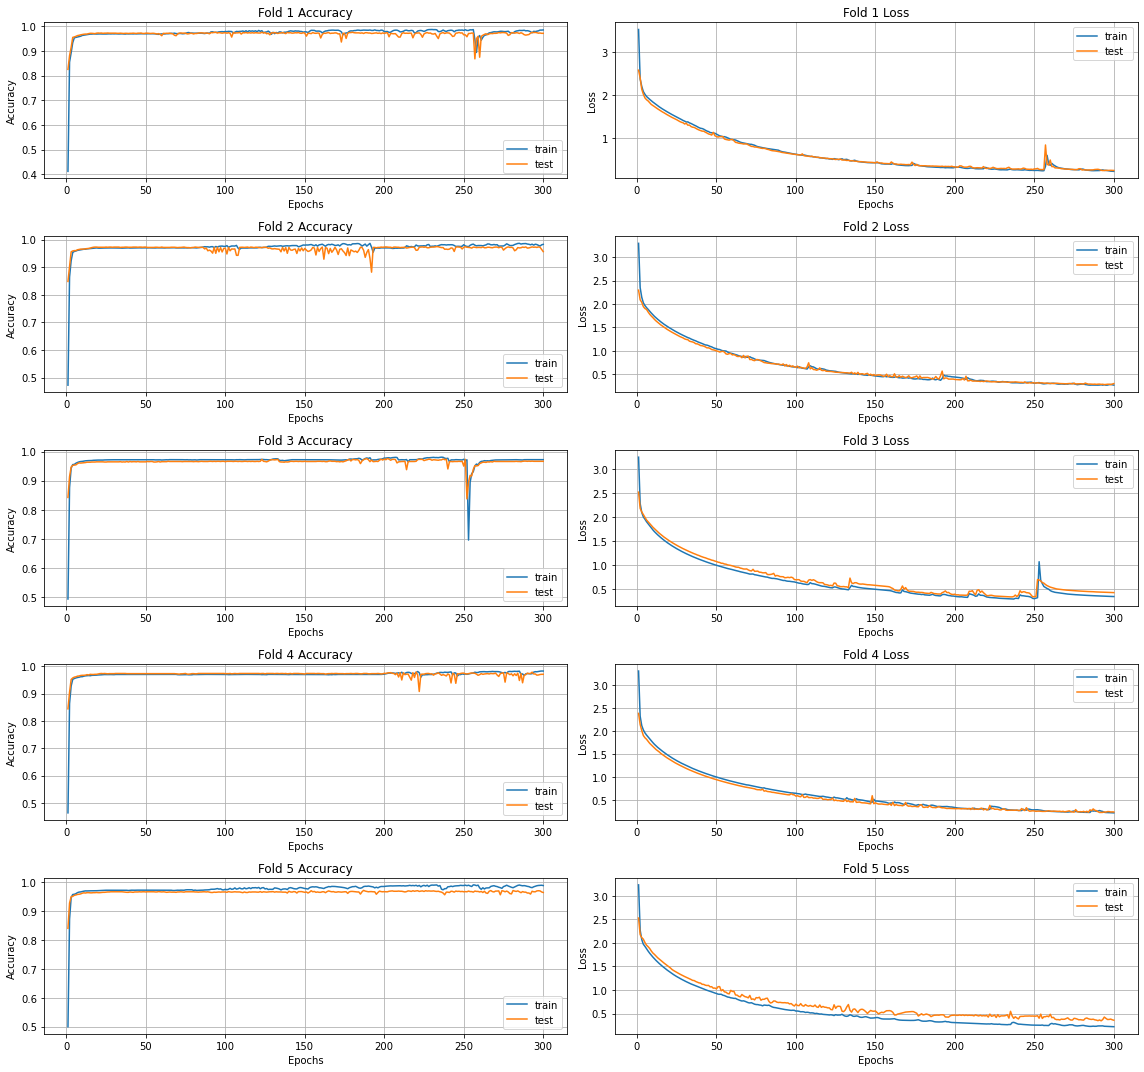

In [24]:
# Select best fold
best_fold = max(folds_res, key=lambda fold: fold['test_acc'][-1])

fig, axs = plt.subplots(len(folds_res), 2, figsize=(16, 15))

for idx, fold in enumerate(folds_res):    
    axs[idx, 0].plot(np.arange(1, epochs+1), fold['train_acc'], label='train')
    axs[idx, 0].plot(np.arange(1, epochs+1), fold['test_acc'], label='test')
    axs[idx, 0].set_ylabel('Accuracy')
    axs[idx, 0].set_xlabel('Epochs')
    axs[idx, 0].set_title(f'Fold {idx+1} Accuracy')
    axs[idx, 0].legend()
    axs[idx, 0].grid()

    axs[idx, 1].plot(np.arange(1, epochs+1), fold['train_losses'], label='train')
    axs[idx, 1].plot(np.arange(1, epochs+1), fold['test_losses'], label='test')
    axs[idx, 1].set_ylabel('Loss')
    axs[idx, 1].set_xlabel('Epochs')
    axs[idx, 1].set_title(f'Fold {idx+1} Loss')
    axs[idx, 1].legend()
    axs[idx, 1].grid()

plt.tight_layout()
plt.show()

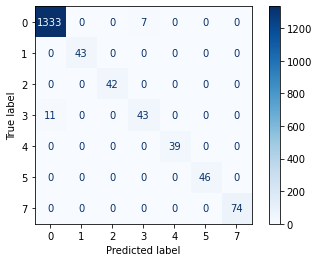

In [47]:
model.load_weights(f'.\\models\\{best_fold["fold"]}-fold-model.h5')

y_pred, y_true = np.array([]), np.array([])
for x_batch, y_batch in test_ds:
    probs = tf.nn.softmax(model(x_batch), axis=1).numpy()
    y_pred = np.hstack((y_pred, np.argmax(probs, axis=1)))
    y_true = np.hstack((y_true, y_batch.numpy().ravel()))
    
cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y))
disp.plot(cmap='Blues')
plt.show()

In [46]:
for label in np.unique(y):
    indexes = np.where(y == label)[0]

    ds = tf.data.Dataset.from_tensor_slices((X[indexes], y[indexes])).batch(indexes.shape[0])

    for x_batch, y_batch in ds:
        probs = tf.nn.softmax(model(x_batch), axis=1).numpy()
        y_pred = np.argmax(probs, axis=1)
        y_true = y_batch.numpy().ravel()

        acc = np.sum(y_pred == y_true) / y_true.shape[0]

        print(f'Class: {label}, Accuracy: {acc * 100:.2f} %')

Class: 0, Accuracy: 99.11 %
Class: 1, Accuracy: 100.00 %
Class: 2, Accuracy: 100.00 %
Class: 3, Accuracy: 68.35 %
Class: 4, Accuracy: 100.00 %
Class: 5, Accuracy: 100.00 %
Class: 7, Accuracy: 100.00 %
